# Notebook 33: Single HR panel for one mass and all periods

In [1]:
# nb_id is used to identify this notebook's output files (i.e., figures) if there are any
# it should match 
# the first two digits in the notebook's title
nb_id = 33

## Imports

In [2]:
from pathlib import Path
from math import isnan

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, TwoSlopeNorm, to_rgba
from matplotlib.lines import Line2D

import astropy.units as u
import astropy.constants as ct
from scipy.signal import find_peaks

import mesa_reader as mr
import mesaPlot as mp
import tulips as tp

import sys
sys.path.append('..')
from src.star import fix_unit, eggleton_rl1_radius, a_from_p, p_from_a, marchant_l2_radius
from src.util import (savefig_base, get_model_folder_base, get_model_dict, history_plot, 
                      hr_diagram_tracks_base, normarr)

plt.style.use('./plotstyle.mplstyle')

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

In [3]:
CODE_ROOT = Path('/mnt/home/ldesa/repos/cher')
DATA_ROOT = Path('/mnt/ceph/users/ldesa/mesa_che_grids')

In [4]:

FIGURE_FOLDER = Path(f'./output/nb{nb_id}/figures')
FIGURE_FOLDER.mkdir(parents=True, exist_ok=True)

In [5]:
plt.style.use('./plotstyle.mplstyle')

## Definitions

### Constants

In [6]:
Z_SUN = 0.017

### Utilities

In [7]:
def savefig(fig, fname):
    """Saves png, pdf and eps figure files to a nb-specific folder."""
    fname = f'nb{nb_id}_{fname}'
    plt.savefig(FIGURE_FOLDER/(fname+'.png'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.pdf'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.eps'), bbox_inches='tight')

In [8]:
def normarr(arr):
    return (arr-min(arr))/(max(arr)-min(arr))

In [9]:
def get_model_folder(model_id, verbose=True):
    """Finds model folder given its id."""
    matches = list(PROJECT_FOLDER.glob(f'{model_id}*'))
    
    if len(matches) > 1:
        if verbose:
            print('\n'.join((
                f'Multiple matches for id {model_id} found in {PROJECT_FOLDER}:',
                *[str(match) for match in matches]
            )))
        return
    elif len(matches) != 0:
        match = matches[0]
        if verbose:
            print(f'Found match {match}')
        return match
    else:
        if verbose:
            print(f'No matches found in {PROJECT_FOLDER}')
        return           

In [10]:
def get_model_dict(grid_folder):
    """Given a model folder, loads the paths of specific stars into a 
    m1, p_orb dictionary."""
    d = dict()
    for model_folder in grid_folder.glob('m*_w*'):
        if model_folder.suffix == '.log':
            continue
        try:
            m, p, w = model_folder.name.replace('d', 'e').split('_')
            w = float(w.lstrip('w'))
            p = f'{float(p.lstrip("p")):.2f}'      
        except ValueError:
            m, w = model_folder.name.replace('d', 'e').split('_')   
            w = float(w.lstrip('w'))
            p = (2*np.pi/w) / (60*60*24)
        m = f'{float(m.lstrip("m")):.1f}'
        
        if m not in d.keys():
            d[m] = dict()
        d[m][p] = model_folder
    return d

In [11]:
def mesareader_operator(expression):
    """Converts strings into operations between mesareader columns.
    
    Supports summation, subtraction, multiplication, division and exp10."""
    operations = ['+', '-', '*', '/', '^', 'E', '(', ')', ',']
    
    mr_expression = ''
    attr = ''
    char_i = 0
    while char_i < len(expression):
        char = expression[char_i]
        if char not in operations:
            mr_expression += f'h.__getattr__("{char}'
        else:
            if char == '^':
                char = '10**'
            elif char == 'E':
                char = 'gamma_e('
            mr_expression += f'{char}h.__getattr__("'
        char_i += 1
        char = expression[char_i]
        while char not in operations+['']:
            attr += char
            char_i += 1
            try:
                char = expression[char_i]
            except IndexError:
                char = ''
        if char == '^':
            char = '10**'
        elif char == 'E':
                char = 'gamma_e('
        attr = f'{attr}"){char}'
        mr_expression += attr
        attr = ''
        char_i += 1
            
    return mr_expression


### Plotting

In [12]:
def history_plot(ax, model_dict_list, model_styles, model_labels, x, y, invert_xaxis, invert_yaxis, title=False,
                 label_period=True):
    """2D line plot for all m1, p_orb combinations from a given model.
    
    Assumes a single m1 per dict.
    """
    
    #base_dict = model_dict_list[0]
    #all_paths = [base_dict[k1][k2] for k1 in base_dict.keys() for k2 in base_dict[k1].keys()] 
    
    all_periods = []
    for dict_ in model_dict_list:
        for k1 in dict_.keys():
            for k2 in dict_[k1].keys():
                all_periods.append(k2)
    all_periods = np.unique(all_periods)
    all_periods = all_periods[np.argsort([float(p) for p in all_periods])]
    
    period_color_dict = {}
    for i, p in enumerate(all_periods):
        period_color_dict[p] = cm.jet(i/len(all_periods))
    
    handles = []
    for p_key in all_periods:
        p = float(p_key)
        c = period_color_dict[p_key]
        
        if label_period:
            label = f'${p:.2f}\\,\\mathrm{{d}}$'
        else:
            label = None
        handles.append(Line2D([], [], ls='-', color=c, label=label))
               
        for dict_, ls in zip(model_dict_list, model_styles):
            dict_ = dict_[list(dict_.keys())[0]]
            try:
                model_path = dict_[p_key]
                h = mr.MesaData(str(model_path/'LOGS/history.data'))
            except:
                print(f'Model {model_path} failed to load.')
                continue
            else:
                x_data = eval(mesareader_operator(x))
                y_data = eval(mesareader_operator(y))
                ax.plot(x_data, y_data, ls=ls, color=c, lw=1)
                
    if invert_xaxis:
        ax.invert_xaxis()
    if invert_yaxis:
        ax.invert_yaxis()
    
    if title:
        ax.set_title(model_labels[0], fontsize=20)
    #else:
        #for ls, label in zip(model_styles, model_labels):
         #   handles.append(Line2D([], [], color='k', ls=ls, label=label))
    if label_period:
        ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=2)
    
    return ax, handles

### Winds

In [13]:
def _sanders_winds(l, t, z):
    logz = np.log10(z/Z_SUN)
    alpha = 0.32 * logz + 1.4
    l0 = 10.**(-0.87*logz + 5.06)
    mdot10 = 10.**(-0.75*logz - 4.06)
    
    if l <= l0:
        log_power_term = 0
    else:
        log_power_term = np.log10(l/l0) ** alpha
              
    w = mdot10 * log_power_term * (l/(10*l0))**0.75
    
    if t > 1.41e5 and l > l0:
        log_w = np.log10(w) - 6*np.log10(t/1.41e5)
        w = 10.**log_w
    return w

def _vink2017_winds(l, z):
    log_mdot = - 13.3 + 1.36*np.log10(l) + 0.61*np.log10(z/Z_SUN)
    return 10.**log_mdot

def _vink2001_winds(l, t, m, z):
    Teff_jump = 1e3*(61.2 + 2.59*(-13.636 + 0.889*np.log10(z/Z_SUN)))
    
    if t > 27.5e3:
        a = 1
    elif t < 22.5e3:
        a = 0
    else:
        dt = 100
        if t > Teff_jump + dt:
            a = 1
        elif t < Teff_jump - dt:
            a = 0
        else:
            a = (t - (Teff_jump - dt)) / (2*dt)
    
    if a > 0:
        vinf_div_vesc = 2.6
        vinf_div_vesc = vinf_div_vesc * (z/Z_SUN)**0.13
        log_mdot = (
            - 6.697
            + 2.194 * np.log10(l/1e5)
            - 1.313 * np.log10(m/3e1)  
            - 1.226 * np.log10(vinf_div_vesc/2e0)              
            + 0.933 * np.log10(t/4e4) 
            - 10.92 * np.log10(t/4e4)**2
            + 0.85 * np.log10(z/Z_SUN)
            )
        mdot1 = 10.**log_mdot
    else:
        mdot1 = 0
        
    if a < 1:
        vinf_div_vesc = 1.3    
        vinf_div_vesc = vinf_div_vesc * (z/Z_SUN)**0.13
        log_mdot = (
            - 6.688 
            + 2.210 * np.log10(l/1e5) 
            - 1.339 * np.log10(m/3e1) 
            - 1.601 * np.log10(vinf_div_vesc/2)
            + 1.07 * np.log10(t/2e4) 
            + 0.85 * np.log10(z/Z_SUN)
            )
        mdot2 = 10.**log_mdot
    else:
        mdot2 = 0
        
    w = a*mdot1 + (1-a)*mdot2  
    return w


In [14]:
vink2001_w = np.vectorize(_vink2001_winds)
vink2017_winds = np.vectorize(_vink2017_winds)
sanders_winds = np.vectorize(_sanders_winds)

In [15]:
def _winds(l, t, m, z, y):
    
    v01 = vink2001_winds(l, t, m, z)
    v17 = vink2017_winds(l, z)
    s23 = sanders_winds(l, t, z)
    
    he_w = max(v17, s23)
    
    if y < 0.4:
        y_weight = 0
    elif y < 0.7:
        y_weight = (y - 0.4)/0.3
    else:
        y_weight = 1
        
    w = y_weight * he_w + (1-y_weight) * v01
    
    return w
    

In [16]:
winds = np.vectorize(_winds)

## HR diagram

In [17]:
def log_l_const_rad(log_teff, r):
    teff = 10.**log_teff * u.K
    r = fix_unit(r, u.Rsun)
    log_l = np.log10(4*np.pi*ct.sigma_sb * teff**4 * r**2 / u.Lsun)
    return log_l
log_l_const_rad = np.vectorize(log_l_const_rad)

In [18]:
def hd_limit(log_teff):
    teff = 10**log_teff * u.K
    log_l = (
        np.log10(1.e5*np.sqrt(4*np.pi))
        + 0.5*np.log10(ct.sigma_sb * u.Rsun**2 * teff**4 / u.Lsun)
    ).value
    log_l = max(log_l, np.log10(6.e5))
    return log_l
hd_limit = np.vectorize(hd_limit)

In [19]:
def hr_diagram_tracks(
    ax,
    models_to_plot,
    model_style_list,
    xlim, 
    ylim,
    legend=True,
    labelx=True, 
    labely=True
    ):
    model_dict_list = model_dicts[models_to_plot]
    model_label_list = model_labels[models_to_plot]
    
    settings = dict(
        x='log_Teff',
        y='log_L',
        invert_xaxis=True,
        invert_yaxis=False,
        model_dict_list=model_dict_list,
        model_styles=model_style_list,
        model_labels=model_label_list,
        label_period=legend
        )

    ax, handles = history_plot(ax, **settings)

    if labelx:
        ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
    if labely:
        ax.set_ylabel('$\\log L/\\mathrm{L}_\\odot$')

    # GUIDELINES
    
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()

    ## Humphreys-Davidson limit and LBV regime
    hd_x = np.linspace(*xlim, 100)
    hd_y = hd_limit(hd_x)
    ax.plot(hd_x, hd_y, 'k--', lw=1)
    ax.fill_between(hd_x, hd_y, [ylim[1]]*len(hd_y), color='k', alpha=0.05)

    ## Lines of constant radius
    r_to_plot = np.concatenate((np.arange(0.5, 1, 0.1), np.arange(1, 10, 1), np.arange(10, 40, 10)))
    for i, r in enumerate(r_to_plot):
        r_y = log_l_const_rad(hd_x, r)
        ax.plot(hd_x, r_y, 'k--', lw=0.5, alpha=0.5)
        
        # label every two lines
        if not i%2:
            rotation = -np.arctan((r_y[10]-r_y[0])/(hd_x[10]-hd_x[0]))/np.pi*180       
            r_y_ = r_y[(hd_x >= xlim[1]) & (hd_x <= xlim[0])]
            y = r_y_[np.argmin(np.abs(r_y_-ylim[1]))]     
            x = hd_x[np.argmin(np.abs(r_y-y))]
            if (x < max(xlim) and x > min(xlim)) and (y < max(ylim) and y > min(ylim)):
                ax.text(
                    x, 
                    y,
                    f'${r:.1f}\\,\\mathrm{{R}}_\\odot$',
                    rotation=rotation,
                    ha='left',
                    va='top', 
                    fontsize=6,
                    alpha=0.8
                    )
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
        
    return ax, handles

In [20]:
def density_temperature_diagram_tracks(
    ax,
    models_to_plot,
    model_style_list,
    xlim, 
    ylim,
    legend=True,
    labelx=True, 
    labely=True
    ):
    model_dict_list = model_dicts[models_to_plot]
    model_label_list = model_labels[models_to_plot]
    
    settings = dict(
        x='log_center_Rho',
        y='log_center_T',
        invert_xaxis=False,
        invert_yaxis=False,
        model_dict_list=model_dict_list,
        model_styles=model_style_list,
        model_labels=model_label_list,
        label_period=legend
        )

    ax = history_plot(ax, **settings)

    if labelx:
        ax.set_xlabel('$\\log \\rho_\\mathrm{c}/\\mathrm{g}\\,\\mathrm{cm}^{-3}$')
    if labely:
        ax.set_ylabel('$\\log T_\\mathrm{c}/\\mathrm{K}$')

    # GUIDELINES
    
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    return ax

In [21]:
def old_e_scattering_edd_l(m):
    m = fix_unit(m, u.Msun)
    k = 0.4 * u.cm**2 /u.g
    l = 4*np.pi*ct.c*ct.G*m/k
    l = l.to(u.Lsun)
    return l.value

In [22]:
def gamma_e(m, l, x):
    m = fix_unit(m, u.Msun).value
    l = fix_unit(l, u.Lsun).value
    return 10.**-4.813 * (1+x) * l/m

In [23]:
def hre_diagram_tracks(
    ax,
    models_to_plot,
    model_style_list,
    xlim, 
    ylim,
    legend=True,
    labelx=True, 
    labely=True
    ):
    model_dict_list = model_dicts[models_to_plot]
    model_label_list = model_labels[models_to_plot]
    
    settings = dict(
        x='log_Teff',
        #y='^log_L/Estar_mass)',
        y='Estar_mass,^log_L,surface_h1)',
        invert_xaxis=True,
        invert_yaxis=False,
        model_dict_list=model_dict_list,
        model_styles=model_style_list,
        model_labels=model_label_list,
        label_period=legend
        )

    ax, handles = history_plot(ax, **settings)

    if labelx:
        ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
    if labely:
        ax.set_ylabel('$\\Gamma_\\mathrm{e}$')
    
    if xlim is not None:    
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    
    return ax, handles

### Final properties

In [24]:
def get_core_mass_spin_w(logs, iso):
    central_iso_arr = [logs.profile_data(profile_number=n).__getattr__(iso)[-1] for n in logs.profile_numbers]
    max_iso_i = np.argmax(central_iso_arr)
    core_prof = logs.profile_data(profile_number=logs.profile_numbers[max_iso_i])
    core_edge_index = np.where(np.abs(core_prof.__getattr__(iso)-core_prof.__getattr__(iso)[-1]) <= 0.01)[0][0]
    core_mass = core_prof.mass[core_edge_index]
    core_am = 10**core_prof.log_J_inside[core_edge_index]
    core_w = core_prof.omega[core_edge_index]
    core_spin = (ct.c.cgs * core_am * u.g*u.cm**2/u.s / (ct.G.cgs * (core_mass * ct.M_sun.cgs)**2 )).to(u.dimensionless_unscaled).value
    return core_mass, core_spin, core_w

In [25]:
class WindIntegrator:
    
    def __init__(self, model_path, q0=1) -> None:
        self.h = mr.MesaData(str(model_path/'LOGS/history.data'))
        self.logs = mr.MesaLogDir(str(model_path/'LOGS'))
        self.time = self.h.star_age
        self.mdot = -10.**self.h.log_abs_mdot
        self.w0 = self.h.surf_avg_omega[np.where(self.h.surf_avg_omega > 0)[0][0]]
        self.p0 = 2*np.pi/self.w0 * u.s.to(u.d)
        self.q0 = q0
        
    @staticmethod
    def a_from_p(p, m, q):
        p = fix_unit(p, u.d)
        m = fix_unit(m, u.Msun)
        a = np.cbrt(ct.G * (1+q) * m / (4*np.pi**2) * p**2)
        a = a.to(u.Rsun).value
        return a
        
    @staticmethod
    def p_from_a(a, m, q):
        a = fix_unit(a, u.Rsun)
        m = fix_unit(m, u.Msun)
        p = np.sqrt(4 * np.pi**2 / (ct.G * (1+q) * m) * a**3)
        p = p.to(u.d).value
        return p
    
    def integrate(self, t_target):
        m = self.h.star_mass[0]
        p = self.p0
        q = self.q0
        a = self.a_from_p(p, m, q)
        
        i = 0
        t0 = self.time[i]
        t1 = self.time[i+1]
        mdot = self.mdot[i]
        while t1 < t_target:
            dm = mdot*(t1-t0)
            da = -2/(1+q) * dm/m
            dq = 0
            
            m += dm
            a += da
            q += dq
            p = self.p_from_a(a, m, q)
            
            i += 1
            try:
                t1 = self.time[i+1]   
            except:
                print(f'Reached end of model at t={t1/1e6:.2f} Myr')
                break
            else:
                t0 = self.time[i]
                mdot = self.mdot[i]
        
        return m, p, a, q
    
    @staticmethod
    def p_from_s(s, m):
        j = (ct.G.cgs * (m * u.Msun)**2 * s / ct.c.cgs).to(u.s).value
        return p
    
    def get_final_core_mps(self):
        core_m, core_s, core_w = get_core_mass_spin_w(self.logs, iso='o16')
        core_p = 2*np.pi/core_w * u.s.to(u.d)
        return core_m, core_p, core_s

In [26]:
def edd_gamma(x, l, m):
    return 10**-4.813 * (1+x) * l/m

def krticka2024_w(l, teff, z):
    a = -13.82
    b = 1.52
    c = 3.84
    t1 = 14.16e3
    t2 = 37.9e3
    dt1 = 3.58e3
    dt2 = 56.5e3
    alpha = 0.358
    beta = -0.11
    delta = 0.73
    log_z_div_z_sun = np.log10(z/Z_SUN)
    
    log_lin_comp = (a
                    + alpha * log_z_div_z_sun
                    + (b + beta * log_z_div_z_sun) * np.log10(l/1e6))
    gauss_mix_comp = ((1 + delta * log_z_div_z_sun) * np.exp(-(teff-t1)**2/dt1**2)
                      + c * np.exp(-(teff-t2)**2/dt2**2))
    log_mdot = log_lin_comp - a * np.log10(gauss_mix_comp)
    w = 10.**log_mdot
    return w

def bjorklund2023_w(l, m, teff, z, x):
    g_e = edd_gamma(x, l, m)
    meff = (1-g_e)*m
    log_mdot = (-5.52
                +2.39*np.log10(l/1e6)
                -1.48*np.log10(meff/45)
                +2.12*np.log10(teff/4.5e4)
                +(0.75
                  -1.87*np.log10(teff/4.5e4)) * np.log10(z/Z_SUN))
    w = 10.**log_mdot 
    return w

def vink2017_w(l, z):
    log_mdot = -13.3 + 1.36*np.log10(l) + 0.61*np.log10(z/Z_SUN)
    w = 10.**log_mdot
    return w

def sander2023_w(l, t, z):
    logz = np.log10(z/Z_SUN)
    alpha = 0.32 * logz + 1.4
    l0 = 10.**(-0.87*logz + 5.06)
    mdot10 = 10.**(-0.75*logz - 4.06)
    
    if l <= l0:
        log_power_term = 0
    else:
        log_power_term = np.log10(l/l0) ** alpha
              
    w = mdot10 * log_power_term * (l/(10*l0))**0.75
    
    if t > 1e5 and l > l0:
        log_w = np.log10(w) - 6*np.log10(t/1e5)
        w = 10.**log_w
    return w

def get_g_switch(l, m, t, z, x, scheme):
    z_div_zsun = z/Z_SUN
    if scheme == 'vink':
        g_switch = 0.243 * z_div_zsun**-0.541
    elif scheme == 'krticka':
        g_switch = 0.585 * z_div_zsun**-0.016
    elif scheme == 'bjorklund':
        g_switch = 0.838 * z_div_zsun**-0.099
    elif scheme == 'bjorklund+krticka':
        k24_w = krticka2024_w(l, t, z)
        b23_w = bjorklund2023_w(l, m, t, z, x)
        if k24_w <= b23_w:
            g_switch = 0.585 * z_div_zsun**-0.016
        else:
            g_switch = 0.838 * z_div_zsun**-0.099
    return g_switch

def vink2011_winds(l, m, t, z, x, g_switch, m_switch):
    g_e = edd_gamma(x, l, m)
    v01_w = vink2001_w(l, t, m, z)
    
    if g_e < g_switch:
        w = v01_w
    else:
        w = v01_w * (m/m_switch)**0.78 * (g_e/g_switch)**4.77
        
    return w
        

class Winds:
    
    def __init__(self, ms_winds):
        self.ms_winds = ms_winds
        self.g_switch = None
        self.m_switch = 10
        self.vms_switch = False
        
    def winds(self, l, m, teff, z, x, ms_winds):
        x0 = 0.6
        dx = 0.3
        
        #MS or WR winds
        if x > x0:
            he_poor_a = 1
        elif x > x0-dx:
            he_poor_a = (x - (x0-dx)) / dx
        else:
            he_poor_a = 0
        
            
        vink2001_winds = vink2001_w(l, teff, m, z)
        bjorklund2023_winds = bjorklund2023_w(l, m, teff, z, x)
        krticka2024_winds = krticka2024_w(l, teff, z)
        vink2017_winds = vink2017_w(l, z)
        sander2023_winds = sander2023_w(l, teff, z)
        
        if ms_winds == 'vink':
            ms_w = vink2001_winds
        elif ms_winds == 'bjorklund':
            ms_w = bjorklund2023_winds
        elif ms_winds == 'krticka':
            ms_w = krticka2024_winds
        elif ms_winds == 'bjorklund+krticka':
            ms_w = min(bjorklund2023_winds, krticka2024_winds)
        else:
            raise ValueError(f'Value {ms_winds} not recognized for ms_winds')
        
        if self.g_switch is None:
            g_switch = get_g_switch(l, m, teff, z, x, scheme=ms_winds)
        else:
            g_switch = self.g_switch
        g_e = edd_gamma(x, l, m)
        
        if (g_e >= g_switch) and (self.vms_switch is False):
            self.vms_switch = True
            self.m_switch = m
            self.g_switch = g_switch
            
        vms_w = vink2011_winds(l, m, teff, z, x, g_switch, self.m_switch)
        
        if g_e > g_switch:
            ms_w = vms_w        
        
        w = (1-he_poor_a)*max(vink2017_winds, sander2023_winds) + he_poor_a * ms_w
        return w
    
    
def winds(l, m, teff, z, x, ms_winds='vink'):
    x0 = 0.6
    dx = 0.3
       
    #MS or WR winds
    if x > x0:
        he_poor_a = 1
    elif x > x0-dx:
        he_poor_a = (x - (x0-dx)) / dx
    else:
        he_poor_a = 0
    
        
    vink2001_winds = vink2001_w(l, teff, m, z)
    bjorklund2023_winds = bjorklund2023_w(l, m, teff, z, x)
    krticka2024_winds = krticka2024_w(l, teff, z)
    vink2017_winds = vink2017_w(l, z)
    sander2023_winds = sander2023_w(l, teff, z)
    
    if ms_winds == 'vink':
        ms_w = vink2001_winds
    elif ms_winds == 'bjorklund':
        ms_w = bjorklund2023_winds
    elif ms_winds == 'krticka':
        ms_w = krticka2024_winds
    elif ms_winds == 'bjorklund+krticka':
        ms_w = min(bjorklund2023_winds, krticka2024_winds)
    else:
        raise ValueError(f'Value {ms_winds} not recognized for ms_winds')
    
    g_switch = get_g_switch(l, m, teff, z, x, scheme=ms_winds)
    
    
    w = (1-he_poor_a)*max(vink2017_winds, sander2023_winds) + he_poor_a * ms_w
    return w
    

In [27]:
def set_mcores(sample, of_kind='none', of_when='zams'):
    for i, star in enumerate(sample):
        if of_when == 'zams':
            r = star[3]
        elif of_when == 'prezams':
            r = star[2]
        else:
            raise ValueError(f'Value {of_when} not valid for arg of_when')
        
        if of_kind == 'none':
            mcore = mzams_mcore_interpolator(star[0], star[1])
        else:
            try:
                isof = is_of(r=r, m=star[0], p=star[1], q=1, kind=of_kind)            
            except ValueError:
                raise ValueError(f'Value {of_kind} not valid for arg of_kind')
            else:
                if isof:
                    mcore = nan
                else:
                    mcore = mzams_mcore_interpolator(star[0], star[1])
                
        sample[i, 4] = mcore
    return sample

# Analysis

In [80]:
PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1'

model_ids = np.arange(1, 11, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

model_dicts_01zsun = model_dicts

###

PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept/01_ZdivZsun_2d-1'

model_ids = np.arange(1, 11, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

model_dicts_02zsun = model_dicts

###

PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept/02_ZdivZsun_4d-1'

model_ids = np.arange(1, 11, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

model_dicts_04zsun = model_dicts

###

PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept/03_ZdivZsun_6d-1'

model_ids = np.arange(1, 11, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

model_dicts_06zsun = model_dicts

###

PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept/04_ZdivZsun_8d-1'

model_ids = np.arange(1, 11, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

model_dicts_08zsun = model_dicts

###

PROJECT_FOLDER = DATA_ROOT/'sse_enhanced_w_proof_of_concept/05_ZdivZsun_1d0'

model_ids = np.arange(1, 11, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

model_dicts_10zsun = model_dicts

Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/001_md1_m20_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/002_md1_m30_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/003_md1_m40_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/004_md1_m50_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/005_md1_m60_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/006_md1_m70_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/007_md1_m80_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZs

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


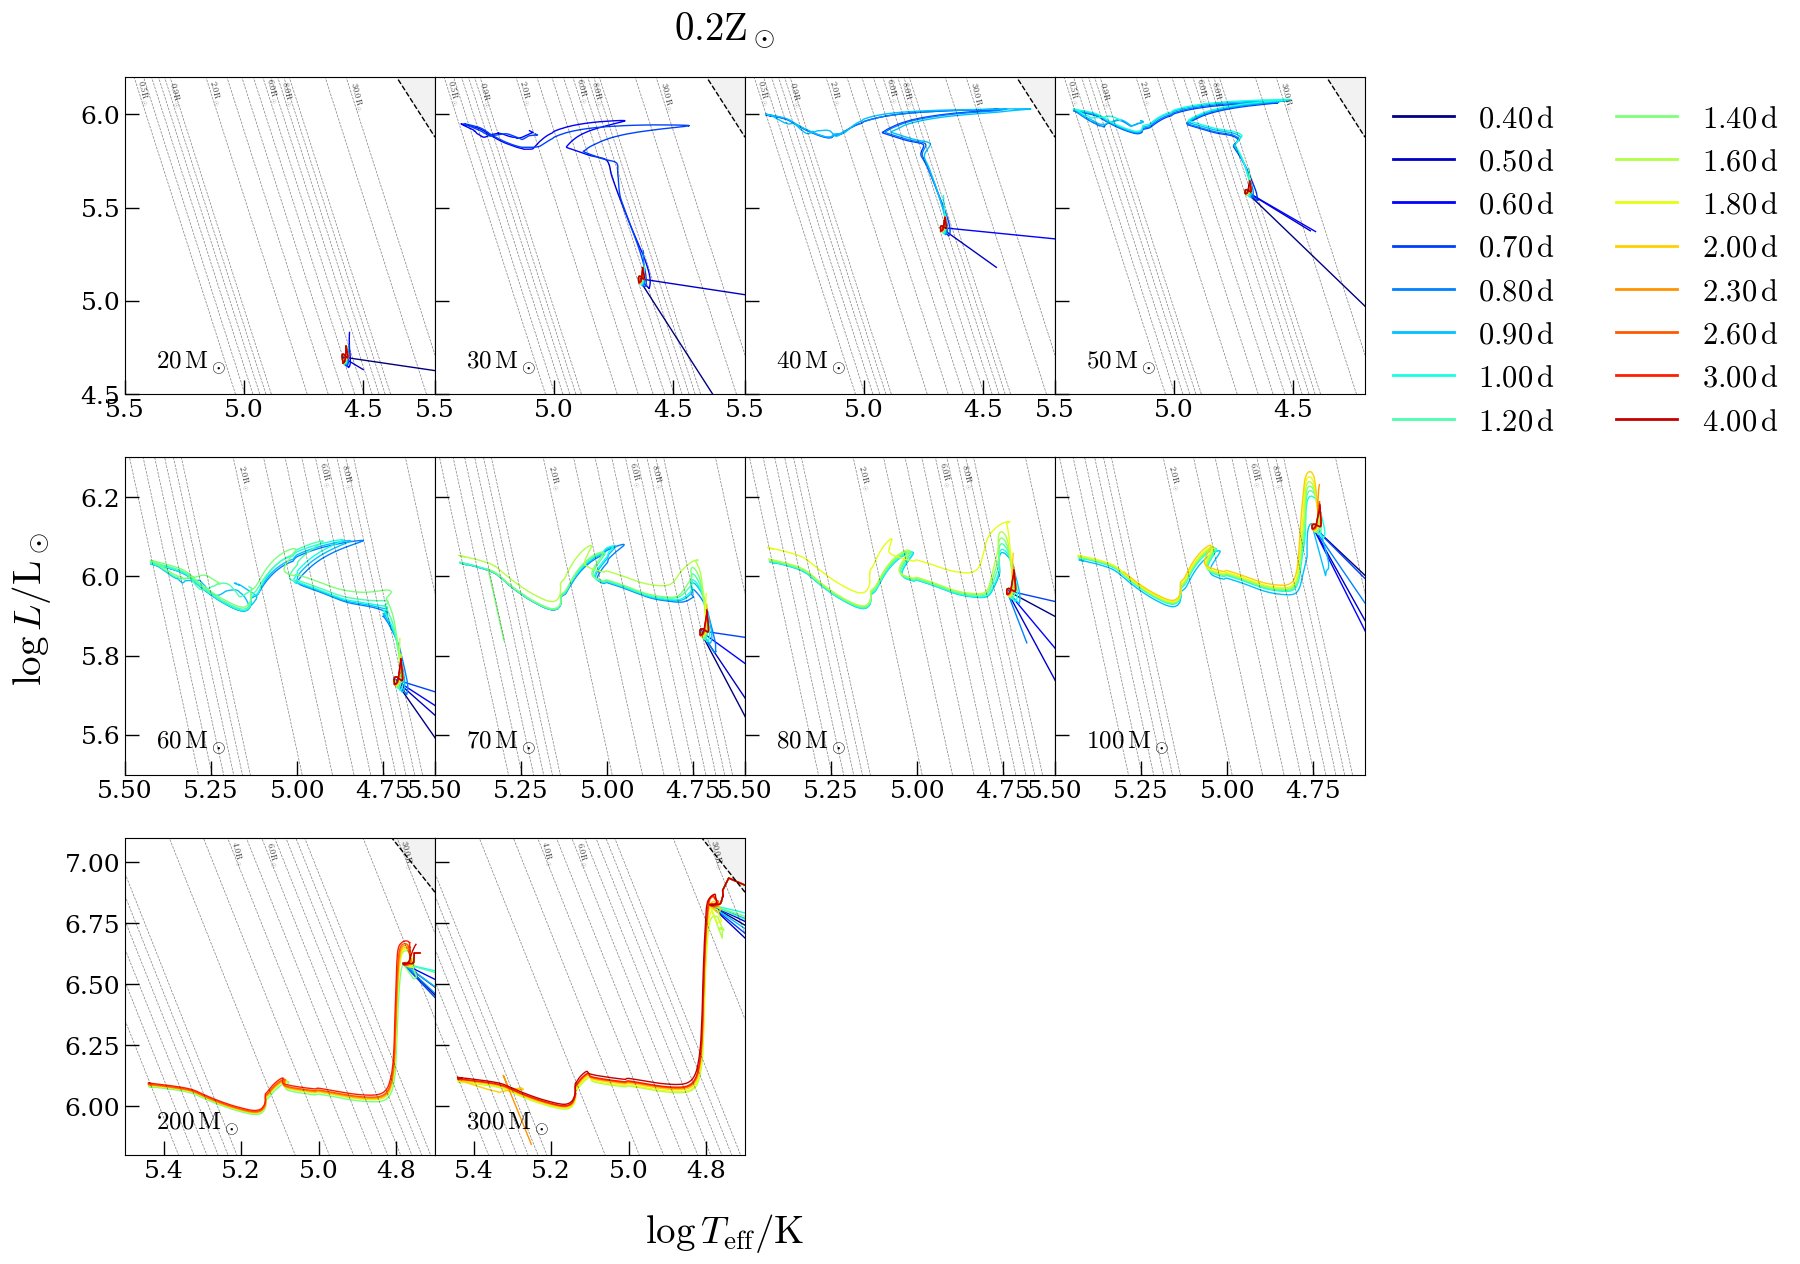

In [29]:
fig, axes = plt.subplots(3, 4, figsize=(16, 14))
fig.subplots_adjust(wspace=0)

model_dicts = model_dicts_02zsun

mass_label_x = 0.1
mass_label_y = 0.1
mass_label_fontsize = 18

xlim = (5.5, 4.2)
ylim = (4.5, 6.2)

# PLOT M=20
ax = axes[0, 0]
models_to_plot = [0]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.text(mass_label_x, mass_label_y, '$20\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=30
ax = axes[0, 1]
models_to_plot = [1]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$30\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=40
ax = axes[0, 2]
models_to_plot = [2]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$40\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=50
ax = axes[0, 3]
models_to_plot = [3]
model_style_list = ['-']
legend = True
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$50\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

xlim = (5.5, 4.6)
ylim = (5.5, 6.3)

# PLOT M=60
ax = axes[1, 0]
models_to_plot = [4]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.text(mass_label_x, mass_label_y, '$60\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)



# PLOT M=70
ax = axes[1, 1]
models_to_plot = [5]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$70\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=80
ax = axes[1, 2]
models_to_plot = [6]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$80\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=100
ax = axes[1, 3]
models_to_plot = [7]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$100\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)


xlim = (5.5, 4.7)
ylim = (5.8, 7.1)

# PLOT M=200
ax = axes[2, 0]
models_to_plot = [8]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.text(mass_label_x, mass_label_y, '$200\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=300
ax = axes[2, 1]
models_to_plot = [9]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$300\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

axes[2, 2].axis('off')
axes[2, 3].axis('off')


#######################################

fig.text(0.5, 0.07, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', va='top', ha='center')
fig.text(0.08, 0.5, '$\\log L/\\mathrm{L}_\\odot$', rotation=90, va='center', ha='right')
fig.text(0.5, 0.9, '$0.2\\mathrm{Z}_\\odot$', va='bottom', ha='center')

savefig(fig, 'hr_allp_mass_comparison_02Zsun')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


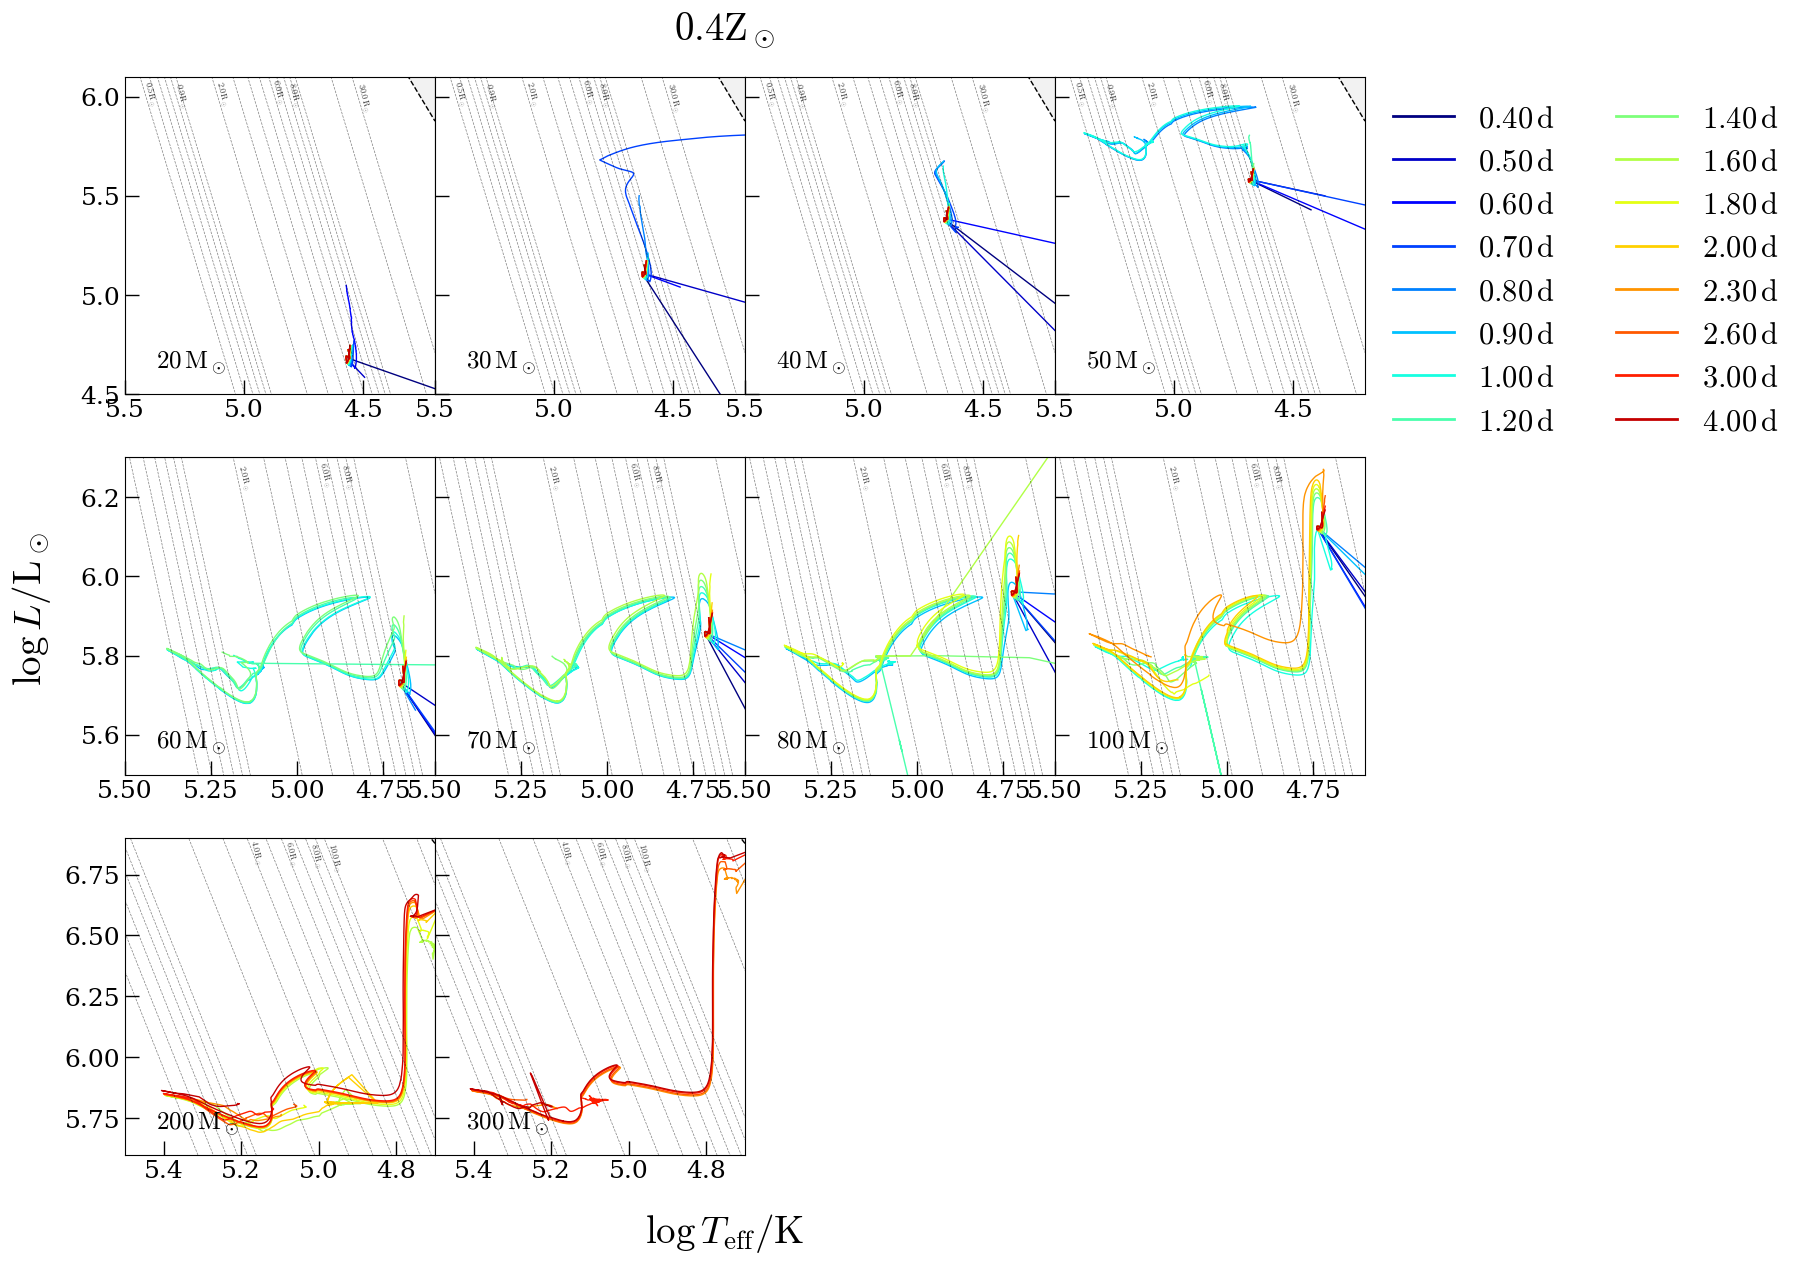

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(16, 14))
fig.subplots_adjust(wspace=0)

model_dicts = model_dicts_04zsun

mass_label_x = 0.1
mass_label_y = 0.1
mass_label_fontsize = 18

xlim = (5.5, 4.2)
ylim = (4.5, 6.1)

# PLOT M=20
ax = axes[0, 0]
models_to_plot = [0]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.text(mass_label_x, mass_label_y, '$20\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=30
ax = axes[0, 1]
models_to_plot = [1]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$30\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=40
ax = axes[0, 2]
models_to_plot = [2]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$40\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=50
ax = axes[0, 3]
models_to_plot = [3]
model_style_list = ['-']
legend = True
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$50\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

xlim = (5.5, 4.6)
ylim = (5.5, 6.3)

# PLOT M=60
ax = axes[1, 0]
models_to_plot = [4]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.text(mass_label_x, mass_label_y, '$60\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)



# PLOT M=70
ax = axes[1, 1]
models_to_plot = [5]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$70\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=80
ax = axes[1, 2]
models_to_plot = [6]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$80\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=100
ax = axes[1, 3]
models_to_plot = [7]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$100\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)


xlim = (5.5, 4.7)
ylim = (5.6, 6.9)

# PLOT M=200
ax = axes[2, 0]
models_to_plot = [8]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.text(mass_label_x, mass_label_y, '$200\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=300
ax = axes[2, 1]
models_to_plot = [9]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$300\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

axes[2, 2].axis('off')
axes[2, 3].axis('off')


#######################################

fig.text(0.5, 0.07, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', va='top', ha='center')
fig.text(0.08, 0.5, '$\\log L/\\mathrm{L}_\\odot$', rotation=90, va='center', ha='right')
fig.text(0.5, 0.9, '$0.4\\mathrm{Z}_\\odot$', va='bottom', ha='center')

savefig(fig, 'hr_allp_mass_comparison_04zsun')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


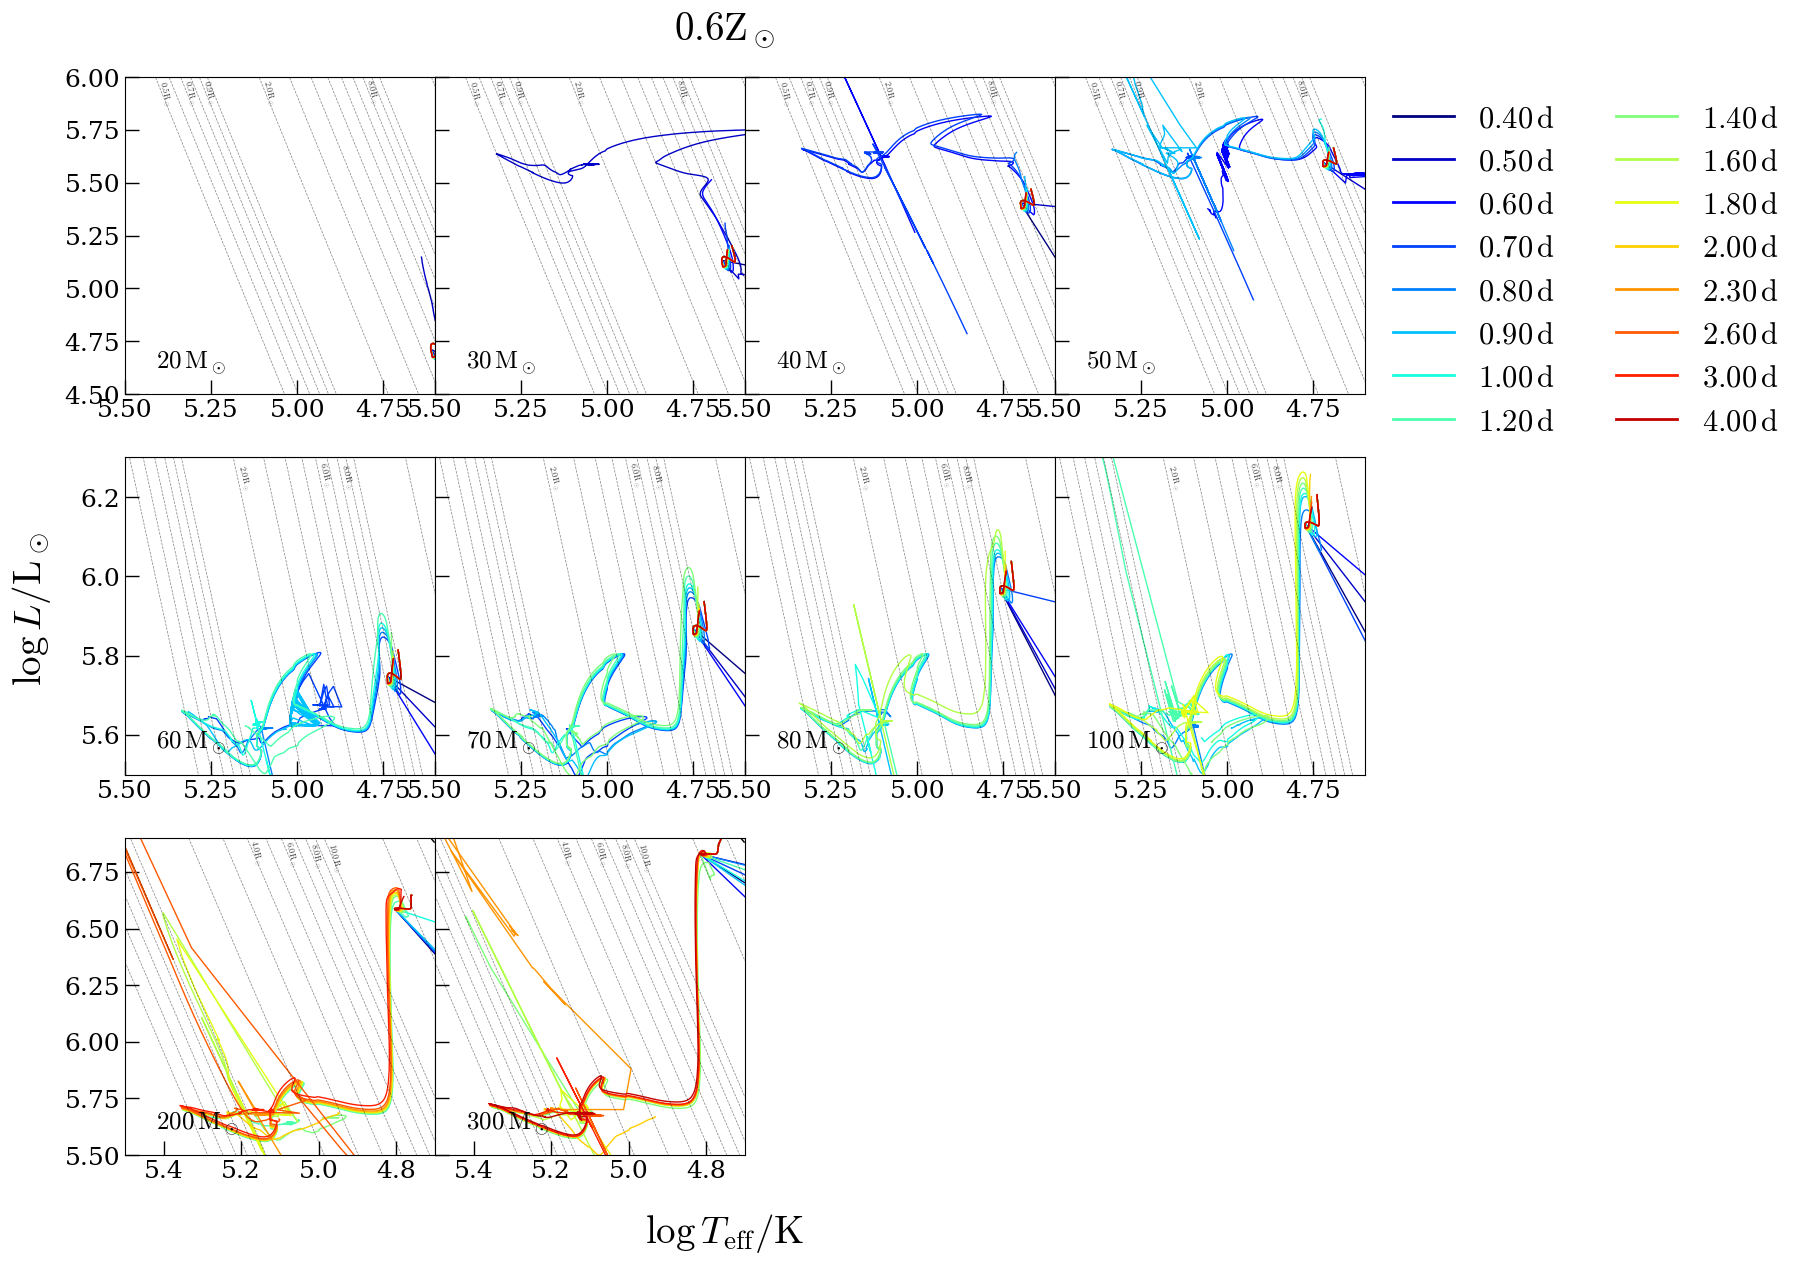

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(16, 14))
fig.subplots_adjust(wspace=0)

model_dicts = model_dicts_06zsun

mass_label_x = 0.1
mass_label_y = 0.1
mass_label_fontsize = 18

xlim = (5.5, 4.6)
ylim = (4.5, 6.0)

# PLOT M=20
ax = axes[0, 0]
models_to_plot = [0]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.text(mass_label_x, mass_label_y, '$20\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=30
ax = axes[0, 1]
models_to_plot = [1]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$30\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=40
ax = axes[0, 2]
models_to_plot = [2]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$40\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=50
ax = axes[0, 3]
models_to_plot = [3]
model_style_list = ['-']
legend = True
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$50\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

xlim = (5.5, 4.6)
ylim = (5.5, 6.3)

# PLOT M=60
ax = axes[1, 0]
models_to_plot = [4]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.text(mass_label_x, mass_label_y, '$60\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)



# PLOT M=70
ax = axes[1, 1]
models_to_plot = [5]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$70\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=80
ax = axes[1, 2]
models_to_plot = [6]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$80\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=100
ax = axes[1, 3]
models_to_plot = [7]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$100\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)


xlim = (5.5, 4.7)
ylim = (5.5, 6.9)

# PLOT M=200
ax = axes[2, 0]
models_to_plot = [8]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.text(mass_label_x, mass_label_y, '$200\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=300
ax = axes[2, 1]
models_to_plot = [9]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$300\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

axes[2, 2].axis('off')
axes[2, 3].axis('off')


#######################################

fig.text(0.5, 0.07, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', va='top', ha='center')
fig.text(0.08, 0.5, '$\\log L/\\mathrm{L}_\\odot$', rotation=90, va='center', ha='right')
fig.text(0.5, 0.9, '$0.6\\mathrm{Z}_\\odot$', va='bottom', ha='center')

savefig(fig, 'hr_allp_mass_comparison_06zsun')

Model /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/04_ZdivZsun_8d-1/005_md1_m60_zsundiv10_04y0_03dy/m6.000d+01_p8.000d-01_w9.090d-05 failed to load.
Model /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/04_ZdivZsun_8d-1/010_md1_m300_zsundiv10_04y0_03dy/m3.000d+02_p8.000d-01_w9.090d-05 failed to load.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


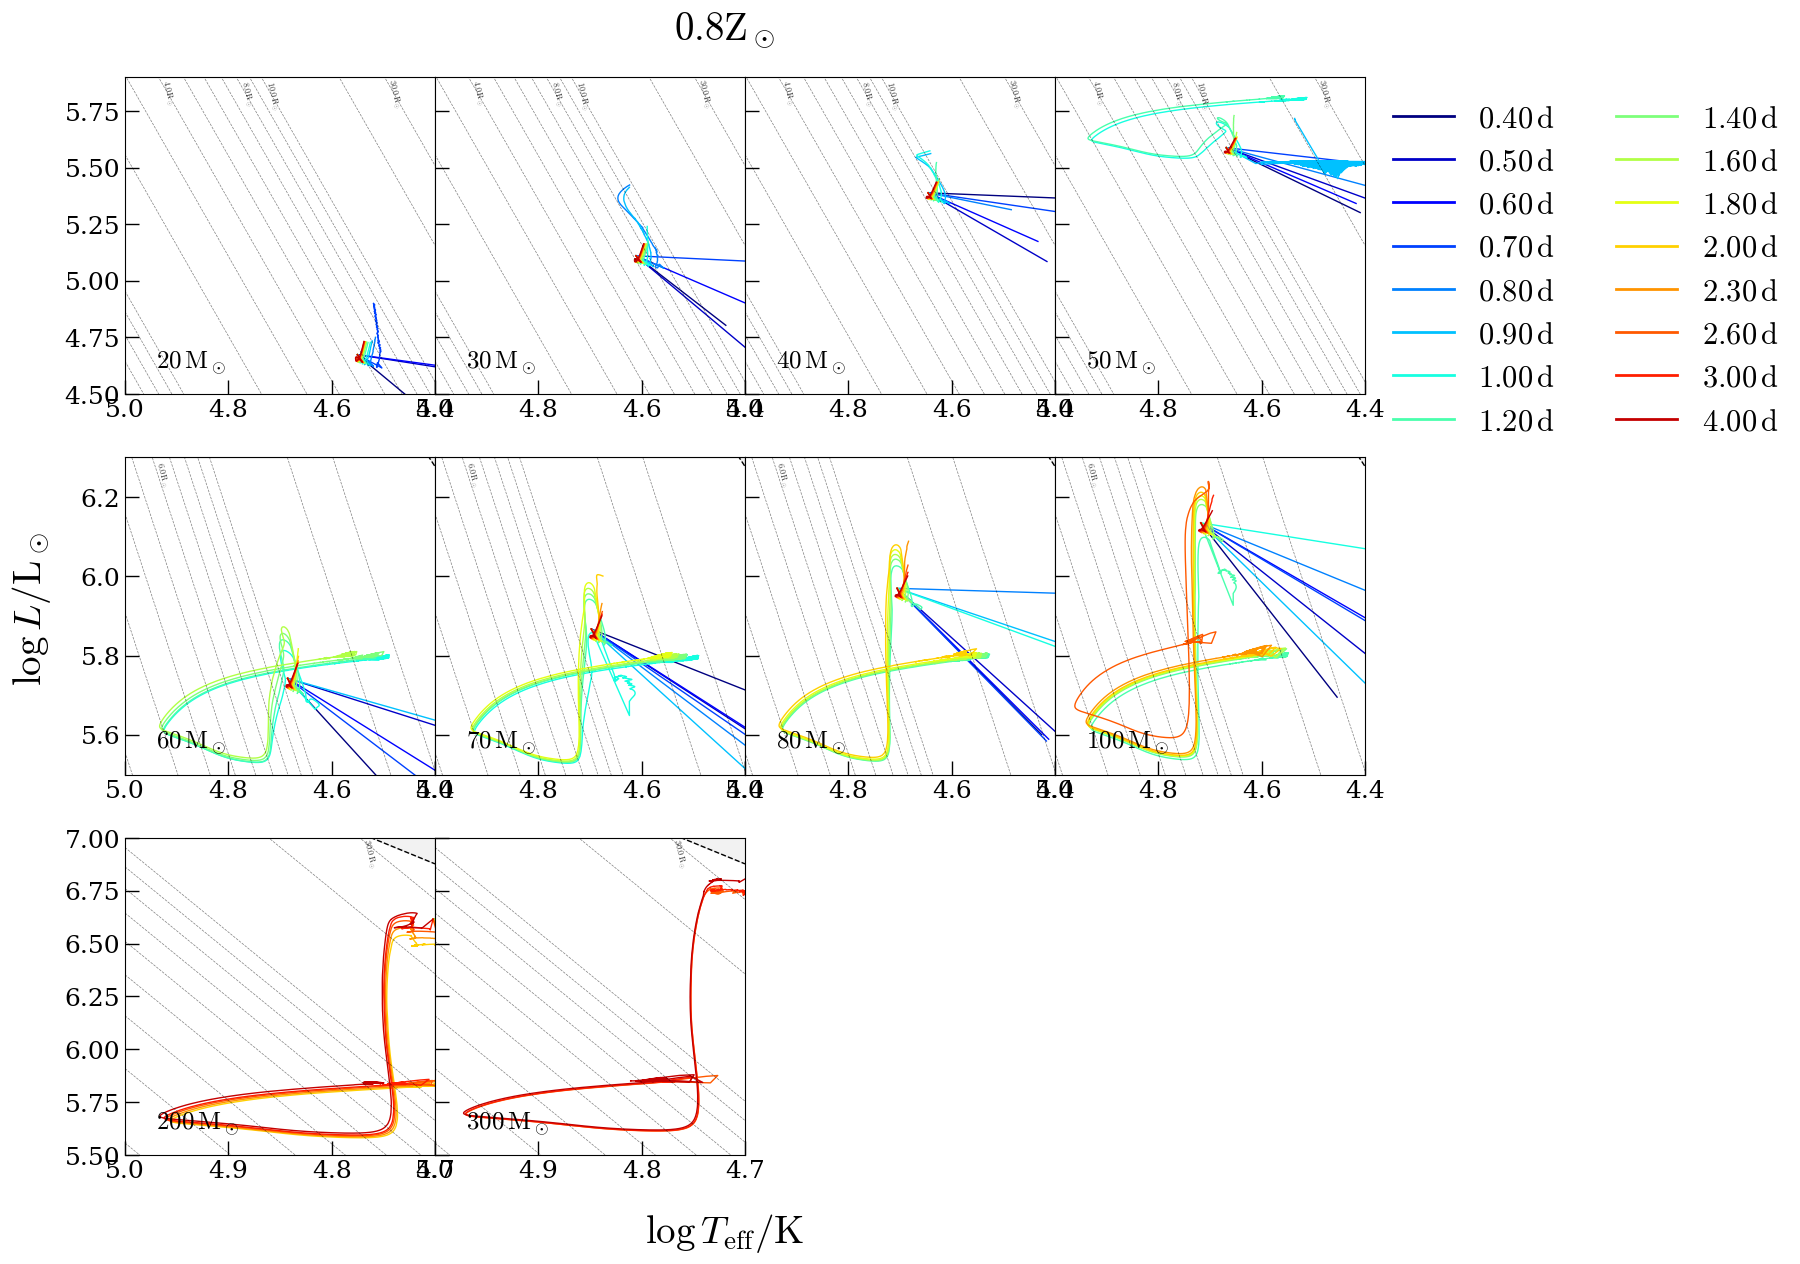

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(16, 14))
fig.subplots_adjust(wspace=0)

model_dicts = model_dicts_08zsun

mass_label_x = 0.1
mass_label_y = 0.1
mass_label_fontsize = 18

xlim = (5, 4.4)
ylim = (4.5, 5.9)

# PLOT M=20
ax = axes[0, 0]
models_to_plot = [0]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.text(mass_label_x, mass_label_y, '$20\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=30
ax = axes[0, 1]
models_to_plot = [1]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$30\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=40
ax = axes[0, 2]
models_to_plot = [2]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$40\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=50
ax = axes[0, 3]
models_to_plot = [3]
model_style_list = ['-']
legend = True
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$50\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

xlim = (5, 4.4)
ylim = (5.5, 6.3)

# PLOT M=60
ax = axes[1, 0]
models_to_plot = [4]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.text(mass_label_x, mass_label_y, '$60\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)



# PLOT M=70
ax = axes[1, 1]
models_to_plot = [5]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$70\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=80
ax = axes[1, 2]
models_to_plot = [6]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$80\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=100
ax = axes[1, 3]
models_to_plot = [7]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$100\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)


xlim = (5, 4.7)
ylim = (5.5, 7.0)

# PLOT M=200
ax = axes[2, 0]
models_to_plot = [8]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.text(mass_label_x, mass_label_y, '$200\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=300
ax = axes[2, 1]
models_to_plot = [9]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$300\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

axes[2, 2].axis('off')
axes[2, 3].axis('off')


#######################################

fig.text(0.5, 0.07, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', va='top', ha='center')
fig.text(0.08, 0.5, '$\\log L/\\mathrm{L}_\\odot$', rotation=90, va='center', ha='right')
fig.text(0.5, 0.9, '$0.8\\mathrm{Z}_\\odot$', va='bottom', ha='center')

savefig(fig, 'hr_allp_mass_comparison_08zsun')

Model /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/05_ZdivZsun_1d0/007_md1_m80_zsundiv10_04y0_03dy/m8.000d+01_p4.000d-01_w1.818d-04 failed to load.
Model /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/05_ZdivZsun_1d0/009_md1_m200_zsundiv10_04y0_03dy/m2.000d+02_p8.000d-01_w9.090d-05 failed to load.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


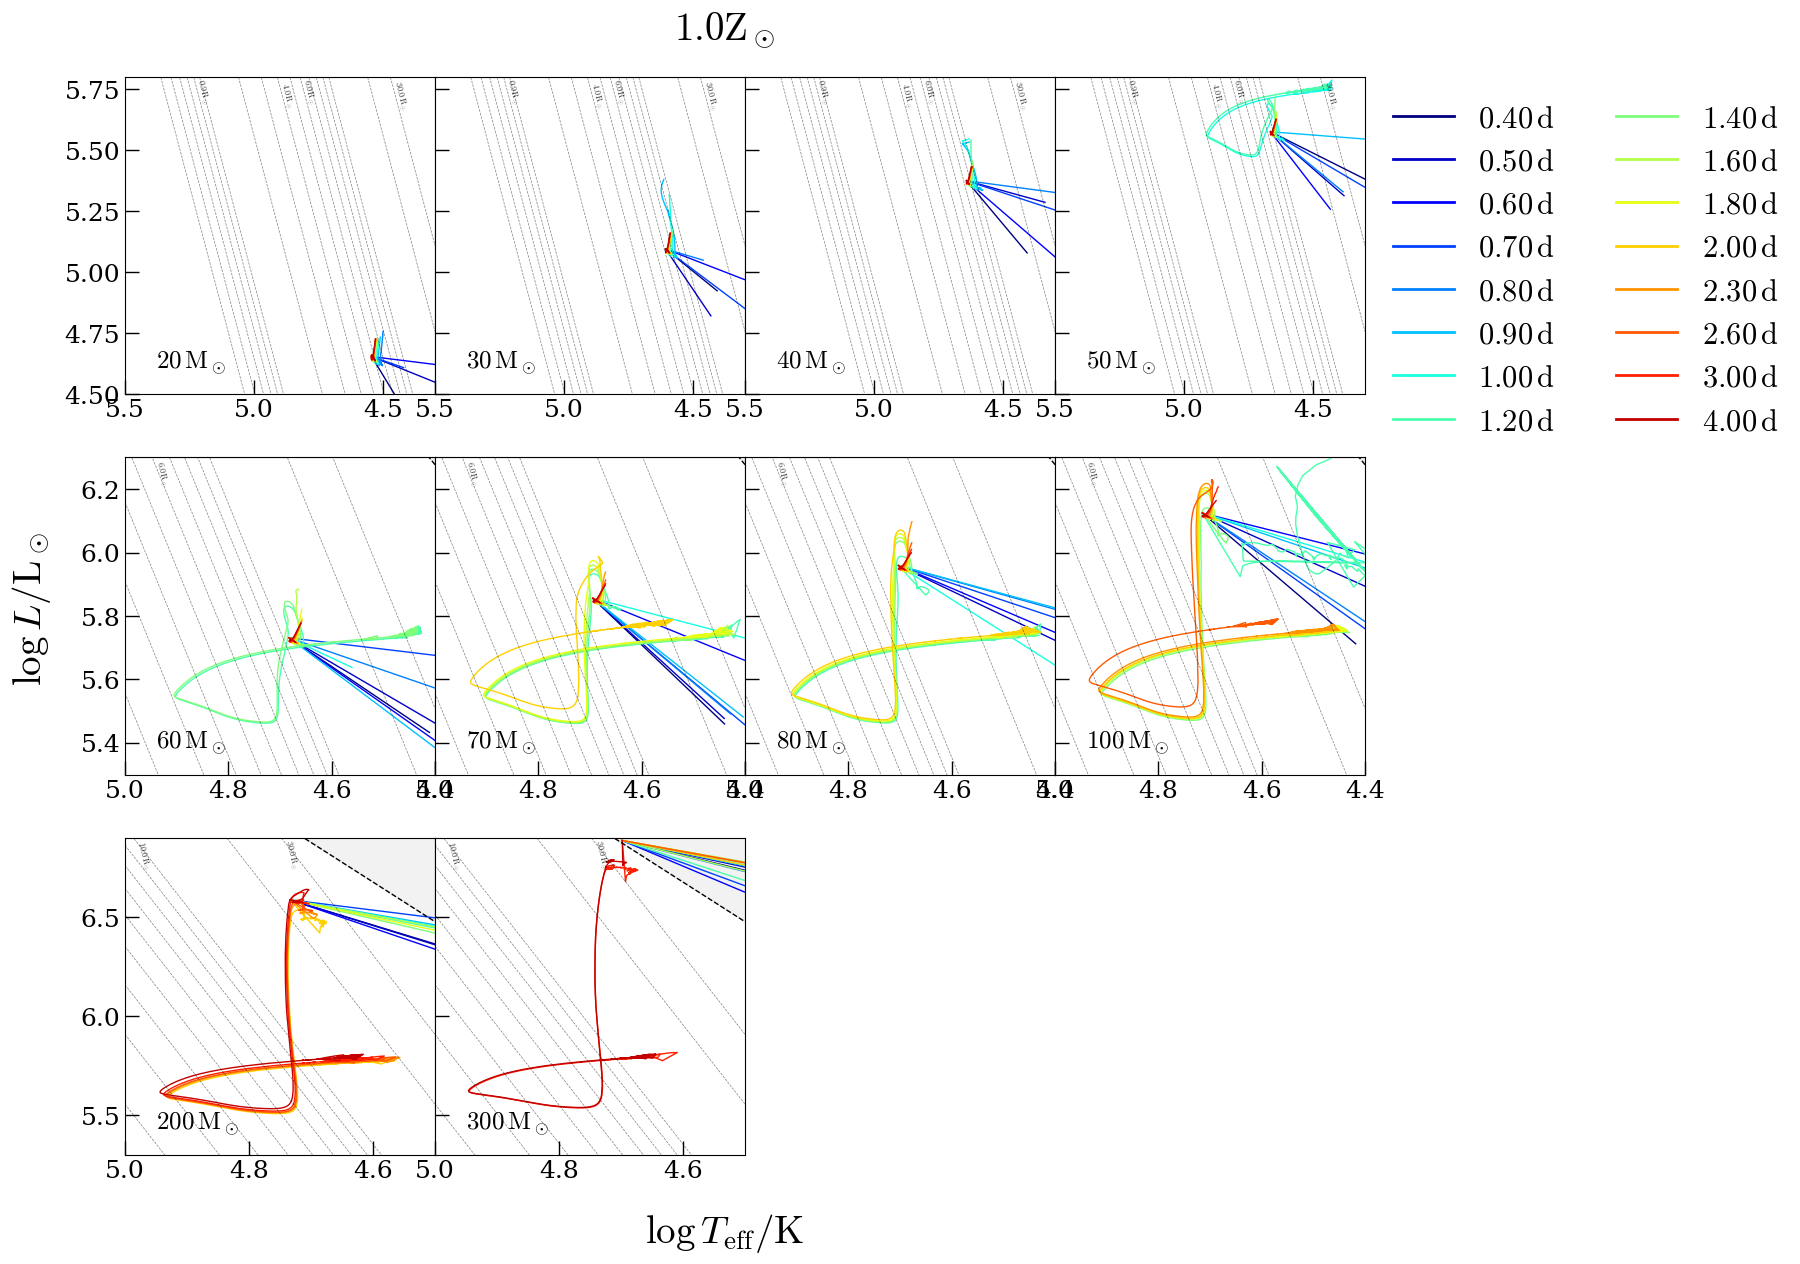

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(16, 14))
fig.subplots_adjust(wspace=0)

model_dicts = model_dicts_10zsun

mass_label_x = 0.1
mass_label_y = 0.1
mass_label_fontsize = 18

xlim = (5.5, 4.3)
ylim = (4.5, 5.8)

# PLOT M=20
ax = axes[0, 0]
models_to_plot = [0]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.text(mass_label_x, mass_label_y, '$20\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=30
ax = axes[0, 1]
models_to_plot = [1]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$30\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=40
ax = axes[0, 2]
models_to_plot = [2]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$40\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=50
ax = axes[0, 3]
models_to_plot = [3]
model_style_list = ['-']
legend = True
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$50\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

xlim = (5.0, 4.4)
ylim = (5.3, 6.3)

# PLOT M=60
ax = axes[1, 0]
models_to_plot = [4]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.text(mass_label_x, mass_label_y, '$60\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)



# PLOT M=70
ax = axes[1, 1]
models_to_plot = [5]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$70\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=80
ax = axes[1, 2]
models_to_plot = [6]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$80\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=100
ax = axes[1, 3]
models_to_plot = [7]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$100\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)


xlim = (5, 4.5)
ylim = (5.3, 6.9)

# PLOT M=200
ax = axes[2, 0]
models_to_plot = [8]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.text(mass_label_x, mass_label_y, '$200\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=300
ax = axes[2, 1]
models_to_plot = [9]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax, handles = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$300\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

axes[2, 2].axis('off')
axes[2, 3].axis('off')


#######################################

fig.text(0.5, 0.07, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', va='top', ha='center')
fig.text(0.08, 0.5, '$\\log L/\\mathrm{L}_\\odot$', rotation=90, va='center', ha='right')
fig.text(0.5, 0.9, '$1.0\\mathrm{Z}_\\odot$', va='bottom', ha='center')

savefig(fig, 'hr_allp_mass_comparison_10zsun')

## Interpolation

In [ ]:
model_dicts = model_dicts_02zsun

In [ ]:
#np.save(f'nb{nb_id}_p_plot_extended.npy', p_plot)
final_mass_array = np.load('01_enhanced_w_core_props.npy')

In [ ]:
# Select models
models_to_plot = np.arange(0, len(model_dicts), 1)
model_dict_list = model_dicts[models_to_plot]
print(f'Loading {model_dict_list}')

# Collect periods
all_periods = []
for dict_ in model_dict_list:
    for k1 in dict_.keys():
        for k2 in dict_[k1].keys():
            all_periods.append(k2)
all_periods = np.unique(all_periods)
all_periods = all_periods[np.argsort([float(p) for p in all_periods])][1:]
print(all_periods)

Loading [{'20.0': {'2.60': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/01_ZdivZsun_2d-1/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_p2.600d+00_w2.797d-05'), '4.00': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/01_ZdivZsun_2d-1/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_p4.000d+00_w1.818d-05'), '0.40': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/01_ZdivZsun_2d-1/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_p4.000d-01_w1.818d-04'), '2.00': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/01_ZdivZsun_2d-1/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_p2.000d+00_w3.636d-05'), '0.70': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/01_ZdivZsun_2d-1/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_p7.000d-01_w1.039d-04'), '1.60': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/01_ZdivZsun_2d-1/001_md1_m20

In [43]:
mass_guide_str = [list(dict_.keys())[0] for dict_ in model_dict_list]
mass_guide_float = np.array([float(m) for m in mass_guide_str])

period_guide_str = all_periods
period_guide_float = np.array([float(p) for p in period_guide_str])

In [44]:
from scipy.interpolate import interp1d

In [45]:
from math import nan

### Core mass plane

In [46]:
stage_index = dict(zams=6, prezams=7)

In [48]:
def mzams_p0_mcore_of_plot(ax, of_when, of_kind, min_mcore=20, max_mcore=50):    
    of_when_i = stage_index[of_when]
    handles = []
    for i, m_key in enumerate(mass_guide_str):
        c = cm.jet(i/len(mass_guide_str))
        handles.append(ax.scatter([], [], c=c, marker='o', label=m_key))
        m_zams = float(m_key)
        
        #che_mask = np.array(final_mass_array[:,i,9], bool)
        pp = period_guide_float#[che_mask]
        mm = final_mass_array[:,i,0]#[che_mask]
        rr = final_mass_array[:,i,of_when_i]#[che_mask]
        is_che = np.array(final_mass_array[:,i,9], bool)
        is_crit = np.array(final_mass_array[:,i,8], bool)
        
        for p, r, m_core, ische, iscrit in zip(pp, rr, mm, is_che, is_crit):
            if iscrit:
                marker = 'x'
                color = 'k'
            elif not ische:
                marker = '+'
                color = 'k'
            else:
                marker = 'o'
                color = cm.jet_r((np.log10(m_core)-np.log10(min_mcore))/(np.log10(max_mcore)-np.log10(min_mcore)))
            isof = is_of(r, m_zams, p, 1, kind=of_kind)
            if isof:
                alpha = 0.3
            else:
                alpha = 1.0
            ax.scatter(m_zams, p, marker=marker, color=color, zorder=1, s=30, alpha=alpha)
    return ax, handles

In [49]:
def p0_mcore_mzams_of_plot(ax, of_when, of_kind):
    of_when_i = stage_index[of_when]
    handles = []
    for i, m_key in enumerate(mass_guide_str):
        c = cm.jet(i/len(mass_guide_str))
        handles.append(ax.scatter([], [], c=c, marker='o', label=m_key))
        m_zams = float(m_key)
        
        che_mask = np.array(final_mass_array[:,i,9], bool)
        pp = period_guide_float[che_mask]
        mm = final_mass_array[:,i,3][che_mask]
        rr = final_mass_array[:,i,of_when_i][che_mask]
            
        for p, r, m_core in zip(pp, rr, mm):
            isof = is_of(r, m_zams, p, 1, kind=of_kind)
            if isof:
                ax.scatter(p, m_core, marker='x', color=c, zorder=1, s=30, alpha=0.3)
                pass
            else:
                ax.scatter(p, m_core, marker='o', color=c, zorder=1, s=30)
    return ax, handles

In [51]:
def is_of(r, m, p, q=1, kind='RL'):
    a = a_from_p(p, m, q)
    if kind == 'merger':
        of_a = a.to(u.Rsun).value
    elif kind == 'RL':
        of_a = eggleton_rl1_radius(a, q).to(u.Rsun).value
    elif kind == 'L2':
        of_a = marchant_l2_radius(a, q).to(u.Rsun).value
    elif kind == 'none':
        of_a = np.inf
    else:
        raise ValueError(f'kind {kind} not recognized')
    if of_a <= r:
        isof = True
    else:
        isof = False

    return isof

/tmp/ipykernel_2123654/3389247599.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handles.append(ax.scatter([], [], c=c, marker='o', label=m_key))


Text(1, 0.5, 'Before ZAMS')

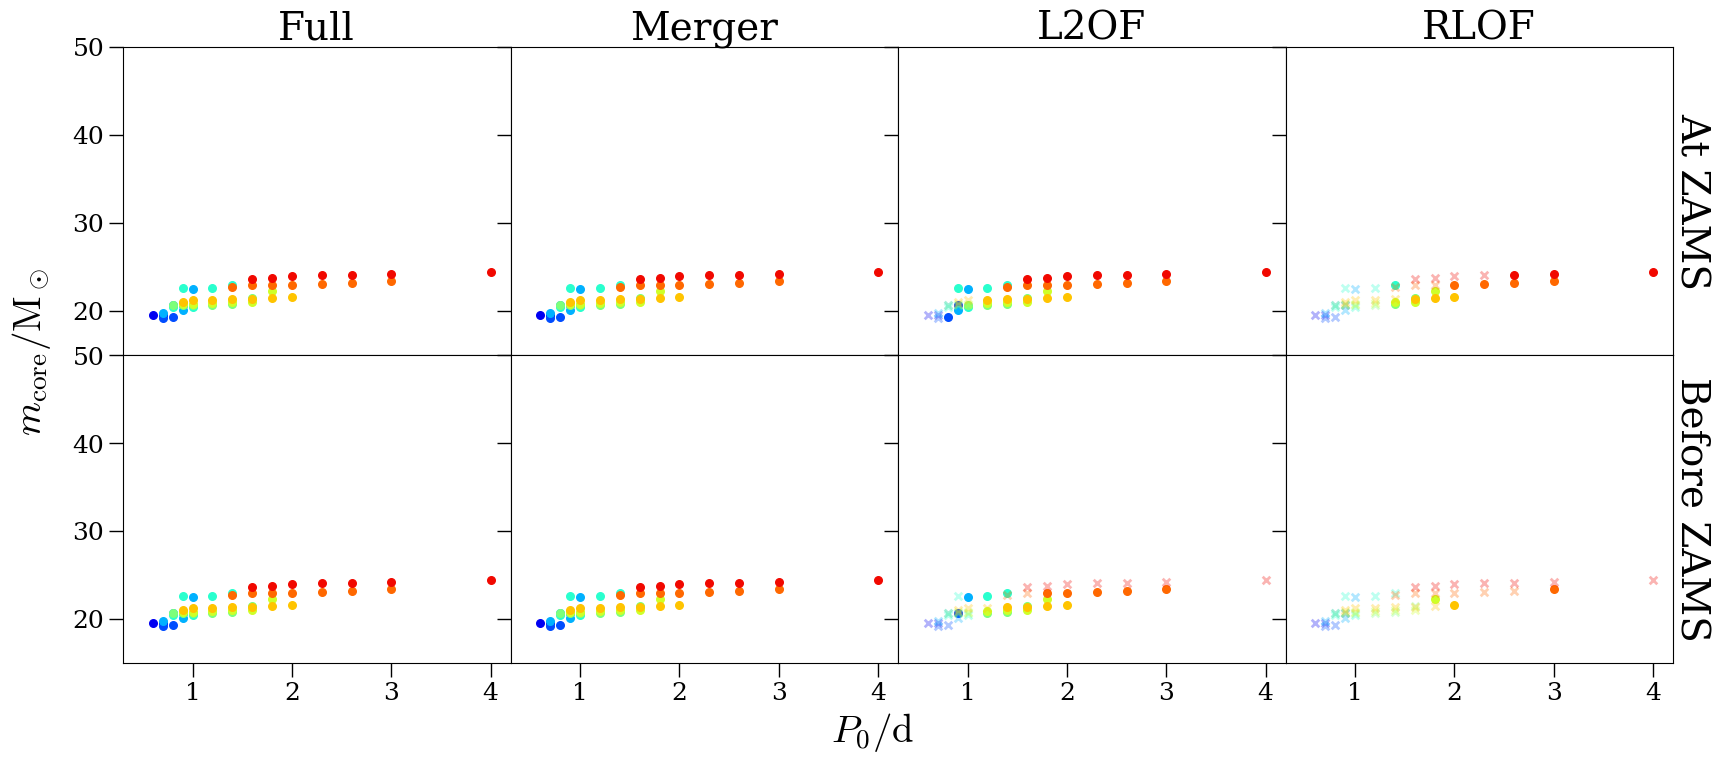

In [52]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)
plot_ps = np.linspace(0, 4, 100)

# AT ZAMS
of_when = 'zams'

of_kind = 'none'
ax = axes[0, 0]
ax, handles = p0_mcore_mzams_of_plot(ax, of_when=of_when, of_kind=of_kind)
ax.set_title('Full')                

of_kind = 'merger'
ax = axes[0, 1]
ax, handles = p0_mcore_mzams_of_plot(ax, of_when=of_when, of_kind=of_kind)
ax.set_title('Merger')                

of_kind = 'L2'
ax = axes[0, 2]
ax, handles = p0_mcore_mzams_of_plot(ax, of_when=of_when, of_kind=of_kind)
ax.set_title('L2OF')                

of_kind = 'RL'
ax = axes[0, 3]
ax, handles = p0_mcore_mzams_of_plot(ax, of_when=of_when, of_kind=of_kind)
ax.set_title('RLOF')                

# AT ZAMS
of_when = 'prezams'

of_kind = 'none'
ax = axes[1, 0]
ax, handles = p0_mcore_mzams_of_plot(ax, of_when=of_when, of_kind=of_kind)

of_kind = 'merger'
ax = axes[1, 1]
ax, handles = p0_mcore_mzams_of_plot(ax, of_when=of_when, of_kind=of_kind)

of_kind = 'L2'
ax = axes[1, 2]
ax, handles = p0_mcore_mzams_of_plot(ax, of_when=of_when, of_kind=of_kind)

of_kind = 'RL'
ax = axes[1, 3]
ax, handles = p0_mcore_mzams_of_plot(ax, of_when=of_when, of_kind=of_kind)
           
ax.set_ylim(15, 50)
ax.set_xlim(0.3, 4.2)

fig.text(0.09, 0.5, '$m_\\mathrm{core}/\\mathrm{M}_\\odot$', rotation=90, ha='right', va='center')
fig.text(0.5, 0.05, '$P_0/\\mathrm{d}$', ha='center', va='top')
axes[0, 3].text(1, 0.5, 'At ZAMS', rotation=-90, ha='left', va='center', transform=axes[0, 3].transAxes)
axes[1, 3].text(1, 0.5, 'Before ZAMS', rotation=-90, ha='left', va='center', transform=axes[1, 3].transAxes)

#ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=2, title='$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')


#savefig(fig, 'pzams_mcore_data')

/tmp/ipykernel_2123654/3389247599.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handles.append(ax.scatter([], [], c=c, marker='o', label=m_key))


Text(1, 0.5, 'Before ZAMS')

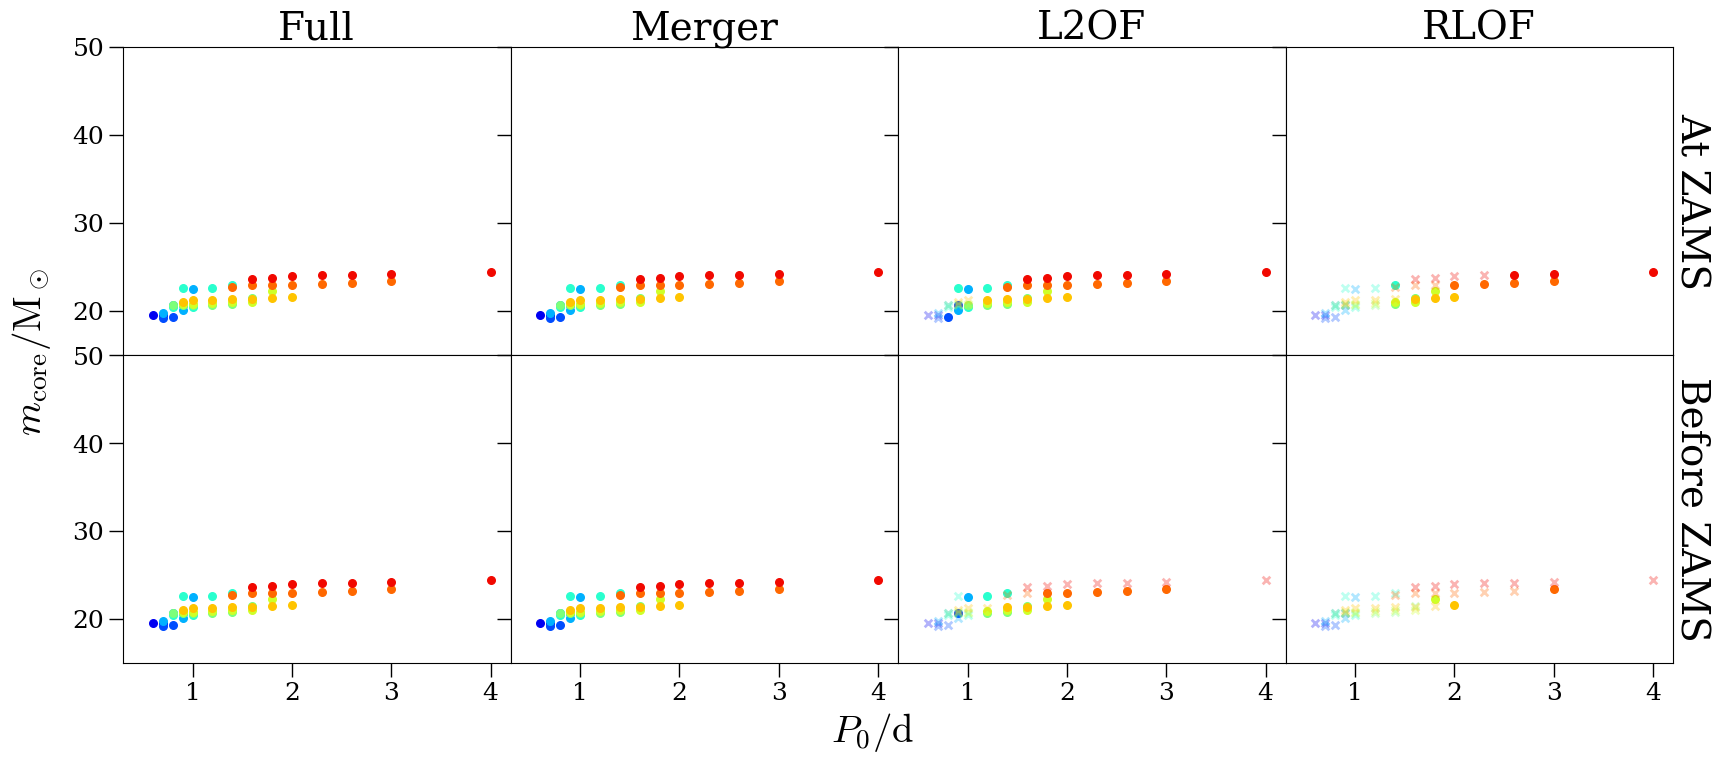

In [53]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)
plot_ps = np.linspace(0, 4, 100)

# AT ZAMS
of_when = 'zams'

of_kind = 'none'
ax = axes[0, 0]
ax, handles = p0_mcore_mzams_of_plot(ax, of_when=of_when, of_kind=of_kind)
ax.set_title('Full')                

of_kind = 'merger'
ax = axes[0, 1]
ax, handles = p0_mcore_mzams_of_plot(ax, of_when=of_when, of_kind=of_kind)
ax.set_title('Merger')                

of_kind = 'L2'
ax = axes[0, 2]
ax, handles = p0_mcore_mzams_of_plot(ax, of_when=of_when, of_kind=of_kind)
ax.set_title('L2OF')                

of_kind = 'RL'
ax = axes[0, 3]
ax, handles = p0_mcore_mzams_of_plot(ax, of_when=of_when, of_kind=of_kind)
ax.set_title('RLOF')                

# AT ZAMS
of_when = 'prezams'

of_kind = 'none'
ax = axes[1, 0]
ax, handles = p0_mcore_mzams_of_plot(ax, of_when=of_when, of_kind=of_kind)

of_kind = 'merger'
ax = axes[1, 1]
ax, handles = p0_mcore_mzams_of_plot(ax, of_when=of_when, of_kind=of_kind)

of_kind = 'L2'
ax = axes[1, 2]
ax, handles = p0_mcore_mzams_of_plot(ax, of_when=of_when, of_kind=of_kind)

of_kind = 'RL'
ax = axes[1, 3]
ax, handles = p0_mcore_mzams_of_plot(ax, of_when=of_when, of_kind=of_kind)
           
ax.set_ylim(15, 50)
ax.set_xlim(0.3, 4.2)

fig.text(0.09, 0.5, '$m_\\mathrm{core}/\\mathrm{M}_\\odot$', rotation=90, ha='right', va='center')
fig.text(0.5, 0.05, '$P_0/\\mathrm{d}$', ha='center', va='top')
axes[0, 3].text(1, 0.5, 'At ZAMS', rotation=-90, ha='left', va='center', transform=axes[0, 3].transAxes)
axes[1, 3].text(1, 0.5, 'Before ZAMS', rotation=-90, ha='left', va='center', transform=axes[1, 3].transAxes)

#ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=2, title='$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')


#savefig(fig, 'pzams_mcore_data')

/tmp/ipykernel_2123654/2509275481.py:2: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0, hspace=0)
/tmp/ipykernel_2123654/3646536049.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handles.append(ax.scatter([], [], c=c, marker='o', label=m_key))
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


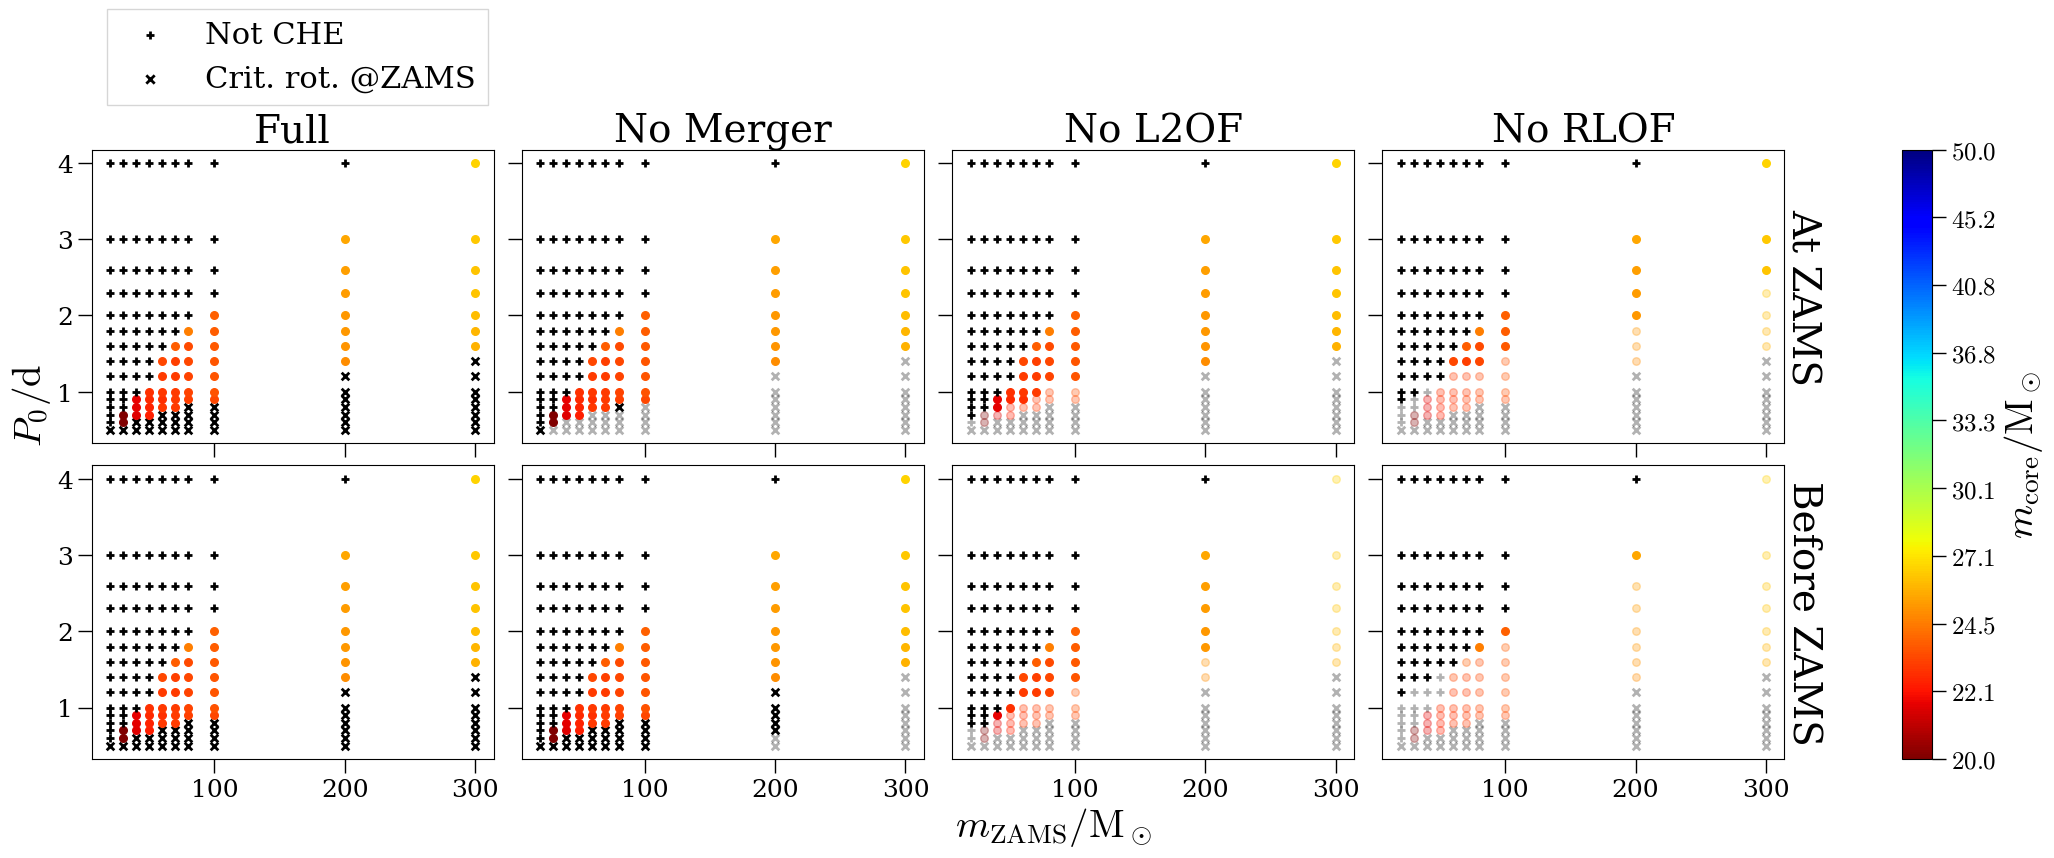

In [54]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey=True, layout='constrained')
fig.subplots_adjust(wspace=0, hspace=0)

plot_ps = np.linspace(0, 4, 100)

min_mcore = 20
max_mcore = 50

# AT ZAMS
of_when = 'zams'

of_kind = 'none'
ax = axes[0, 0]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)
ax.set_title('Full')                

of_kind = 'merger'
ax = axes[0, 1]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)
ax.set_title('No Merger')                

of_kind = 'L2'
ax = axes[0, 2]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)
ax.set_title('No L2OF')                

of_kind = 'RL'
ax = axes[0, 3]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)
ax.set_title('No RLOF')                

# AT ZAMS
of_when = 'prezams'

of_kind = 'none'
ax = axes[1, 0]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)

of_kind = 'merger'
ax = axes[1, 1]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)  

of_kind = 'L2'
ax = axes[1, 2]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)
             
of_kind = 'RL'
ax = axes[1, 3]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)
           
fig.text(0, 0.5, '$P_0/\\mathrm{d}$', rotation=90, ha='right', va='center')
fig.text(0.5, 0, '$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$', ha='center', va='top')
axes[0, 3].text(1, 0.5, 'At ZAMS', rotation=-90, ha='left', va='center', transform=axes[0, 3].transAxes)
axes[1, 3].text(1, 0.5, 'Before ZAMS', rotation=-90, ha='left', va='center', transform=axes[1, 3].transAxes)

sm = ScalarMappable(Normalize(vmin=np.log10(min_mcore), vmax=np.log10(max_mcore)), cm.jet_r)
cbar = fig.colorbar(sm, ax=axes[:,3], pad=0.2)
cbar.set_label('$m_\\mathrm{core}/\\mathrm{M}_\\odot$')
cbar.set_ticks(np.linspace(np.log10(min_mcore), np.log10(max_mcore), 10))
cbar.set_ticklabels([f'${10**logm:.1f}$' for logm in np.linspace(np.log10(min_mcore), np.log10(max_mcore), 10)])

handles = []
handles.append(ax.scatter([], [], marker='+', color='k', label='Not CHE'))
handles.append(ax.scatter([], [], marker='x', color='k', label='Crit. rot. @ZAMS'))
axes[0,0].legend(handles=handles, fancybox=False, loc='lower left', bbox_to_anchor=(0, 1.1))

savefig(fig, 'che_window')

## Scaled grid plot

In [77]:
min_mcore = final_mass_array[:, :, 0][np.array(final_mass_array[:, :, 9], bool)].min()
max_mcore = final_mass_array[:, :, 0][np.array(final_mass_array[:, :, 9], bool)].max()
mcore_norm = TwoSlopeNorm(vmin=min_mcore, vmax=max_mcore, vcenter=15.)
nonche_c = to_rgba('darkslategrey')
crit_c = to_rgba('slategrey')
cmap = cm.seismic
def mcore_cmap(x): return cmap(mcore_norm(x))

ValueError: vmin, vcenter, and vmax must be in ascending order

In [78]:
m_arr = np.zeros(len(mass_guide_float)+1)
p_arr = np.zeros(len(period_guide_float)+1)
mcore_arr = np.zeros((len(mass_guide_float), len(period_guide_float), 4))
zams_l2of_arr = np.zeros((len(mass_guide_float), len(period_guide_float), 4))

for i_m, m1 in enumerate(mass_guide_float):
    if i_m == 0:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        bin_lower_m = m1 - (bin_upper_m-m1)
    elif i_m < len(mass_guide_float)-1:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
    else:
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
        bin_upper_m = m1 + (m1-bin_lower_m)
    m_arr[i_m] = bin_lower_m
    m_arr[i_m+1] = bin_upper_m
    
    for i_p, p1 in enumerate(period_guide_float):
        if i_p == 0:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = p1 - (bin_upper_p-p1)
        elif i_p < len(period_guide_float)-1:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (p0+p1)/2
        else:
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (p0+p1)/2
            m2 = m1 + (m1-bin_lower_p)
        p_arr[i_p] = p0
        p_arr[i_p+1] = p2
        
        mcore = final_mass_array[i_p, i_m, 0]
        ische = final_mass_array[i_p, i_m, 9]
        iscrit = final_mass_array[i_p, i_m, 8]
        if ische:
            mcore_arr[i_m, i_p, :] = mcore_cmap(mcore_norm(mcore))
        elif iscrit: 
            mcore_arr[i_m, i_p, :] = crit_c
        else:
            mcore_arr[i_m, i_p, :] = nonche_c

        rzams = final_mass_array[i_p, i_m, 6]
        is_l2of = is_of(r=rzams, m=m1, p=p1, q=1, kind='L2')
        if is_l2of:
            zams_l2of_arr[i_m, i_p, :] = [0, 0, 0, 0]
        else:
            zams_l2of_arr[i_m, i_p, :] = 4*[nan]
            
m_arr = np.tile(m_arr, [len(period_guide_float)+1, 1]).T
p_arr = np.tile(p_arr, [len(mass_guide_float)+1, 1])

color_mcore_arr = mcore_arr
color_m_arr = m_arr
color_p_arr = p_arr

In [79]:
m_arr = np.zeros(len(mass_guide_float)+1)
p_arr = np.zeros(len(period_guide_float)+1)
mcore_arr = np.zeros((len(mass_guide_float), len(period_guide_float), 4))
che_mask = np.ones((len(mass_guide_float)+1, len(period_guide_float)+1), bool)

for i_m, m1 in enumerate(mass_guide_float):
    if i_m == 0:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        bin_lower_m = m1 - (bin_upper_m-m1)
    elif i_m < len(mass_guide_float)-1:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
    else:
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
        bin_upper_m = m1 + (m1-bin_lower_m)
    m_arr[i_m] = bin_lower_m
    m_arr[i_m+1] = bin_upper_m
    
    for i_p, p1 in enumerate(period_guide_float):
        if i_p == 0:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = p1 - (bin_upper_p-p1)
        elif i_p < len(period_guide_float)-1:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (p0+p1)/2
        else:
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (m0+m1)/2
            m2 = m1 + (m1-bin_lower_p)
        p_arr[i_p] = p0
        p_arr[i_p+1] = p2
        
        mcore = final_mass_array[i_p, i_m, 0]
        ische = final_mass_array[i_p, i_m, 9]
        iscrit = final_mass_array[i_p, i_m, 8]
        if ische:
            mcore_arr[i_m, i_p, :] = 4*[nan]
            che_mask[i_m, i_p] = True
        elif iscrit: 
            mcore_arr[i_m, i_p, :] = crit_c
            che_mask[i_m, i_p] = False
        else:
            mcore_arr[i_m, i_p, :] = 4*[nan]
            che_mask[i_m, i_p] = False
            
m_arr = np.tile(m_arr, [len(period_guide_float)+1, 1]).T
p_arr = np.tile(p_arr, [len(mass_guide_float)+1, 1])

hatch_crit_mcore_arr = mcore_arr
hatch_crit_m_arr = m_arr
hatch_crit_p_arr = p_arr

In [80]:
m_arr = np.zeros(len(mass_guide_float)+1)
p_arr = np.zeros(len(period_guide_float)+1)
mcore_arr = np.zeros((len(mass_guide_float), len(period_guide_float), 4))
che_mask = np.ones((len(mass_guide_float)+1, len(period_guide_float)+1), bool)

for i_m, m1 in enumerate(mass_guide_float):
    if i_m == 0:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        bin_lower_m = m1 - (bin_upper_m-m1)
    elif i_m < len(mass_guide_float)-1:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
    else:
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
        bin_upper_m = m1 + (m1-bin_lower_m)
    m_arr[i_m] = bin_lower_m
    m_arr[i_m+1] = bin_upper_m
    
    for i_p, p1 in enumerate(period_guide_float):
        if i_p == 0:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = p1 - (bin_upper_p-p1)
        elif i_p < len(period_guide_float)-1:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (p0+p1)/2
        else:
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (m0+m1)/2
            m2 = m1 + (m1-bin_lower_p)
        p_arr[i_p] = p0
        p_arr[i_p+1] = p2
        
        mcore = final_mass_array[i_p, i_m, 0]
        ische = final_mass_array[i_p, i_m, 9]
        iscrit = final_mass_array[i_p, i_m, 8]
        if ische:
            mcore_arr[i_m, i_p, :] = 4*[nan]
            che_mask[i_m, i_p] = True
        elif iscrit: 
            mcore_arr[i_m, i_p, :] = 4*[nan]
            che_mask[i_m, i_p] = False
        else:
            mcore_arr[i_m, i_p, :] = nonche_c
            che_mask[i_m, i_p] = False
            
m_arr = np.tile(m_arr, [len(period_guide_float)+1, 1]).T
p_arr = np.tile(p_arr, [len(mass_guide_float)+1, 1])

hatch_nonche_mcore_arr = mcore_arr
hatch_nonche_m_arr = m_arr
hatch_nonche_p_arr = p_arr

#### Unscaled version

In [81]:
nonche_hatch = '\\'
crit_hatch = '/'
l2of_hatch = 'o'

In [82]:
from matplotlib.patches import Patch

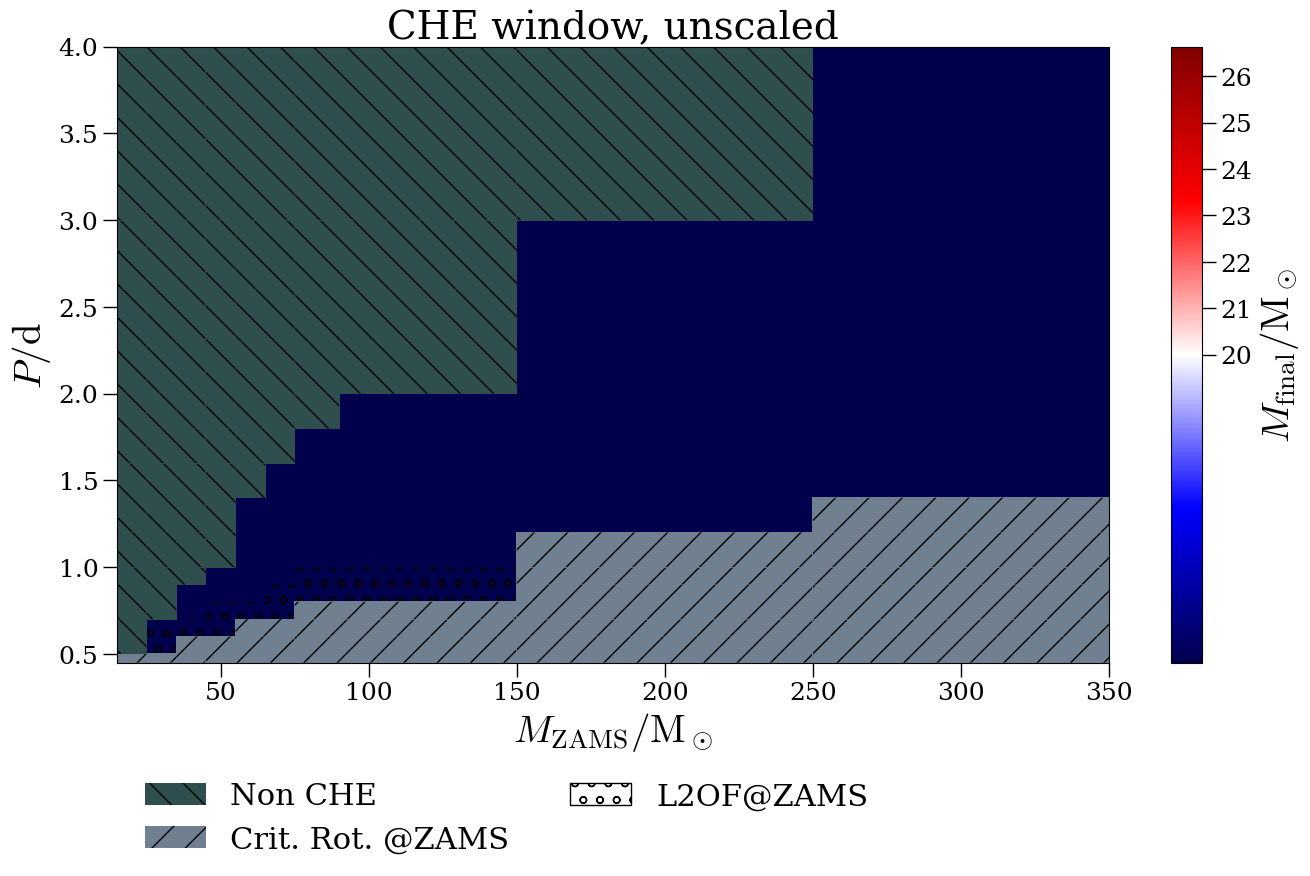

In [83]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.pcolormesh(color_m_arr, color_p_arr, color_mcore_arr, shading='flat')
ax.pcolor(color_m_arr, color_p_arr, zams_l2of_arr, hatch=l2of_hatch)
ax.pcolor(hatch_crit_m_arr, hatch_crit_p_arr, hatch_crit_mcore_arr, alpha=0., hatch=crit_hatch)
ax.pcolor(hatch_nonche_m_arr, hatch_nonche_p_arr, hatch_nonche_mcore_arr, alpha=0., hatch=nonche_hatch)

ax.set_xlabel('$M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
ax.set_ylabel('$P/\\mathrm{d}$')

sm = ScalarMappable(norm=mcore_norm, cmap=cmap)
cb = fig.colorbar(sm, ax=ax)
cb.set_label('$M_\\mathrm{final}/\\mathrm{M}_\\odot$')

handles = []
handles.append(Patch(facecolor=nonche_c, hatch=nonche_hatch, label='Non CHE'))
handles.append(Patch(facecolor=crit_c, hatch=crit_hatch, label='Crit. Rot. @ZAMS'))
handles.append(Patch(facecolor='w', hatch=l2of_hatch, label='L2OF@ZAMS', edgecolor='k'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(0, -0.15), ncol=2)

ax.set_title('CHE window, unscaled')

savefig(fig, 'che_window_unscaled')

#### Scaled version

To get a better grasp on how populated the CHE window, we would like to re-scale the plot axes by appropriate probability distributions. For the mass (x) axis, we use a Salpeter IMF,

In [84]:
def mass_forward(m):
    return m**-2.35

def mass_inverse(m):
    return m**(-1/2.35)

For the orbital period (y) axis, we assume a log-uniform ditribution,

/tmp/ipykernel_2123654/1587637377.py:2: RuntimeWarning: divide by zero encountered in power
  return m**-2.35
/tmp/ipykernel_2123654/1587637377.py:2: RuntimeWarning: divide by zero encountered in power
  return m**-2.35


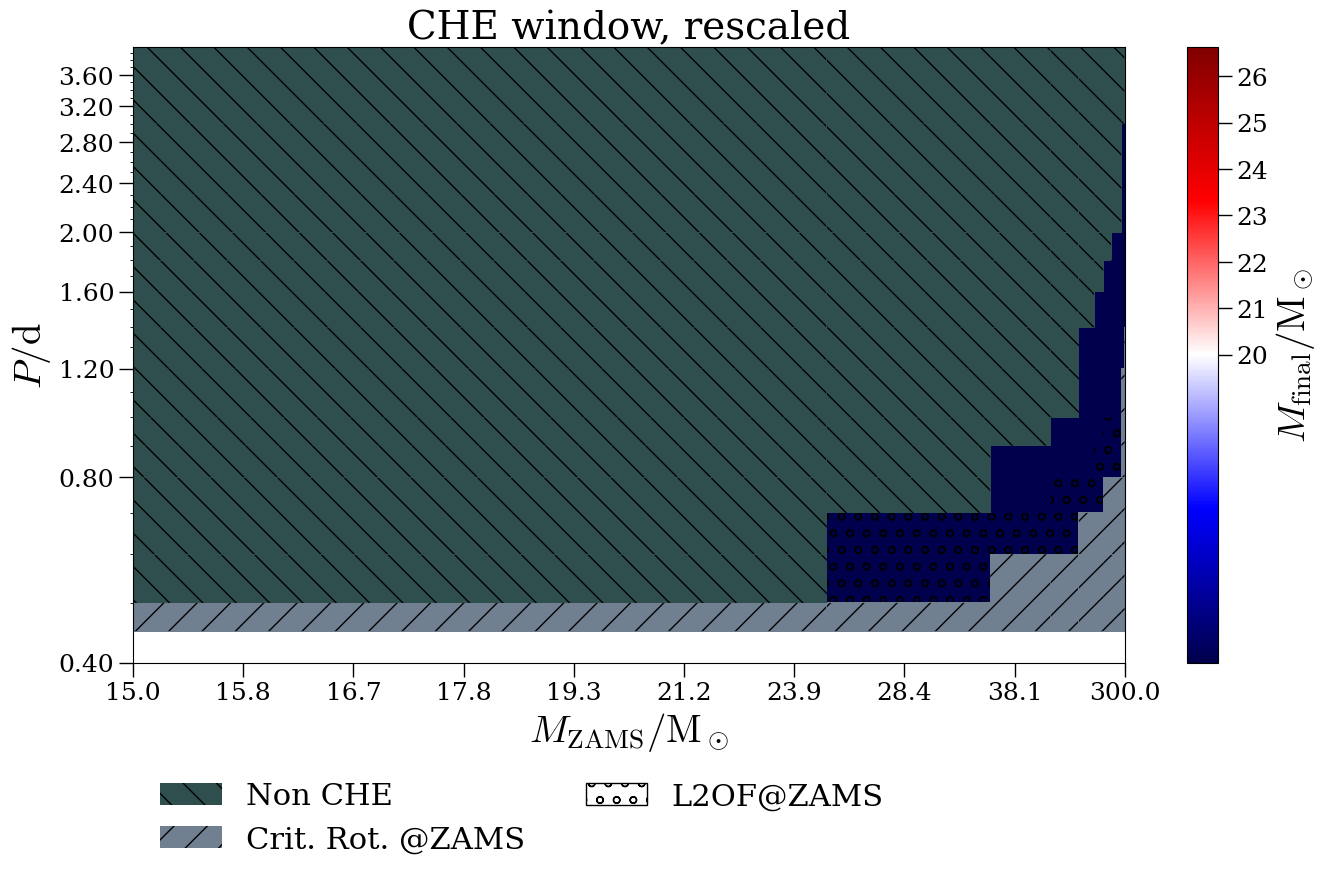

In [86]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.pcolormesh(color_m_arr, color_p_arr, color_mcore_arr, shading='flat')
ax.pcolor(color_m_arr, color_p_arr, zams_l2of_arr, hatch=l2of_hatch)
ax.pcolor(hatch_crit_m_arr, hatch_crit_p_arr, hatch_crit_mcore_arr, alpha=0., hatch=crit_hatch)
ax.pcolor(hatch_nonche_m_arr, hatch_nonche_p_arr, hatch_nonche_mcore_arr, alpha=0., hatch=nonche_hatch)

ax.set_xlabel('$M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
ax.set_ylabel('$P/\\mathrm{d}$')

sm = ScalarMappable(norm=mcore_norm, cmap=cmap)
cb = fig.colorbar(sm, ax=ax)
cb.set_label('$M_\\mathrm{final}/\\mathrm{M}_\\odot$')

handles = []
handles.append(Patch(facecolor=nonche_c, hatch=nonche_hatch, label='Non CHE'))
handles.append(Patch(facecolor=crit_c, hatch=crit_hatch, label='Crit. Rot. @ZAMS'))
handles.append(Patch(facecolor='w', hatch=l2of_hatch, label='L2OF@ZAMS', edgecolor='k'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(0, -0.15), ncol=2)

ax.set_yscale('log')
ax.set_xscale('function', functions=(mass_forward, mass_inverse))
ax.set_xticks([mass_inverse(x) for x in np.linspace(mass_forward(15), mass_forward(300), 10)])

ax.set_xlim(15, 310)
ax.invert_xaxis()

ax.set_yticks(np.arange(0.4, 4, 0.4))
ax.set_yticklabels([f'{p:.2f}' for p in np.arange(0.4, 4, 0.4)])
ax.set_yticks(np.arange(0.4, 4, 0.1), minor=True)
ax.set_yticklabels([], minor=True)

ax.set_title('CHE window, rescaled')

savefig(fig, 'che_window_rescaled')

/tmp/ipykernel_2123654/1587637377.py:2: RuntimeWarning: divide by zero encountered in power
  return m**-2.35
/tmp/ipykernel_2123654/1587637377.py:2: RuntimeWarning: divide by zero encountered in power
  return m**-2.35


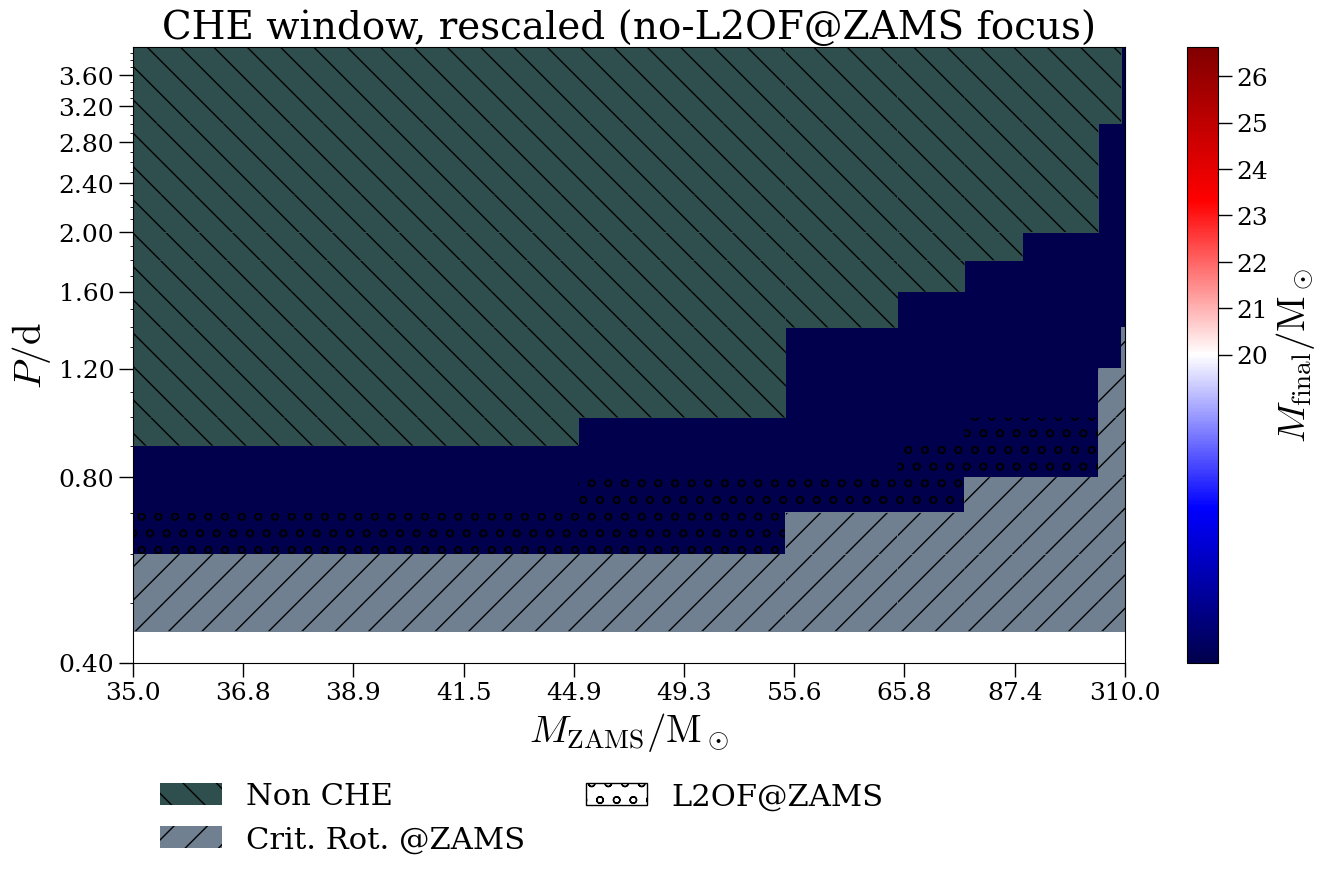

In [88]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.pcolormesh(color_m_arr, color_p_arr, color_mcore_arr, shading='flat')
ax.pcolor(color_m_arr, color_p_arr, zams_l2of_arr, hatch=l2of_hatch)
ax.pcolor(hatch_crit_m_arr, hatch_crit_p_arr, hatch_crit_mcore_arr, alpha=0., hatch=crit_hatch)
ax.pcolor(hatch_nonche_m_arr, hatch_nonche_p_arr, hatch_nonche_mcore_arr, alpha=0., hatch=nonche_hatch)

ax.set_xlabel('$M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
ax.set_ylabel('$P/\\mathrm{d}$')

sm = ScalarMappable(norm=mcore_norm, cmap=cmap)
cb = fig.colorbar(sm, ax=ax)
cb.set_label('$M_\\mathrm{final}/\\mathrm{M}_\\odot$')

handles = []
handles.append(Patch(facecolor=nonche_c, hatch=nonche_hatch, label='Non CHE'))
handles.append(Patch(facecolor=crit_c, hatch=crit_hatch, label='Crit. Rot. @ZAMS'))
handles.append(Patch(facecolor='w', hatch=l2of_hatch, label='L2OF@ZAMS', edgecolor='k'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(0, -0.15), ncol=2)

ax.set_yscale('log')
ax.set_xscale('function', functions=(mass_forward, mass_inverse))
ax.set_xticks([mass_inverse(x) for x in np.linspace(mass_forward(35), mass_forward(310), 10)])

ax.set_xlim(35, 310)
ax.invert_xaxis()

ax.set_yticks(np.arange(0.4, 4, 0.4))
ax.set_yticklabels([f'{p:.2f}' for p in np.arange(0.4, 4, 0.4)])
ax.set_yticks(np.arange(0.4, 4, 0.1), minor=True)
ax.set_yticklabels([], minor=True)

ax.set_title('CHE window, rescaled (no-L2OF@ZAMS focus)')

savefig(fig, 'che_window_rescaled_no_l2of')

The thin strip of $~25

## Interpolators

In [89]:
interpolator_dict = dict()

for i, m in enumerate(mass_guide_float):
    m_key = mass_guide_str[i]
    p_arr = period_guide_float   
    y_arr = final_mass_array[:, i, 0] 
    r_arr = final_mass_array[:, i, 6] 

    mask = np.array(final_mass_array[:, i, 9], bool)
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]
    r_arr = r_arr[mask]
            
    if m_key in ['50.0']:
        y_arr = y_arr[1:]
        p_arr = p_arr[1:]
        r_arr = r_arr[1:]
        
    if m_key in ['40.0', '220.0']:
        y_arr = y_arr[:-1]
        p_arr = p_arr[:-1]
        r_arr = r_arr[:-1]
        
    mask = []
    for p0, rzams in zip(p_arr, r_arr):
        isof = is_of(rzams, float(m_key), p0, 1, kind='L2')
        if isof:
            mask.append(False)
        else:
            mask.append(True)
            
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]
    r_arr = r_arr[mask]
    
    if len(y_arr) == 0:
        y_arr = [nan]
        p_arr = [1]
        r_arr = [1]
    
    interpolator = interp1d(
        x=p_arr,
        y=y_arr,
        kind='linear',
        bounds_error=False,
        fill_value=nan
        )

    interpolator_dict[m_key] = interpolator     
    
l2_pzams_mcore_interpolator_dict = interpolator_dict

/tmp/ipykernel_2123654/920947829.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(period_guide_float[che_mask], final_mass_array[:,i,0][che_mask], marker='o', c=c, zorder=1, label=m_key, s=20, alpha=0.5)
/tmp/ipykernel_2123654/920947829.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(period_guide_float[~che_mask], final_mass_array[:,i,3][~che_mask], marker='x', c=c, zorder=2)
The PostScript back

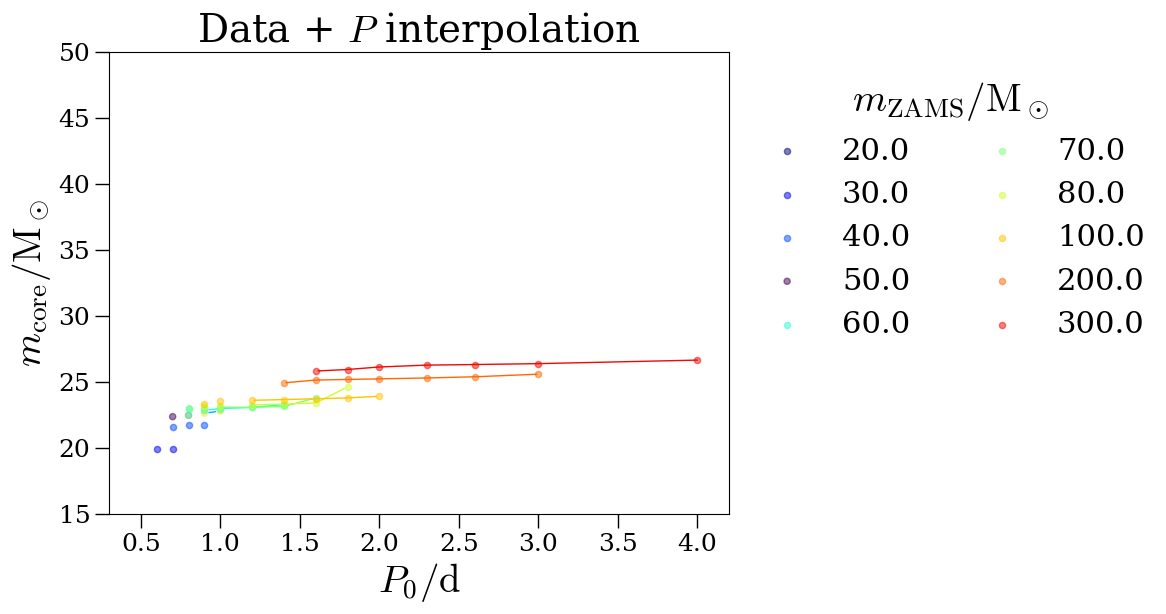

In [90]:
fig, ax = plt.subplots(figsize=(8, 6))
interpolator_dict = l2_pzams_mcore_interpolator_dict

for i, m_key in enumerate(mass_guide_str):
    c = cm.jet(i/len(mass_guide_str))
    interpolator = interpolator_dict[m_key]
    plot_ps = np.linspace(0, 4, 100)
    che_mask = np.array(final_mass_array[:,i,9], bool)
    ax.scatter(period_guide_float[che_mask], final_mass_array[:,i,0][che_mask], marker='o', c=c, zorder=1, label=m_key, s=20, alpha=0.5)
    ax.scatter(period_guide_float[~che_mask], final_mass_array[:,i,3][~che_mask], marker='x', c=c, zorder=2)
    ax.plot(plot_ps, interpolator(plot_ps), c=c, zorder=0, lw=1)
    
ax.set_ylim(15, 50)
ax.set_xlim(0.3, 4.2)

ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$m_\\mathrm{core}/\\mathrm{M}_\\odot$')

ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=2, title='$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
ax.set_title('Data + $P$ interpolation')

savefig(fig, 'pzams_mcore_data')

In [91]:
def l2_mzams_mcore_interpolator(m_zams, p_zams):
    ip_m_cores = []
    for m_key in mass_guide_str:
        interpolator = l2_pzams_mcore_interpolator_dict[m_key]
        ip_m_cores.append(interpolator(p_zams))
    
    interpolator = interp1d(
        x=mass_guide_float,
        y=ip_m_cores,
        kind='linear',
        bounds_error=False,
        fill_value='extrapolate'
    )
    
    m_core = interpolator(m_zams)
    
    return m_core  

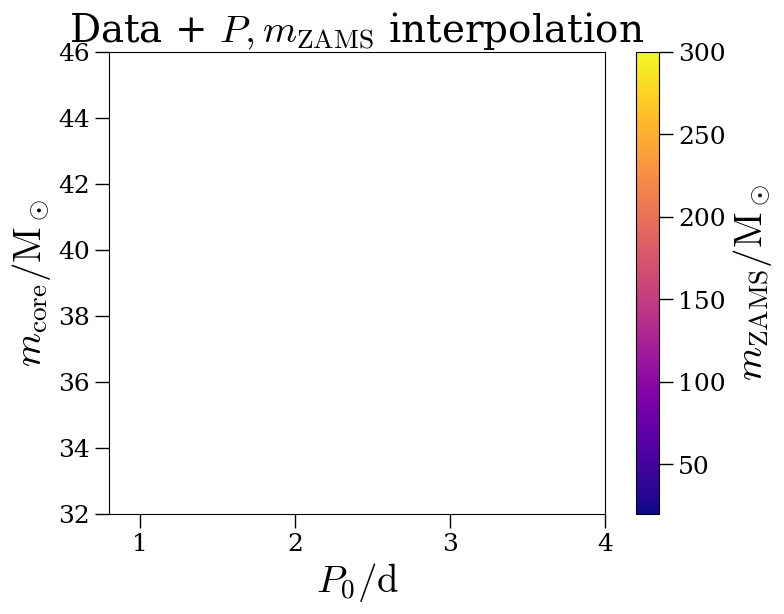

In [92]:
fig, ax = plt.subplots(figsize=(8, 6))
interpolator = l2_mzams_mcore_interpolator
cmap = cm.plasma

test_masses = np.linspace(20, 300, 500)
test_periods = np.linspace(0.1, 4)

for i, m in enumerate(test_masses):
    c = cmap(i/len(test_masses))
    m_cores = [interpolator(m, p) for p in test_periods]
    ax.plot(test_periods, m_cores, c=c, lw=2, label=f'${m:.1f}$')
    
ax.set_ylim(32, 46)
ax.set_xlim(0.8, 4)

ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$m_\\mathrm{core}/\\mathrm{M}_\\odot$')

#ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, title='$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
sm = ScalarMappable(norm=Normalize(vmin=min(test_masses), vmax=max(test_masses)), cmap=cmap)
cb = fig.colorbar(mappable=sm, ax=ax)
cb.set_label('$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')

ax.set_title('Data + $P,m_\\mathrm{ZAMS}$ interpolation')

savefig(fig, 'pzams_mcore_ip')

In [93]:
interpolator_dict = dict()

for i, m in enumerate(mass_guide_float):
    m_key = mass_guide_str[i]
    p_arr = period_guide_float   
    y_arr = final_mass_array[:, i, 6] 
    r_arr = final_mass_array[:, i, 6] 
    
    mask = np.array(final_mass_array[:, i, 9], bool)
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]
    r_arr = r_arr[mask]

    if m_key in ['280.0', '220.0', '160.0', '50.0', '80.0']:
        p_arr = p_arr[1:]
        y_arr = y_arr[1:]
        r_arr = r_arr[1:]
 
    mask = []
    for p0, rzams in zip(p_arr, r_arr):
        isof = is_of(rzams, float(m_key), p0, 1, kind='L2')
        if isof:
            mask.append(False)
        else:
            mask.append(True)
    
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]
    r_arr = r_arr[mask]
    
    if len(y_arr) == 0:
        y_arr = [nan]
        p_arr = [1]
        r_arr = [1]
    
    interpolator = interp1d(
        x=p_arr,
        y=y_arr,
        kind='linear',
        bounds_error=False,
        fill_value=nan
        )

    interpolator_dict[m_key] = interpolator     
    
l2_pzams_rzams_interpolator_dict = interpolator_dict

/tmp/ipykernel_2123654/4193244287.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(period_guide_float[che_mask], final_mass_array[:,i,6][che_mask], marker='o', c=c, zorder=1, s=20, alpha=0.5)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


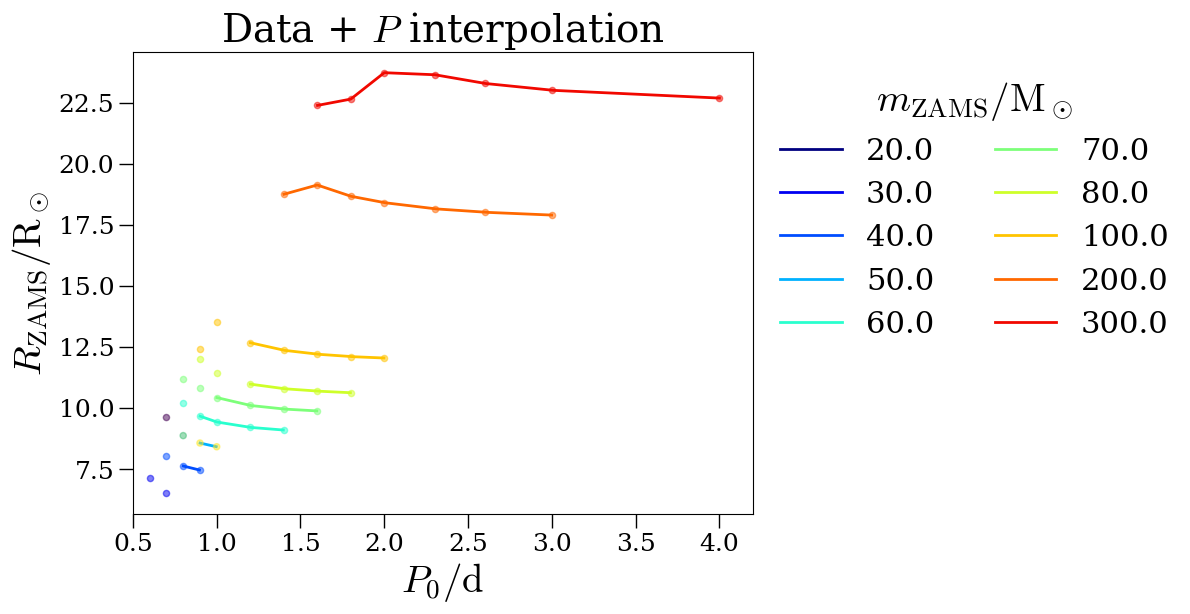

In [94]:
fig, ax = plt.subplots(figsize=(8, 6))
interpolator_dict = l2_pzams_rzams_interpolator_dict

for i, m_key in enumerate(mass_guide_str):
    c = cm.jet(i/len(mass_guide_str))
    interpolator = interpolator_dict[m_key]
    plot_ps = np.linspace(0, 4, 1000)
    che_mask = np.array(final_mass_array[:,i,9], bool)
    ax.scatter(period_guide_float[che_mask], final_mass_array[:,i,6][che_mask], marker='o', c=c, zorder=1, s=20, alpha=0.5)
    #ax.scatter(period_guide_float[~che_mask], final_mass_array[:,i,6][~che_mask], marker='x', c=c, zorder=2)
    ax.plot(plot_ps, interpolator(plot_ps), c=c, label=m_key, zorder=0)
    
#ax.set_ylim(20, 40)
ax.set_xlim(0.5, 4.2)

ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$R_\\mathrm{ZAMS}/\\mathrm{R}_\\odot$')

ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=2, title='$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
ax.set_title('Data + $P$ interpolation')

savefig(fig, 'pzams_rzams_data')

In [95]:
def l2_mzams_rzams_interpolator(m_zams, p_zams):
    ip_m_cores = []
    for m_key in mass_guide_str:
        interpolator = l2_pzams_rzams_interpolator_dict[m_key]
        ip_m_cores.append(interpolator(p_zams))
    
    interpolator = interp1d(
        x=mass_guide_float,
        y=ip_m_cores,
        kind='linear',
        bounds_error=False,
        fill_value=nan
    )
    
    m_core = interpolator(m_zams)
    
    return m_core      

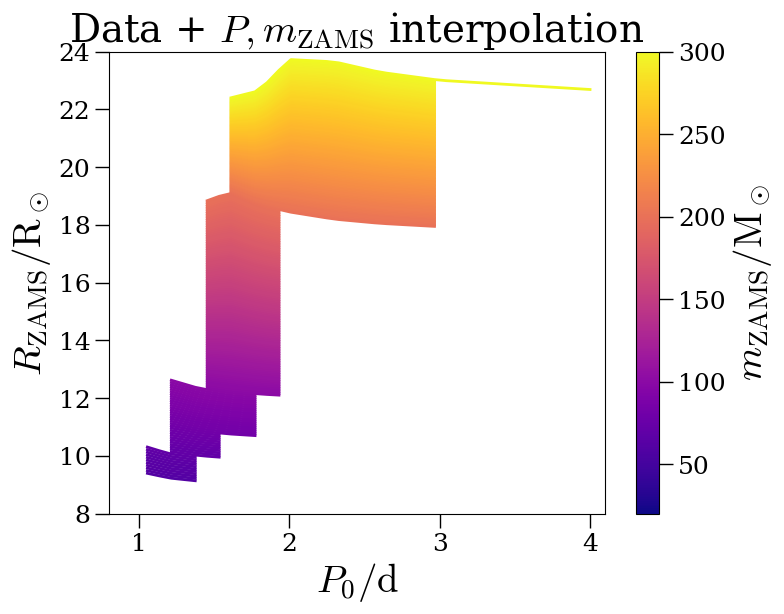

In [96]:
fig, ax = plt.subplots(figsize=(8, 6))
interpolator = l2_mzams_rzams_interpolator
cmap = cm.plasma

test_masses = np.linspace(20, 300, 300)
test_periods = np.linspace(0.1, 4)

for i, m in enumerate(test_masses):
    c = cmap(i/len(test_masses))
    m_cores = [interpolator(m, p) for p in test_periods]
    ax.plot(test_periods, m_cores, c=c, lw=2, label=f'${m:.1f}$')
    
ax.set_ylim(8, 24)
ax.set_xlim(0.8, 4.1)

ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$R_\\mathrm{ZAMS}/\\mathrm{R}_\\odot$')

#ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, title='$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
sm = ScalarMappable(norm=Normalize(vmin=min(test_masses), vmax=max(test_masses)), cmap=cmap)
cb = fig.colorbar(mappable=sm, ax=ax)
cb.set_label('$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')

ax.set_title('Data + $P,m_\\mathrm{ZAMS}$ interpolation')

savefig(fig, 'pzams_rzams_ip')

### Core mass distribution

In [97]:
res = int(1e8)
min_m = 20
max_m = 300
min_p = 0.1
max_p = 4

sample_masses = np.linspace(min_m, max_m, res)
sample_probs = sample_masses**-2.3/np.sum(sample_masses**-2.3)
sample_masses = np.random.choice(sample_masses, p=sample_probs, size=int(res/100))

sample_periods = np.linspace(np.log10(min_p), np.log10(max_p), res)
sample_probs = np.ones(res)/res
sample_periods = 10.**np.random.choice(sample_periods, p=sample_probs, size=int(res/100))

sample_zams_rs = np.array([l2_mzams_rzams_interpolator(m, p) for m, p in zip(sample_masses, sample_periods)])

sample_mcores = np.zeros(int(res/100))

sample_ = np.array([sample_masses, sample_periods, sample_zams_rs, sample_mcores]).T

In [98]:
def set_mcores(sample):
    for i, star in enumerate(sample):
        r = star[2]
        isof = is_of(r=r, m=star[0], p=star[1], q=1, kind='L2')
        if isof:
            mcore = nan
        else:
            mcore = l2_mzams_mcore_interpolator(star[0], star[1])
        sample[i, 3] = mcore
    return sample

In [99]:
def draw_mass_sample(
    res=int(1e8),
    min_m=20,
    max_m=300,
    min_p=0.1,
    max_p=4,
    min_mfinal=20,
    max_mfinal=50,
    mfinal_bin_width=0.2
):
    sample_masses = np.linspace(min_m, max_m, res)
    sample_probs = sample_masses**-2.3/np.sum(sample_masses**-2.3)
    sample_masses = np.random.choice(sample_masses, p=sample_probs, size=int(res/100))

    sample_periods = np.linspace(np.log10(min_p), np.log10(max_p), res)
    sample_probs = np.ones(res)/res
    sample_periods = 10.**np.random.choice(sample_periods, p=sample_probs, size=int(res/100))

    sample_zams_rs = np.array([l2_mzams_rzams_interpolator(m, p) for m, p in zip(sample_masses, sample_periods)])

    sample_mcores = np.zeros(int(res/100))

    sample_ = np.array([sample_masses, sample_periods, sample_zams_rs, sample_mcores]).T
    zams_l2of_sample = set_mcores(sample_).copy()
    
    mass_draw = zams_l2of_sample[:, 3]
    mass_draw = mass_draw[~np.isnan(mass_draw)]

    bins = np.arange(min_mfinal, max_mfinal+mfinal_bin_width, mfinal_bin_width)
    hist, bins = np.histogram(mass_draw, density=True, bins=bins)
    centers = np.array([(bin0+bin1)/2 for bin0, bin1 in zip(bins[:-1], bins[1:])])
    mode = centers[np.argmax(hist)]
    
    return zams_l2of_sample, mode

In [100]:
from multiprocessing import Pool
from scipy.stats import mode

In [ ]:
result = draw_mass_sample(res=int(1e8))

Text(0.98, 0.98, 'Stopping condition: central_c12<=1e-6\nSome models start core Ne burning')

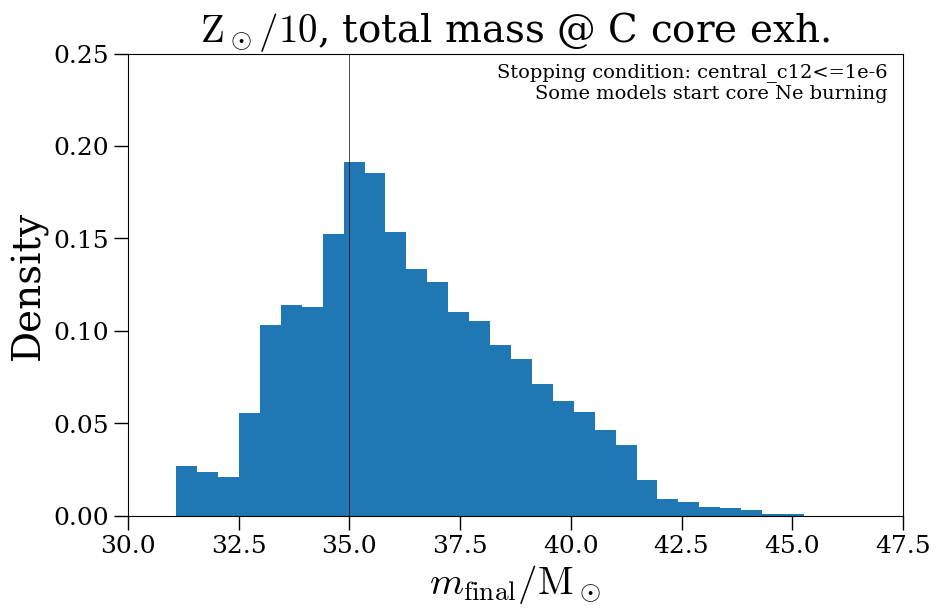

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(result[0][:,3], density=True, bins=30)

ax.vlines(35, 0, 0.3, color='k', lw=0.5)
ax.set_ylim(0, 0.25)
ax.set_xlim(30, 45)
ax.set_xticks(np.arange(30, 50, 2.5))

ax.set_ylabel('Density')
ax.set_xlabel('$m_\\mathrm{final}/\mathrm{M}_\odot$')
ax.set_title('$\\mathrm{Z}_\\odot/10$, total mass @ C core exh.')

note = '\n'.join(('Stopping condition: central_c12<=1e-6',
                  'Some models start core Ne burning'))
ax.text(0.98, 
        0.98, 
        note,
        transform=ax.transAxes,
        ha='right',
        va='top',
        fontsize=14
        )


In [ ]:
n_cores = 36
process_pool = Pool(n_cores)
results = process_pool.map(draw_mass_sample, [int(1e8)]*10)

KeyboardInterrupt: 

(0.0, 0.25)

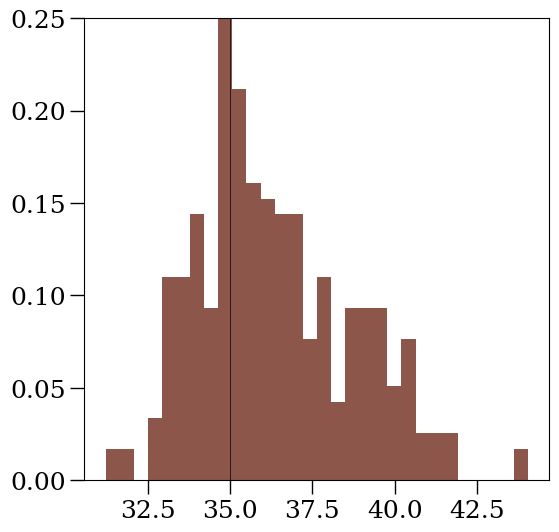

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))

for draw, mode in results:
    ax.hist(draw[:,3], density=True, bins=30)

ax.vlines(35, 0, 0.3, color='k', lw=0.5)
ax.set_ylim(0, 0.25)


In [ ]:
import pickle as pkl
np.save('31mcore_sample.npy', sample_)
with open('31mzams_mcore_interpolator.pkl', 'wb') as f:
    pkl.dump(l2_mzams_mcore_interpolator, f)

## No plots interpolator

## $0.1\mathrm{Z}_\odot$

In [104]:
#np.save(f'nb{nb_id}_p_plot_extended.npy', p_plot)
final_mass_array = np.load('00_enhanced_w_core_props.npy')
model_dicts = model_dicts_01zsun

In [105]:
final_mass_array.shape

(35, 20, 10)

In [82]:
# Select models
models_to_plot = np.arange(0, len(model_dicts), 1)
model_dict_list = model_dicts[models_to_plot]
print(f'Loading {model_dict_list}')

# Collect periods
all_periods = []
for dict_ in model_dict_list:
    for k1 in dict_.keys():
        for k2 in dict_[k1].keys():
            all_periods.append(k2)
all_periods = np.unique(all_periods)
all_periods = all_periods[np.argsort([float(p) for p in all_periods])][1:]
print(all_periods)

Loading [{'20.0': {'2.60': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_p2.600d+00_w2.797d-05'), '4.00': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_p4.000d+00_w1.818d-05'), '0.40': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_p4.000d-01_w1.818d-04'), '2.00': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_p2.000d+00_w3.636d-05'), '0.70': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_p7.000d-01_w1.039d-04'), '1.60': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/001_md1_m20

In [83]:
mass_guide_str = [list(dict_.keys())[0] for dict_ in model_dict_list]
mass_guide_float = np.array([float(m) for m in mass_guide_str])

period_guide_str = all_periods
period_guide_float = np.array([float(p) for p in period_guide_str])

In [84]:
from scipy.interpolate import interp1d

In [85]:
from math import nan

### Core mass plane

In [86]:
stage_index = dict(zams=6, prezams=7)

In [87]:
def mzams_p0_mcore_of_plot(ax, of_when, of_kind, min_mcore=20, max_mcore=50):    
    of_when_i = stage_index[of_when]
    handles = []
    for i, m_key in enumerate(mass_guide_str):
        c = cm.jet(i/len(mass_guide_str))
        handles.append(ax.scatter([], [], c=c, marker='o', label=m_key))
        m_zams = float(m_key)
        
        #che_mask = np.array(final_mass_array[:,i,9], bool)
        pp = period_guide_float#[che_mask]
        mm = final_mass_array[:,i,0]#[che_mask]
        rr = final_mass_array[:,i,of_when_i]#[che_mask]
        is_che = np.array(final_mass_array[:,i,9], bool)
        is_crit = np.array(final_mass_array[:,i,8], bool)
        
        for p, r, m_core, ische, iscrit in zip(pp, rr, mm, is_che, is_crit):
            if iscrit:
                marker = 'x'
                color = 'k'
            elif not ische:
                marker = '+'
                color = 'k'
            else:
                marker = 'o'
                color = cm.jet_r((np.log10(m_core)-np.log10(min_mcore))/(np.log10(max_mcore)-np.log10(min_mcore)))
            isof = is_of(r, m_zams, p, 1, kind=of_kind)
            if isof:
                alpha = 0.3
            else:
                alpha = 1.0
            ax.scatter(m_zams, p, marker=marker, color=color, zorder=1, s=30, alpha=alpha)
    return ax, handles

In [88]:
def p0_mcore_mzams_of_plot(ax, of_when, of_kind):
    of_when_i = stage_index[of_when]
    handles = []
    for i, m_key in enumerate(mass_guide_str):
        c = cm.jet(i/len(mass_guide_str))
        handles.append(ax.scatter([], [], c=c, marker='o', label=m_key))
        m_zams = float(m_key)
        
        che_mask = np.array(final_mass_array[:,i,9], bool)
        pp = period_guide_float[che_mask]
        mm = final_mass_array[:,i,3][che_mask]
        rr = final_mass_array[:,i,of_when_i][che_mask]
            
        for p, r, m_core in zip(pp, rr, mm):
            isof = is_of(r, m_zams, p, 1, kind=of_kind)
            if isof:
                ax.scatter(p, m_core, marker='x', color=c, zorder=1, s=30, alpha=0.3)
                pass
            else:
                ax.scatter(p, m_core, marker='o', color=c, zorder=1, s=30)
    return ax, handles

In [89]:
def is_of(r, m, p, q=1, kind='RL'):
    a = a_from_p(p, m, q)
    if kind == 'merger':
        of_a = a.to(u.Rsun).value
    elif kind == 'RL':
        of_a = eggleton_rl1_radius(a, q).to(u.Rsun).value
    elif kind == 'L2':
        of_a = marchant_l2_radius(a, q).to(u.Rsun).value
    elif kind == 'none':
        of_a = np.inf
    else:
        raise ValueError(f'kind {kind} not recognized')
    if of_a <= r:
        isof = True
    else:
        isof = False

    return isof

In [90]:
min_mcore = final_mass_array[:, :, 0][np.array(final_mass_array[:, :, 9], bool)].min()
max_mcore = final_mass_array[:, :, 0][np.array(final_mass_array[:, :, 9], bool)].max()
mcore_norm = TwoSlopeNorm(vmin=min(30, min_mcore), vmax=max(max_mcore, 40), vcenter=35.)
nonche_c = to_rgba('darkslategrey')
crit_c = to_rgba('slategrey')
cmap = cm.seismic
def mcore_cmap(x): return cmap(mcore_norm(x))

In [91]:
m_arr = np.zeros(len(mass_guide_float)+1)
p_arr = np.zeros(len(period_guide_float)+1)
mcore_arr = np.zeros((len(mass_guide_float), len(period_guide_float), 4))
zams_l2of_arr = np.zeros((len(mass_guide_float), len(period_guide_float), 4))

for i_m, m1 in enumerate(mass_guide_float):
    if i_m == 0:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        bin_lower_m = m1 - (bin_upper_m-m1)
    elif i_m < len(mass_guide_float)-1:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
    else:
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
        bin_upper_m = m1 + (m1-bin_lower_m)
    m_arr[i_m] = bin_lower_m
    m_arr[i_m+1] = bin_upper_m
    
    for i_p, p1 in enumerate(period_guide_float):
        if i_p == 0:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = p1 - (bin_upper_p-p1)
        elif i_p < len(period_guide_float)-1:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (p0+p1)/2
        else:
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (p0+p1)/2
            m2 = m1 + (m1-bin_lower_p)
        p_arr[i_p] = p0
        p_arr[i_p+1] = p2
        
        mcore = final_mass_array[i_p, i_m, 0]
        ische = final_mass_array[i_p, i_m, 9]
        iscrit = final_mass_array[i_p, i_m, 8]
        if ische:
            mcore_arr[i_m, i_p, :] = mcore_cmap(mcore)
        elif iscrit: 
            mcore_arr[i_m, i_p, :] = crit_c
        else:
            mcore_arr[i_m, i_p, :] = nonche_c

        rzams = final_mass_array[i_p, i_m, 6]
        is_l2of = is_of(r=rzams, m=m1, p=p1, q=1, kind='L2')
        if is_l2of:
            zams_l2of_arr[i_m, i_p, :] = [0, 0, 0, 0]
        else:
            zams_l2of_arr[i_m, i_p, :] = 4*[nan]
            
m_arr = np.tile(m_arr, [len(period_guide_float)+1, 1]).T
p_arr = np.tile(p_arr, [len(mass_guide_float)+1, 1])

color_mcore_arr = mcore_arr
color_m_arr = m_arr
color_p_arr = p_arr

In [92]:
m_arr = np.zeros(len(mass_guide_float)+1)
p_arr = np.zeros(len(period_guide_float)+1)
mcore_arr = np.zeros((len(mass_guide_float), len(period_guide_float), 4))
che_mask = np.ones((len(mass_guide_float)+1, len(period_guide_float)+1), bool)

for i_m, m1 in enumerate(mass_guide_float):
    if i_m == 0:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        bin_lower_m = m1 - (bin_upper_m-m1)
    elif i_m < len(mass_guide_float)-1:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
    else:
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
        bin_upper_m = m1 + (m1-bin_lower_m)
    m_arr[i_m] = bin_lower_m
    m_arr[i_m+1] = bin_upper_m
    
    for i_p, p1 in enumerate(period_guide_float):
        if i_p == 0:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = p1 - (bin_upper_p-p1)
        elif i_p < len(period_guide_float)-1:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (p0+p1)/2
        else:
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (m0+m1)/2
            m2 = m1 + (m1-bin_lower_p)
        p_arr[i_p] = p0
        p_arr[i_p+1] = p2
        
        mcore = final_mass_array[i_p, i_m, 0]
        ische = final_mass_array[i_p, i_m, 9]
        iscrit = final_mass_array[i_p, i_m, 8]
        if ische:
            mcore_arr[i_m, i_p, :] = 4*[nan]
            che_mask[i_m, i_p] = True
        elif iscrit: 
            mcore_arr[i_m, i_p, :] = crit_c
            che_mask[i_m, i_p] = False
        else:
            mcore_arr[i_m, i_p, :] = 4*[nan]
            che_mask[i_m, i_p] = False
            
m_arr = np.tile(m_arr, [len(period_guide_float)+1, 1]).T
p_arr = np.tile(p_arr, [len(mass_guide_float)+1, 1])

hatch_crit_mcore_arr = mcore_arr
hatch_crit_m_arr = m_arr
hatch_crit_p_arr = p_arr

In [93]:
m_arr = np.zeros(len(mass_guide_float)+1)
p_arr = np.zeros(len(period_guide_float)+1)
mcore_arr = np.zeros((len(mass_guide_float), len(period_guide_float), 4))
che_mask = np.ones((len(mass_guide_float)+1, len(period_guide_float)+1), bool)

for i_m, m1 in enumerate(mass_guide_float):
    if i_m == 0:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        bin_lower_m = m1 - (bin_upper_m-m1)
    elif i_m < len(mass_guide_float)-1:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
    else:
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
        bin_upper_m = m1 + (m1-bin_lower_m)
    m_arr[i_m] = bin_lower_m
    m_arr[i_m+1] = bin_upper_m
    
    for i_p, p1 in enumerate(period_guide_float):
        if i_p == 0:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = p1 - (bin_upper_p-p1)
        elif i_p < len(period_guide_float)-1:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (p0+p1)/2
        else:
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (m0+m1)/2
            m2 = m1 + (m1-bin_lower_p)
        p_arr[i_p] = p0
        p_arr[i_p+1] = p2
        
        mcore = final_mass_array[i_p, i_m, 0]
        ische = final_mass_array[i_p, i_m, 9]
        iscrit = final_mass_array[i_p, i_m, 8]
        if ische:
            mcore_arr[i_m, i_p, :] = 4*[nan]
            che_mask[i_m, i_p] = True
        elif iscrit: 
            mcore_arr[i_m, i_p, :] = 4*[nan]
            che_mask[i_m, i_p] = False
        else:
            mcore_arr[i_m, i_p, :] = nonche_c
            che_mask[i_m, i_p] = False
            
m_arr = np.tile(m_arr, [len(period_guide_float)+1, 1]).T
p_arr = np.tile(p_arr, [len(mass_guide_float)+1, 1])

hatch_nonche_mcore_arr = mcore_arr
hatch_nonche_m_arr = m_arr
hatch_nonche_p_arr = p_arr

In [94]:
nonche_hatch = '\\'
crit_hatch = '/'
l2of_hatch = 'o'

In [95]:
from matplotlib.patches import Patch

In [96]:
def mass_forward(m):
    return m**-2.35

def mass_inverse(m):
    return m**(-1/2.35)

In [97]:
interpolator_dict = dict()

for i, m in enumerate(mass_guide_float):
    m_key = mass_guide_str[i]
    p_arr = period_guide_float   
    y_arr = final_mass_array[:, i, 0] 
    r_arr = final_mass_array[:, i, 6] 

    mask = np.array(final_mass_array[:, i, 9], bool)
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]
    r_arr = r_arr[mask]
            
        
    mask = []
    for p0, rzams in zip(p_arr, r_arr):
        isof = is_of(rzams, float(m_key), p0, 1, kind='L2')
        if isof:
            mask.append(False)
        else:
            mask.append(True)
            
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]
    r_arr = r_arr[mask]
    
    if len(y_arr) == 0:
        y_arr = [nan]
        p_arr = [1]
        r_arr = [1]
    
    interpolator = interp1d(
        x=p_arr,
        y=y_arr,
        kind='linear',
        bounds_error=False,
        fill_value=nan
        )

    interpolator_dict[m_key] = interpolator     
    
l2_pzams_mcore_interpolator_dict = interpolator_dict

IndexError: boolean index did not match indexed array along dimension 0; dimension is 15 but corresponding boolean dimension is 35

In [ ]:
def l2_mzams_mcore_interpolator(m_zams, p_zams):
    ip_m_cores = []
    for m_key in mass_guide_str:
        interpolator = l2_pzams_mcore_interpolator_dict[m_key]
        ip_m_cores.append(interpolator(p_zams))
    
    interpolator = interp1d(
        x=mass_guide_float,
        y=ip_m_cores,
        kind='linear',
        bounds_error=False,
        fill_value='extrapolate'
    )
    
    m_core = interpolator(m_zams)
    
    return m_core  

In [51]:
interpolator_dict = dict()

for i, m in enumerate(mass_guide_float):
    m_key = mass_guide_str[i]
    p_arr = period_guide_float   
    y_arr = final_mass_array[:, i, 6] 
    r_arr = final_mass_array[:, i, 6] 
    
    mask = np.array(final_mass_array[:, i, 9], bool)
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]
    r_arr = r_arr[mask]

    if m_key in ['280.0', '220.0', '160.0', '50.0', '80.0']:
        p_arr = p_arr[1:]
        y_arr = y_arr[1:]
        r_arr = r_arr[1:]
 
    mask = []
    for p0, rzams in zip(p_arr, r_arr):
        isof = is_of(rzams, float(m_key), p0, 1, kind='L2')
        if isof:
            mask.append(False)
        else:
            mask.append(True)
    
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]
    r_arr = r_arr[mask]
    
    if len(y_arr) == 0:
        y_arr = [nan]
        p_arr = [1]
        r_arr = [1]
    
    interpolator = interp1d(
        x=p_arr,
        y=y_arr,
        kind='linear',
        bounds_error=False,
        fill_value=nan
        )

    interpolator_dict[m_key] = interpolator     
    
l2_pzams_rzams_interpolator_dict = interpolator_dict

IndexError: boolean index did not match indexed array along dimension 0; dimension is 15 but corresponding boolean dimension is 35

In [ ]:
def l2_mzams_rzams_interpolator(m_zams, p_zams):
    ip_m_cores = []
    for m_key in mass_guide_str:
        interpolator = l2_pzams_rzams_interpolator_dict[m_key]
        ip_m_cores.append(interpolator(p_zams))
    
    interpolator = interp1d(
        x=mass_guide_float,
        y=ip_m_cores,
        kind='linear',
        bounds_error=False,
        fill_value=nan
    )
    
    m_core = interpolator(m_zams)
    
    return m_core      

In [52]:
def draw_mass_sample(
    res=int(1e8),
    min_m=20,
    max_m=300,
    min_p=0.1,
    max_p=4,
    min_mfinal=20,
    max_mfinal=50,
    mfinal_bin_width=0.2
):
    sample_masses = np.linspace(min_m, max_m, res)
    sample_probs = sample_masses**-2.3/np.sum(sample_masses**-2.3)
    sample_masses = np.random.choice(sample_masses, p=sample_probs, size=int(res/100))

    sample_periods = np.linspace(np.log10(min_p), np.log10(max_p), res)
    sample_probs = np.ones(res)/res
    sample_periods = 10.**np.random.choice(sample_periods, p=sample_probs, size=int(res/100))

    sample_zams_rs = np.array([l2_mzams_rzams_interpolator(m, p) for m, p in zip(sample_masses, sample_periods)])

    sample_mcores = np.zeros(int(res/100))

    sample_ = np.array([sample_masses, sample_periods, sample_zams_rs, sample_mcores]).T
    zams_l2of_sample = set_mcores(sample_).copy()
    
    mass_draw = zams_l2of_sample[:, 3]
    mass_draw = mass_draw[~np.isnan(mass_draw)]

    bins = np.arange(min_mfinal, max_mfinal+mfinal_bin_width, mfinal_bin_width)
    hist, bins = np.histogram(mass_draw, density=True, bins=bins)
    centers = np.array([(bin0+bin1)/2 for bin0, bin1 in zip(bins[:-1], bins[1:])])
    mode = centers[np.argmax(hist)]
    
    return zams_l2of_sample, mode

In [53]:
from multiprocessing import Pool
from scipy.stats import mode

In [ ]:
result00 = draw_mass_sample(res=int(1e7))

NameError: name 'l2_mzams_rzams_interpolator' is not defined

In [ ]:
result = result00

Text(0.98, 0.98, 'Stopping condition: central_c12<=1e-6\nSome models start core Ne burning')

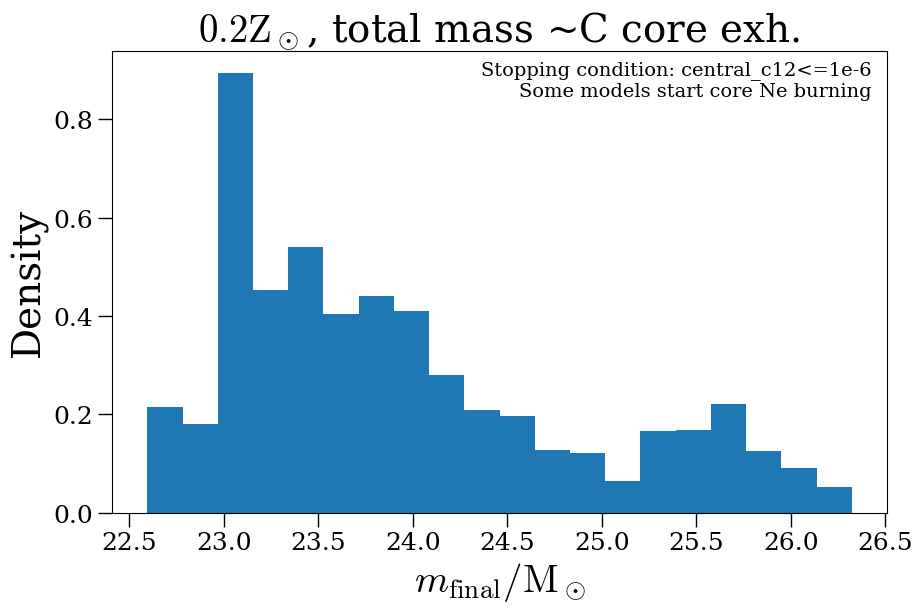

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(result[0][:,3], density=True, bins=20)

#ax.vlines(35, 0, 0.3, color='k', lw=0.5)
#ax.set_ylim(0, 0.25)
#ax.set_xlim(30, 45)
#ax.set_xticks(np.arange(30, 50, 2.5))

ax.set_ylabel('Density')
ax.set_xlabel('$m_\\mathrm{final}/\mathrm{M}_\odot$')
ax.set_title('$0.1\\mathrm{Z}_\\odot$, total mass ~C core exh.')

note = '\n'.join(('Stopping condition: central_c12<=1e-6',
                  'Some models start core Ne burning'))
ax.text(0.98, 
        0.98, 
        note,
        transform=ax.transAxes,
        ha='right',
        va='top',
        fontsize=14
        )


## $0.2\mathrm{Z}_\odot$

In [29]:
#np.save(f'nb{nb_id}_p_plot_extended.npy', p_plot)
final_mass_array = np.load('01_enhanced_w_core_props.npy')

In [31]:
# Select models
models_to_plot = np.arange(0, len(model_dicts), 1)
model_dict_list = model_dicts[models_to_plot]
print(f'Loading {model_dict_list}')

# Collect periods
all_periods = []
for dict_ in model_dict_list:
    for k1 in dict_.keys():
        for k2 in dict_[k1].keys():
            all_periods.append(k2)
all_periods = np.unique(all_periods)
all_periods = all_periods[np.argsort([float(p) for p in all_periods])][1:]
print(all_periods)

Loading [{'20.0': {'2.60': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/01_ZdivZsun_2d-1/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_p2.600d+00_w2.797d-05'), '4.00': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/01_ZdivZsun_2d-1/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_p4.000d+00_w1.818d-05'), '0.40': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/01_ZdivZsun_2d-1/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_p4.000d-01_w1.818d-04'), '2.00': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/01_ZdivZsun_2d-1/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_p2.000d+00_w3.636d-05'), '0.70': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/01_ZdivZsun_2d-1/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_p7.000d-01_w1.039d-04'), '1.60': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/01_ZdivZsun_2d-1/001_md1_m20

In [160]:
mass_guide_str = [list(dict_.keys())[0] for dict_ in model_dict_list]
mass_guide_float = np.array([float(m) for m in mass_guide_str])

period_guide_str = all_periods
period_guide_float = np.array([float(p) for p in period_guide_str])

In [161]:
from scipy.interpolate import interp1d

In [162]:
from math import nan

### Core mass plane

In [163]:
stage_index = dict(zams=6, prezams=7)

In [164]:
def mzams_p0_mcore_of_plot(ax, of_when, of_kind, min_mcore=20, max_mcore=50):    
    of_when_i = stage_index[of_when]
    handles = []
    for i, m_key in enumerate(mass_guide_str):
        c = cm.jet(i/len(mass_guide_str))
        handles.append(ax.scatter([], [], c=c, marker='o', label=m_key))
        m_zams = float(m_key)
        
        #che_mask = np.array(final_mass_array[:,i,9], bool)
        pp = period_guide_float#[che_mask]
        mm = final_mass_array[:,i,0]#[che_mask]
        rr = final_mass_array[:,i,of_when_i]#[che_mask]
        is_che = np.array(final_mass_array[:,i,9], bool)
        is_crit = np.array(final_mass_array[:,i,8], bool)
        
        for p, r, m_core, ische, iscrit in zip(pp, rr, mm, is_che, is_crit):
            if iscrit:
                marker = 'x'
                color = 'k'
            elif not ische:
                marker = '+'
                color = 'k'
            else:
                marker = 'o'
                color = cm.jet_r((np.log10(m_core)-np.log10(min_mcore))/(np.log10(max_mcore)-np.log10(min_mcore)))
            isof = is_of(r, m_zams, p, 1, kind=of_kind)
            if isof:
                alpha = 0.3
            else:
                alpha = 1.0
            ax.scatter(m_zams, p, marker=marker, color=color, zorder=1, s=30, alpha=alpha)
    return ax, handles

In [165]:
def p0_mcore_mzams_of_plot(ax, of_when, of_kind):
    of_when_i = stage_index[of_when]
    handles = []
    for i, m_key in enumerate(mass_guide_str):
        c = cm.jet(i/len(mass_guide_str))
        handles.append(ax.scatter([], [], c=c, marker='o', label=m_key))
        m_zams = float(m_key)
        
        che_mask = np.array(final_mass_array[:,i,9], bool)
        pp = period_guide_float[che_mask]
        mm = final_mass_array[:,i,3][che_mask]
        rr = final_mass_array[:,i,of_when_i][che_mask]
            
        for p, r, m_core in zip(pp, rr, mm):
            isof = is_of(r, m_zams, p, 1, kind=of_kind)
            if isof:
                ax.scatter(p, m_core, marker='x', color=c, zorder=1, s=30, alpha=0.3)
                pass
            else:
                ax.scatter(p, m_core, marker='o', color=c, zorder=1, s=30)
    return ax, handles

In [166]:
def is_of(r, m, p, q=1, kind='RL'):
    a = a_from_p(p, m, q)
    if kind == 'merger':
        of_a = a.to(u.Rsun).value
    elif kind == 'RL':
        of_a = eggleton_rl1_radius(a, q).to(u.Rsun).value
    elif kind == 'L2':
        of_a = marchant_l2_radius(a, q).to(u.Rsun).value
    elif kind == 'none':
        of_a = np.inf
    else:
        raise ValueError(f'kind {kind} not recognized')
    if of_a <= r:
        isof = True
    else:
        isof = False

    return isof

/tmp/ipykernel_2528056/1573620867.py:2: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0, hspace=0)
/tmp/ipykernel_2528056/3646536049.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handles.append(ax.scatter([], [], c=c, marker='o', label=m_key))


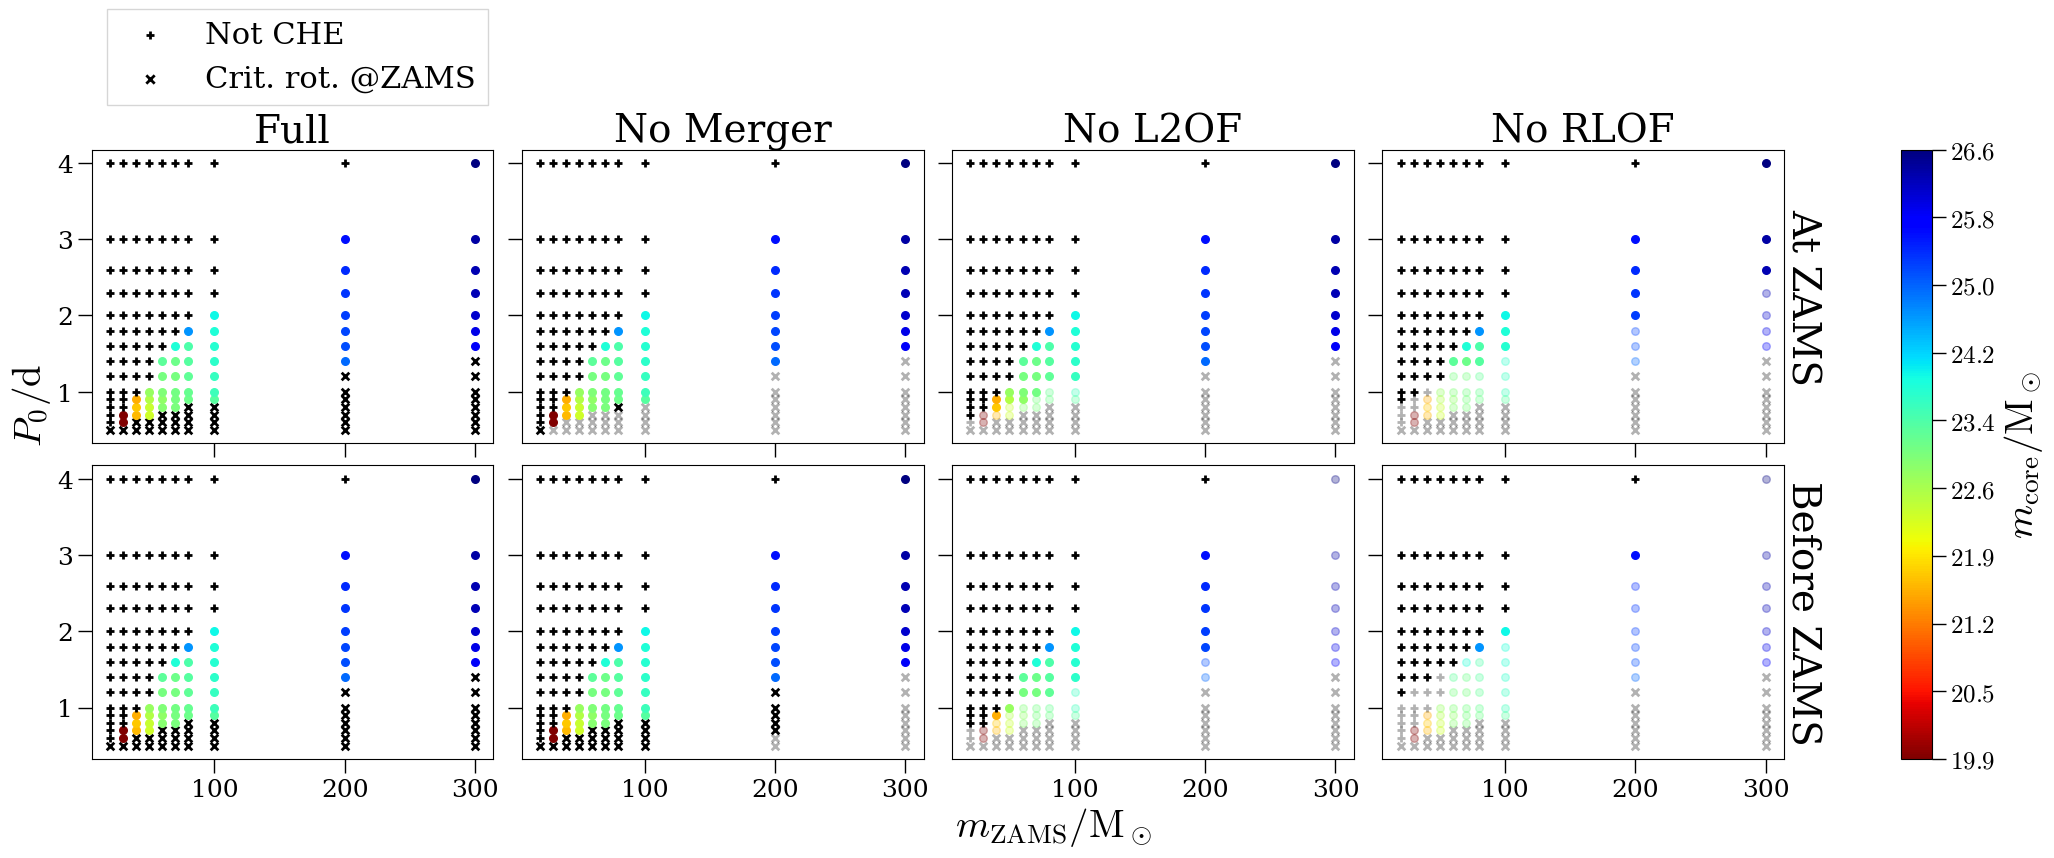

In [167]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey=True, layout='constrained')
fig.subplots_adjust(wspace=0, hspace=0)

plot_ps = np.linspace(0, 4, 100)

min_mcore = final_mass_array[:, :, 0][np.array(final_mass_array[:, :, 9], bool)].min()
max_mcore = final_mass_array[:, :, 0][np.array(final_mass_array[:, :, 9], bool)].max()

# AT ZAMS
of_when = 'zams'

of_kind = 'none'
ax = axes[0, 0]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)
ax.set_title('Full')                

of_kind = 'merger'
ax = axes[0, 1]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)
ax.set_title('No Merger')                

of_kind = 'L2'
ax = axes[0, 2]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)
ax.set_title('No L2OF')                

of_kind = 'RL'
ax = axes[0, 3]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)
ax.set_title('No RLOF')                

# AT ZAMS
of_when = 'prezams'

of_kind = 'none'
ax = axes[1, 0]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)

of_kind = 'merger'
ax = axes[1, 1]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)  

of_kind = 'L2'
ax = axes[1, 2]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)
             
of_kind = 'RL'
ax = axes[1, 3]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)
           
fig.text(0, 0.5, '$P_0/\\mathrm{d}$', rotation=90, ha='right', va='center')
fig.text(0.5, 0, '$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$', ha='center', va='top')
axes[0, 3].text(1, 0.5, 'At ZAMS', rotation=-90, ha='left', va='center', transform=axes[0, 3].transAxes)
axes[1, 3].text(1, 0.5, 'Before ZAMS', rotation=-90, ha='left', va='center', transform=axes[1, 3].transAxes)

sm = ScalarMappable(Normalize(vmin=np.log10(min_mcore), vmax=np.log10(max_mcore)), cm.jet_r)
cbar = fig.colorbar(sm, ax=axes[:,3], pad=0.2)
cbar.set_label('$m_\\mathrm{core}/\\mathrm{M}_\\odot$')
cbar.set_ticks(np.linspace(np.log10(min_mcore), np.log10(max_mcore), 10))
cbar.set_ticklabels([f'${10**logm:.1f}$' for logm in np.linspace(np.log10(min_mcore), np.log10(max_mcore), 10)])

handles = []
handles.append(ax.scatter([], [], marker='+', color='k', label='Not CHE'))
handles.append(ax.scatter([], [], marker='x', color='k', label='Crit. rot. @ZAMS'))
axes[0,0].legend(handles=handles, fancybox=False, loc='lower left', bbox_to_anchor=(0, 1.1))

#savefig(fig, 'che_window_02zsun')

In [168]:
min_mcore = final_mass_array[:, :, 0][np.array(final_mass_array[:, :, 9], bool)].min()
max_mcore = final_mass_array[:, :, 0][np.array(final_mass_array[:, :, 9], bool)].max()
mcore_norm = TwoSlopeNorm(vmin=min(30, min_mcore), vmax=max(max_mcore, 40), vcenter=35.)
nonche_c = to_rgba('darkslategrey')
crit_c = to_rgba('slategrey')
cmap = cm.seismic
def mcore_cmap(x): return cmap(mcore_norm(x))

In [169]:
m_arr = np.zeros(len(mass_guide_float)+1)
p_arr = np.zeros(len(period_guide_float)+1)
mcore_arr = np.zeros((len(mass_guide_float), len(period_guide_float), 4))
zams_l2of_arr = np.zeros((len(mass_guide_float), len(period_guide_float), 4))

for i_m, m1 in enumerate(mass_guide_float):
    if i_m == 0:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        bin_lower_m = m1 - (bin_upper_m-m1)
    elif i_m < len(mass_guide_float)-1:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
    else:
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
        bin_upper_m = m1 + (m1-bin_lower_m)
    m_arr[i_m] = bin_lower_m
    m_arr[i_m+1] = bin_upper_m
    
    for i_p, p1 in enumerate(period_guide_float):
        if i_p == 0:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = p1 - (bin_upper_p-p1)
        elif i_p < len(period_guide_float)-1:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (p0+p1)/2
        else:
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (p0+p1)/2
            m2 = m1 + (m1-bin_lower_p)
        p_arr[i_p] = p0
        p_arr[i_p+1] = p2
        
        mcore = final_mass_array[i_p, i_m, 0]
        ische = final_mass_array[i_p, i_m, 9]
        iscrit = final_mass_array[i_p, i_m, 8]
        if ische:
            mcore_arr[i_m, i_p, :] = mcore_cmap(mcore)
        elif iscrit: 
            mcore_arr[i_m, i_p, :] = crit_c
        else:
            mcore_arr[i_m, i_p, :] = nonche_c

        rzams = final_mass_array[i_p, i_m, 6]
        is_l2of = is_of(r=rzams, m=m1, p=p1, q=1, kind='L2')
        if is_l2of:
            zams_l2of_arr[i_m, i_p, :] = [0, 0, 0, 0]
        else:
            zams_l2of_arr[i_m, i_p, :] = 4*[nan]
            
m_arr = np.tile(m_arr, [len(period_guide_float)+1, 1]).T
p_arr = np.tile(p_arr, [len(mass_guide_float)+1, 1])

color_mcore_arr = mcore_arr
color_m_arr = m_arr
color_p_arr = p_arr

In [170]:
m_arr = np.zeros(len(mass_guide_float)+1)
p_arr = np.zeros(len(period_guide_float)+1)
mcore_arr = np.zeros((len(mass_guide_float), len(period_guide_float), 4))
che_mask = np.ones((len(mass_guide_float)+1, len(period_guide_float)+1), bool)

for i_m, m1 in enumerate(mass_guide_float):
    if i_m == 0:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        bin_lower_m = m1 - (bin_upper_m-m1)
    elif i_m < len(mass_guide_float)-1:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
    else:
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
        bin_upper_m = m1 + (m1-bin_lower_m)
    m_arr[i_m] = bin_lower_m
    m_arr[i_m+1] = bin_upper_m
    
    for i_p, p1 in enumerate(period_guide_float):
        if i_p == 0:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = p1 - (bin_upper_p-p1)
        elif i_p < len(period_guide_float)-1:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (p0+p1)/2
        else:
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (m0+m1)/2
            m2 = m1 + (m1-bin_lower_p)
        p_arr[i_p] = p0
        p_arr[i_p+1] = p2
        
        mcore = final_mass_array[i_p, i_m, 0]
        ische = final_mass_array[i_p, i_m, 9]
        iscrit = final_mass_array[i_p, i_m, 8]
        if ische:
            mcore_arr[i_m, i_p, :] = 4*[nan]
            che_mask[i_m, i_p] = True
        elif iscrit: 
            mcore_arr[i_m, i_p, :] = crit_c
            che_mask[i_m, i_p] = False
        else:
            mcore_arr[i_m, i_p, :] = 4*[nan]
            che_mask[i_m, i_p] = False
            
m_arr = np.tile(m_arr, [len(period_guide_float)+1, 1]).T
p_arr = np.tile(p_arr, [len(mass_guide_float)+1, 1])

hatch_crit_mcore_arr = mcore_arr
hatch_crit_m_arr = m_arr
hatch_crit_p_arr = p_arr

In [171]:
m_arr = np.zeros(len(mass_guide_float)+1)
p_arr = np.zeros(len(period_guide_float)+1)
mcore_arr = np.zeros((len(mass_guide_float), len(period_guide_float), 4))
che_mask = np.ones((len(mass_guide_float)+1, len(period_guide_float)+1), bool)

for i_m, m1 in enumerate(mass_guide_float):
    if i_m == 0:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        bin_lower_m = m1 - (bin_upper_m-m1)
    elif i_m < len(mass_guide_float)-1:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
    else:
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
        bin_upper_m = m1 + (m1-bin_lower_m)
    m_arr[i_m] = bin_lower_m
    m_arr[i_m+1] = bin_upper_m
    
    for i_p, p1 in enumerate(period_guide_float):
        if i_p == 0:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = p1 - (bin_upper_p-p1)
        elif i_p < len(period_guide_float)-1:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (p0+p1)/2
        else:
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (m0+m1)/2
            m2 = m1 + (m1-bin_lower_p)
        p_arr[i_p] = p0
        p_arr[i_p+1] = p2
        
        mcore = final_mass_array[i_p, i_m, 0]
        ische = final_mass_array[i_p, i_m, 9]
        iscrit = final_mass_array[i_p, i_m, 8]
        if ische:
            mcore_arr[i_m, i_p, :] = 4*[nan]
            che_mask[i_m, i_p] = True
        elif iscrit: 
            mcore_arr[i_m, i_p, :] = 4*[nan]
            che_mask[i_m, i_p] = False
        else:
            mcore_arr[i_m, i_p, :] = nonche_c
            che_mask[i_m, i_p] = False
            
m_arr = np.tile(m_arr, [len(period_guide_float)+1, 1]).T
p_arr = np.tile(p_arr, [len(mass_guide_float)+1, 1])

hatch_nonche_mcore_arr = mcore_arr
hatch_nonche_m_arr = m_arr
hatch_nonche_p_arr = p_arr

In [172]:
nonche_hatch = '\\'
crit_hatch = '/'
l2of_hatch = 'o'

In [173]:
from matplotlib.patches import Patch

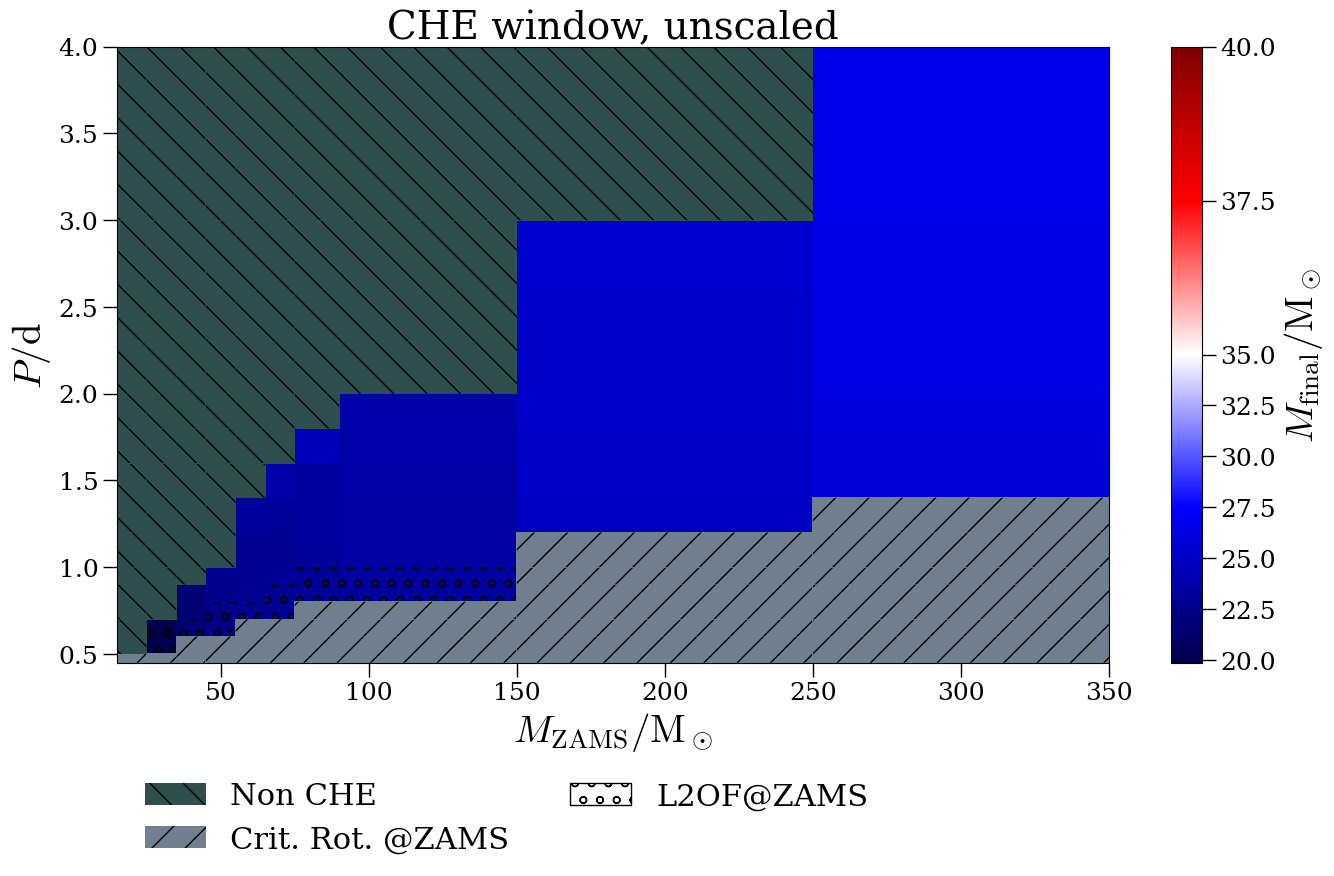

In [174]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.pcolormesh(color_m_arr, color_p_arr, color_mcore_arr, shading='flat')
ax.pcolor(color_m_arr, color_p_arr, zams_l2of_arr, hatch=l2of_hatch)
ax.pcolor(hatch_crit_m_arr, hatch_crit_p_arr, hatch_crit_mcore_arr, alpha=0., hatch=crit_hatch)
ax.pcolor(hatch_nonche_m_arr, hatch_nonche_p_arr, hatch_nonche_mcore_arr, alpha=0., hatch=nonche_hatch)

ax.set_xlabel('$M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
ax.set_ylabel('$P/\\mathrm{d}$')

sm = ScalarMappable(norm=mcore_norm, cmap=cmap)
cb = fig.colorbar(sm, ax=ax)
cb.set_label('$M_\\mathrm{final}/\\mathrm{M}_\\odot$')

handles = []
handles.append(Patch(facecolor=nonche_c, hatch=nonche_hatch, label='Non CHE'))
handles.append(Patch(facecolor=crit_c, hatch=crit_hatch, label='Crit. Rot. @ZAMS'))
handles.append(Patch(facecolor='w', hatch=l2of_hatch, label='L2OF@ZAMS', edgecolor='k'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(0, -0.15), ncol=2)

ax.set_title('CHE window, unscaled')

savefig(fig, 'che_window_unscaled')

In [175]:
def mass_forward(m):
    return m**-2.35

def mass_inverse(m):
    return m**(-1/2.35)

/tmp/ipykernel_2528056/1587637377.py:2: RuntimeWarning: divide by zero encountered in power
  return m**-2.35
/tmp/ipykernel_2528056/1587637377.py:2: RuntimeWarning: divide by zero encountered in power
  return m**-2.35


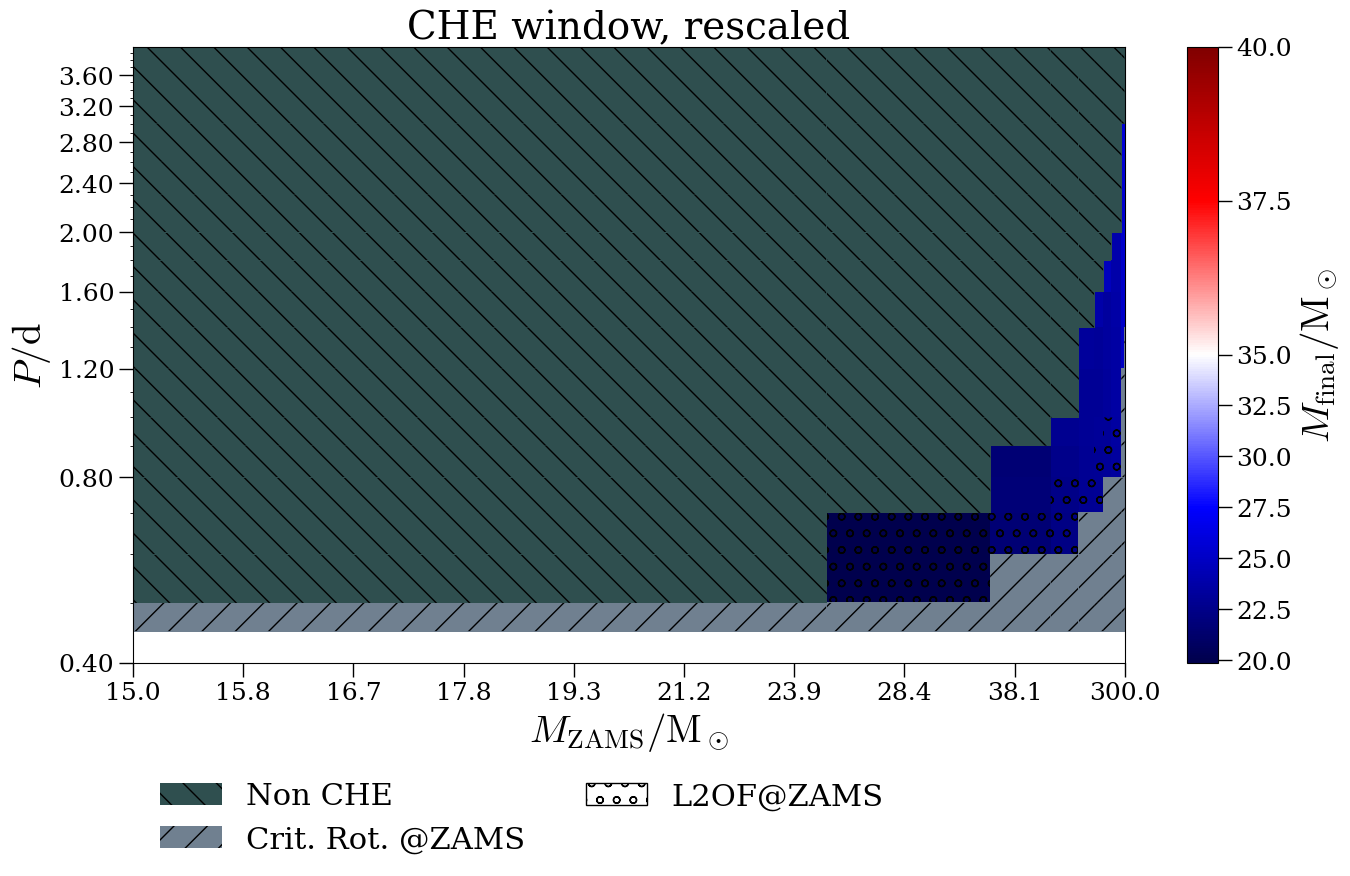

In [176]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.pcolormesh(color_m_arr, color_p_arr, color_mcore_arr, shading='flat')
ax.pcolor(color_m_arr, color_p_arr, zams_l2of_arr, hatch=l2of_hatch)
ax.pcolor(hatch_crit_m_arr, hatch_crit_p_arr, hatch_crit_mcore_arr, alpha=0., hatch=crit_hatch)
ax.pcolor(hatch_nonche_m_arr, hatch_nonche_p_arr, hatch_nonche_mcore_arr, alpha=0., hatch=nonche_hatch)

ax.set_xlabel('$M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
ax.set_ylabel('$P/\\mathrm{d}$')

sm = ScalarMappable(norm=mcore_norm, cmap=cmap)
cb = fig.colorbar(sm, ax=ax)
cb.set_label('$M_\\mathrm{final}/\\mathrm{M}_\\odot$')

handles = []
handles.append(Patch(facecolor=nonche_c, hatch=nonche_hatch, label='Non CHE'))
handles.append(Patch(facecolor=crit_c, hatch=crit_hatch, label='Crit. Rot. @ZAMS'))
handles.append(Patch(facecolor='w', hatch=l2of_hatch, label='L2OF@ZAMS', edgecolor='k'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(0, -0.15), ncol=2)

ax.set_yscale('log')
ax.set_xscale('function', functions=(mass_forward, mass_inverse))
ax.set_xticks([mass_inverse(x) for x in np.linspace(mass_forward(15), mass_forward(300), 10)])

ax.set_xlim(15, 310)
ax.invert_xaxis()

ax.set_yticks(np.arange(0.4, 4, 0.4))
ax.set_yticklabels([f'{p:.2f}' for p in np.arange(0.4, 4, 0.4)])
ax.set_yticks(np.arange(0.4, 4, 0.1), minor=True)
ax.set_yticklabels([], minor=True)

ax.set_title('CHE window, rescaled')

savefig(fig, 'che_window_rescaled')

/tmp/ipykernel_2528056/1587637377.py:2: RuntimeWarning: divide by zero encountered in power
  return m**-2.35


/tmp/ipykernel_2528056/1587637377.py:2: RuntimeWarning: divide by zero encountered in power
  return m**-2.35


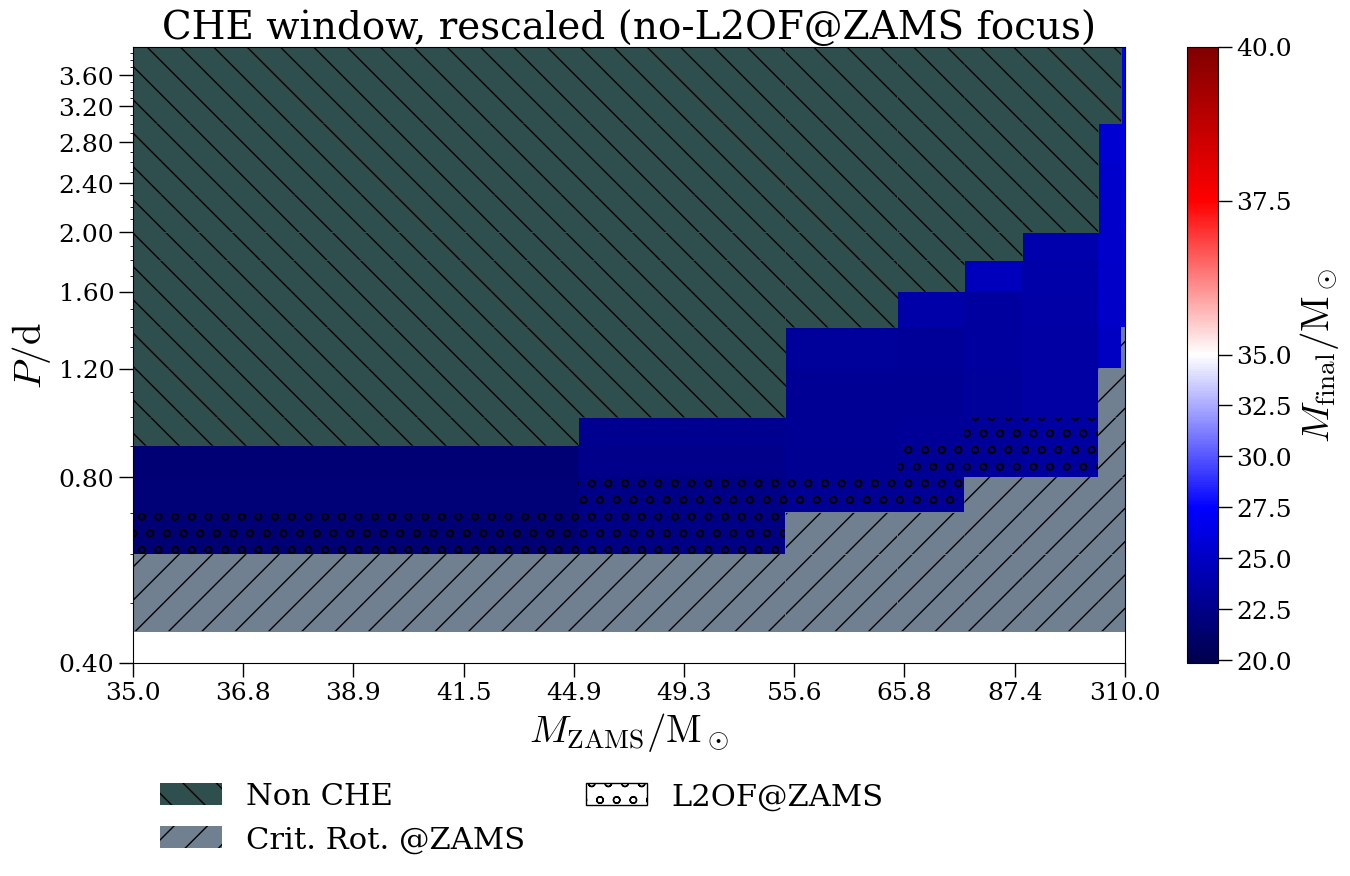

In [177]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.pcolormesh(color_m_arr, color_p_arr, color_mcore_arr, shading='flat')
ax.pcolor(color_m_arr, color_p_arr, zams_l2of_arr, hatch=l2of_hatch)
ax.pcolor(hatch_crit_m_arr, hatch_crit_p_arr, hatch_crit_mcore_arr, alpha=0., hatch=crit_hatch)
ax.pcolor(hatch_nonche_m_arr, hatch_nonche_p_arr, hatch_nonche_mcore_arr, alpha=0., hatch=nonche_hatch)

ax.set_xlabel('$M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
ax.set_ylabel('$P/\\mathrm{d}$')

sm = ScalarMappable(norm=mcore_norm, cmap=cmap)
cb = fig.colorbar(sm, ax=ax)
cb.set_label('$M_\\mathrm{final}/\\mathrm{M}_\\odot$')

handles = []
handles.append(Patch(facecolor=nonche_c, hatch=nonche_hatch, label='Non CHE'))
handles.append(Patch(facecolor=crit_c, hatch=crit_hatch, label='Crit. Rot. @ZAMS'))
handles.append(Patch(facecolor='w', hatch=l2of_hatch, label='L2OF@ZAMS', edgecolor='k'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(0, -0.15), ncol=2)

ax.set_yscale('log')
ax.set_xscale('function', functions=(mass_forward, mass_inverse))
ax.set_xticks([mass_inverse(x) for x in np.linspace(mass_forward(35), mass_forward(310), 10)])

ax.set_xlim(35, 310)
ax.invert_xaxis()

ax.set_yticks(np.arange(0.4, 4, 0.4))
ax.set_yticklabels([f'{p:.2f}' for p in np.arange(0.4, 4, 0.4)])
ax.set_yticks(np.arange(0.4, 4, 0.1), minor=True)
ax.set_yticklabels([], minor=True)

ax.set_title('CHE window, rescaled (no-L2OF@ZAMS focus)')

savefig(fig, 'che_window_rescaled_no_l2of')

In [178]:
interpolator_dict = dict()

for i, m in enumerate(mass_guide_float):
    m_key = mass_guide_str[i]
    p_arr = period_guide_float   
    y_arr = final_mass_array[:, i, 0] 
    r_arr = final_mass_array[:, i, 6] 

    mask = np.array(final_mass_array[:, i, 9], bool)
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]
    r_arr = r_arr[mask]
            
    if m_key in ['50.0']:
        y_arr = y_arr[1:]
        p_arr = p_arr[1:]
        r_arr = r_arr[1:]
        
    if m_key in ['40.0', '220.0']:
        y_arr = y_arr[:-1]
        p_arr = p_arr[:-1]
        r_arr = r_arr[:-1]
        
    mask = []
    for p0, rzams in zip(p_arr, r_arr):
        isof = is_of(rzams, float(m_key), p0, 1, kind='L2')
        if isof:
            mask.append(False)
        else:
            mask.append(True)
            
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]
    r_arr = r_arr[mask]
    
    if len(y_arr) == 0:
        y_arr = [nan]
        p_arr = [1]
        r_arr = [1]
    
    interpolator = interp1d(
        x=p_arr,
        y=y_arr,
        kind='linear',
        bounds_error=False,
        fill_value=nan
        )

    interpolator_dict[m_key] = interpolator     
    
l2_pzams_mcore_interpolator_dict = interpolator_dict

In [179]:
def l2_mzams_mcore_interpolator(m_zams, p_zams):
    ip_m_cores = []
    for m_key in mass_guide_str:
        interpolator = l2_pzams_mcore_interpolator_dict[m_key]
        ip_m_cores.append(interpolator(p_zams))
    
    interpolator = interp1d(
        x=mass_guide_float,
        y=ip_m_cores,
        kind='linear',
        bounds_error=False,
        fill_value='extrapolate'
    )
    
    m_core = interpolator(m_zams)
    
    return m_core  

In [180]:
interpolator_dict = dict()

for i, m in enumerate(mass_guide_float):
    m_key = mass_guide_str[i]
    p_arr = period_guide_float   
    y_arr = final_mass_array[:, i, 6] 
    r_arr = final_mass_array[:, i, 6] 
    
    mask = np.array(final_mass_array[:, i, 9], bool)
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]
    r_arr = r_arr[mask]

    if m_key in ['280.0', '220.0', '160.0', '50.0', '80.0']:
        p_arr = p_arr[1:]
        y_arr = y_arr[1:]
        r_arr = r_arr[1:]
 
    mask = []
    for p0, rzams in zip(p_arr, r_arr):
        isof = is_of(rzams, float(m_key), p0, 1, kind='L2')
        if isof:
            mask.append(False)
        else:
            mask.append(True)
    
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]
    r_arr = r_arr[mask]
    
    if len(y_arr) == 0:
        y_arr = [nan]
        p_arr = [1]
        r_arr = [1]
    
    interpolator = interp1d(
        x=p_arr,
        y=y_arr,
        kind='linear',
        bounds_error=False,
        fill_value=nan
        )

    interpolator_dict[m_key] = interpolator     
    
l2_pzams_rzams_interpolator_dict = interpolator_dict

In [181]:
def l2_mzams_rzams_interpolator(m_zams, p_zams):
    ip_m_cores = []
    for m_key in mass_guide_str:
        interpolator = l2_pzams_rzams_interpolator_dict[m_key]
        ip_m_cores.append(interpolator(p_zams))
    
    interpolator = interp1d(
        x=mass_guide_float,
        y=ip_m_cores,
        kind='linear',
        bounds_error=False,
        fill_value=nan
    )
    
    m_core = interpolator(m_zams)
    
    return m_core      

In [182]:
def draw_mass_sample(
    res=int(1e8),
    min_m=20,
    max_m=300,
    min_p=0.1,
    max_p=4,
    min_mfinal=20,
    max_mfinal=50,
    mfinal_bin_width=0.2
):
    sample_masses = np.linspace(min_m, max_m, res)
    sample_probs = sample_masses**-2.3/np.sum(sample_masses**-2.3)
    sample_masses = np.random.choice(sample_masses, p=sample_probs, size=int(res/100))

    sample_periods = np.linspace(np.log10(min_p), np.log10(max_p), res)
    sample_probs = np.ones(res)/res
    sample_periods = 10.**np.random.choice(sample_periods, p=sample_probs, size=int(res/100))

    sample_zams_rs = np.array([l2_mzams_rzams_interpolator(m, p) for m, p in zip(sample_masses, sample_periods)])

    sample_mcores = np.zeros(int(res/100))

    sample_ = np.array([sample_masses, sample_periods, sample_zams_rs, sample_mcores]).T
    zams_l2of_sample = set_mcores(sample_).copy()
    
    mass_draw = zams_l2of_sample[:, 3]
    mass_draw = mass_draw[~np.isnan(mass_draw)]

    bins = np.arange(min_mfinal, max_mfinal+mfinal_bin_width, mfinal_bin_width)
    hist, bins = np.histogram(mass_draw, density=True, bins=bins)
    centers = np.array([(bin0+bin1)/2 for bin0, bin1 in zip(bins[:-1], bins[1:])])
    mode = centers[np.argmax(hist)]
    
    return zams_l2of_sample, mode

In [183]:
from multiprocessing import Pool
from scipy.stats import mode

In [184]:
result01 = draw_mass_sample(res=int(1e7))

In [185]:
result = result01

Text(0.98, 0.98, 'Stopping condition: central_c12<=1e-6\nSome models start core Ne burning')

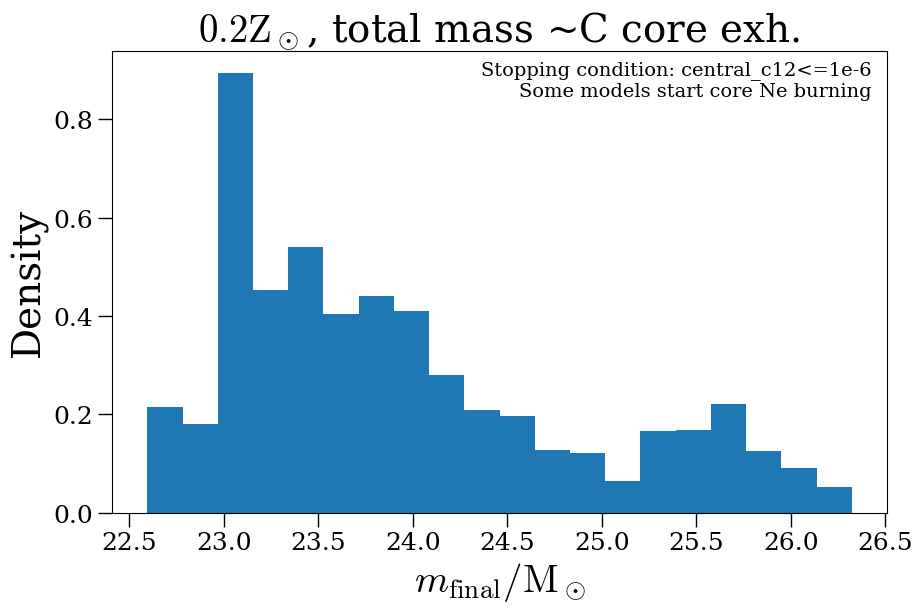

In [186]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(result[0][:,3], density=True, bins=20)

#ax.vlines(35, 0, 0.3, color='k', lw=0.5)
#ax.set_ylim(0, 0.25)
#ax.set_xlim(30, 45)
#ax.set_xticks(np.arange(30, 50, 2.5))

ax.set_ylabel('Density')
ax.set_xlabel('$m_\\mathrm{final}/\mathrm{M}_\odot$')
ax.set_title('$0.2\\mathrm{Z}_\\odot$, total mass ~C core exh.')

note = '\n'.join(('Stopping condition: central_c12<=1e-6',
                  'Some models start core Ne burning'))
ax.text(0.98, 
        0.98, 
        note,
        transform=ax.transAxes,
        ha='right',
        va='top',
        fontsize=14
        )


## $0.4\mathrm{Z}_\odot$

In [187]:
#np.save(f'nb{nb_id}_p_plot_extended.npy', p_plot)
final_mass_array = np.load('02_enhanced_w_core_props.npy')

In [188]:
# Select models
models_to_plot = np.arange(0, len(model_dicts), 1)
model_dict_list = model_dicts[models_to_plot]
print(f'Loading {model_dict_list}')

# Collect periods
all_periods = []
for dict_ in model_dict_list:
    for k1 in dict_.keys():
        for k2 in dict_[k1].keys():
            all_periods.append(k2)
all_periods = np.unique(all_periods)
all_periods = all_periods[np.argsort([float(p) for p in all_periods])][1:]
print(all_periods)

Loading [{'20.0': {'2.60': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/04_ZdivZsun_8d-1/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_p2.600d+00_w2.797d-05'), '4.00': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/04_ZdivZsun_8d-1/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_p4.000d+00_w1.818d-05'), '0.40': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/04_ZdivZsun_8d-1/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_p4.000d-01_w1.818d-04'), '2.00': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/04_ZdivZsun_8d-1/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_p2.000d+00_w3.636d-05'), '0.70': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/04_ZdivZsun_8d-1/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_p7.000d-01_w1.039d-04'), '1.60': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/04_ZdivZsun_8d-1/001_md1_m20

In [189]:
mass_guide_str = [list(dict_.keys())[0] for dict_ in model_dict_list]
mass_guide_float = np.array([float(m) for m in mass_guide_str])

period_guide_str = all_periods
period_guide_float = np.array([float(p) for p in period_guide_str])

In [190]:
from scipy.interpolate import interp1d

In [191]:
from math import nan

### Core mass plane

In [192]:
stage_index = dict(zams=6, prezams=7)

In [193]:
def mzams_p0_mcore_of_plot(ax, of_when, of_kind, min_mcore=20, max_mcore=50):    
    of_when_i = stage_index[of_when]
    handles = []
    for i, m_key in enumerate(mass_guide_str):
        c = cm.jet(i/len(mass_guide_str))
        handles.append(ax.scatter([], [], c=c, marker='o', label=m_key))
        m_zams = float(m_key)
        
        #che_mask = np.array(final_mass_array[:,i,9], bool)
        pp = period_guide_float#[che_mask]
        mm = final_mass_array[:,i,0]#[che_mask]
        rr = final_mass_array[:,i,of_when_i]#[che_mask]
        is_che = np.array(final_mass_array[:,i,9], bool)
        is_crit = np.array(final_mass_array[:,i,8], bool)
        
        for p, r, m_core, ische, iscrit in zip(pp, rr, mm, is_che, is_crit):
            if iscrit:
                marker = 'x'
                color = 'k'
            elif not ische:
                marker = '+'
                color = 'k'
            else:
                marker = 'o'
                color = cm.jet_r((np.log10(m_core)-np.log10(min_mcore))/(np.log10(max_mcore)-np.log10(min_mcore)))
            isof = is_of(r, m_zams, p, 1, kind=of_kind)
            if isof:
                alpha = 0.3
            else:
                alpha = 1.0
            ax.scatter(m_zams, p, marker=marker, color=color, zorder=1, s=30, alpha=alpha)
    return ax, handles

In [194]:
def p0_mcore_mzams_of_plot(ax, of_when, of_kind):
    of_when_i = stage_index[of_when]
    handles = []
    for i, m_key in enumerate(mass_guide_str):
        c = cm.jet(i/len(mass_guide_str))
        handles.append(ax.scatter([], [], c=c, marker='o', label=m_key))
        m_zams = float(m_key)
        
        che_mask = np.array(final_mass_array[:,i,9], bool)
        pp = period_guide_float[che_mask]
        mm = final_mass_array[:,i,3][che_mask]
        rr = final_mass_array[:,i,of_when_i][che_mask]
            
        for p, r, m_core in zip(pp, rr, mm):
            isof = is_of(r, m_zams, p, 1, kind=of_kind)
            if isof:
                ax.scatter(p, m_core, marker='x', color=c, zorder=1, s=30, alpha=0.3)
                pass
            else:
                ax.scatter(p, m_core, marker='o', color=c, zorder=1, s=30)
    return ax, handles

In [195]:
def is_of(r, m, p, q=1, kind='RL'):
    a = a_from_p(p, m, q)
    if kind == 'merger':
        of_a = a.to(u.Rsun).value
    elif kind == 'RL':
        of_a = eggleton_rl1_radius(a, q).to(u.Rsun).value
    elif kind == 'L2':
        of_a = marchant_l2_radius(a, q).to(u.Rsun).value
    elif kind == 'none':
        of_a = np.inf
    else:
        raise ValueError(f'kind {kind} not recognized')
    if of_a <= r:
        isof = True
    else:
        isof = False

    return isof

/tmp/ipykernel_2528056/1573620867.py:2: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0, hspace=0)
/tmp/ipykernel_2528056/3646536049.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handles.append(ax.scatter([], [], c=c, marker='o', label=m_key))


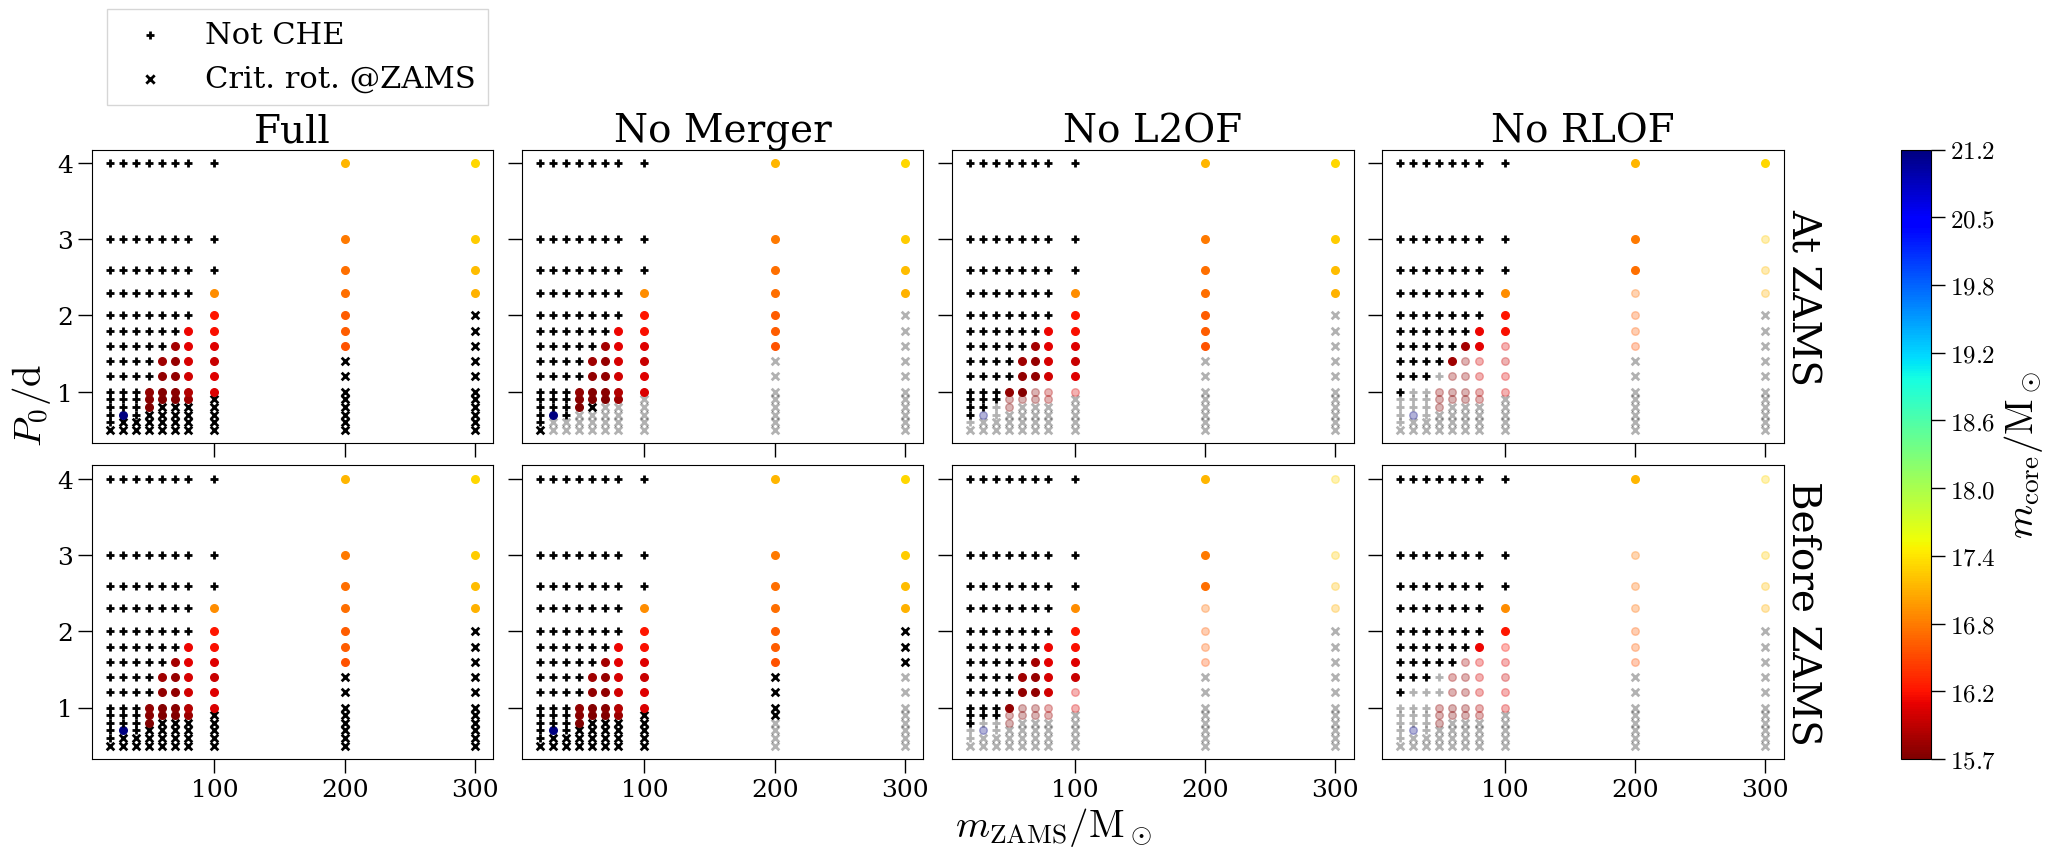

In [196]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey=True, layout='constrained')
fig.subplots_adjust(wspace=0, hspace=0)

plot_ps = np.linspace(0, 4, 100)

min_mcore = final_mass_array[:, :, 0][np.array(final_mass_array[:, :, 9], bool)].min()
max_mcore = final_mass_array[:, :, 0][np.array(final_mass_array[:, :, 9], bool)].max()

# AT ZAMS
of_when = 'zams'

of_kind = 'none'
ax = axes[0, 0]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)
ax.set_title('Full')                

of_kind = 'merger'
ax = axes[0, 1]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)
ax.set_title('No Merger')                

of_kind = 'L2'
ax = axes[0, 2]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)
ax.set_title('No L2OF')                

of_kind = 'RL'
ax = axes[0, 3]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)
ax.set_title('No RLOF')                

# AT ZAMS
of_when = 'prezams'

of_kind = 'none'
ax = axes[1, 0]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)

of_kind = 'merger'
ax = axes[1, 1]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)  

of_kind = 'L2'
ax = axes[1, 2]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)
             
of_kind = 'RL'
ax = axes[1, 3]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)
           
fig.text(0, 0.5, '$P_0/\\mathrm{d}$', rotation=90, ha='right', va='center')
fig.text(0.5, 0, '$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$', ha='center', va='top')
axes[0, 3].text(1, 0.5, 'At ZAMS', rotation=-90, ha='left', va='center', transform=axes[0, 3].transAxes)
axes[1, 3].text(1, 0.5, 'Before ZAMS', rotation=-90, ha='left', va='center', transform=axes[1, 3].transAxes)

sm = ScalarMappable(Normalize(vmin=np.log10(min_mcore), vmax=np.log10(max_mcore)), cm.jet_r)
cbar = fig.colorbar(sm, ax=axes[:,3], pad=0.2)
cbar.set_label('$m_\\mathrm{core}/\\mathrm{M}_\\odot$')
cbar.set_ticks(np.linspace(np.log10(min_mcore), np.log10(max_mcore), 10))
cbar.set_ticklabels([f'${10**logm:.1f}$' for logm in np.linspace(np.log10(min_mcore), np.log10(max_mcore), 10)])

handles = []
handles.append(ax.scatter([], [], marker='+', color='k', label='Not CHE'))
handles.append(ax.scatter([], [], marker='x', color='k', label='Crit. rot. @ZAMS'))
axes[0,0].legend(handles=handles, fancybox=False, loc='lower left', bbox_to_anchor=(0, 1.1))

#savefig(fig, 'che_window_02zsun')

In [197]:
min_mcore = final_mass_array[:, :, 0][np.array(final_mass_array[:, :, 9], bool)].min()
max_mcore = final_mass_array[:, :, 0][np.array(final_mass_array[:, :, 9], bool)].max()
mcore_norm = TwoSlopeNorm(vmin=min(30, min_mcore), vmax=max(max_mcore, 40), vcenter=35.)
nonche_c = to_rgba('darkslategrey')
crit_c = to_rgba('slategrey')
cmap = cm.seismic
def mcore_cmap(x): return cmap(mcore_norm(x))

In [198]:
m_arr = np.zeros(len(mass_guide_float)+1)
p_arr = np.zeros(len(period_guide_float)+1)
mcore_arr = np.zeros((len(mass_guide_float), len(period_guide_float), 4))
zams_l2of_arr = np.zeros((len(mass_guide_float), len(period_guide_float), 4))

for i_m, m1 in enumerate(mass_guide_float):
    if i_m == 0:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        bin_lower_m = m1 - (bin_upper_m-m1)
    elif i_m < len(mass_guide_float)-1:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
    else:
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
        bin_upper_m = m1 + (m1-bin_lower_m)
    m_arr[i_m] = bin_lower_m
    m_arr[i_m+1] = bin_upper_m
    
    for i_p, p1 in enumerate(period_guide_float):
        if i_p == 0:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = p1 - (bin_upper_p-p1)
        elif i_p < len(period_guide_float)-1:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (p0+p1)/2
        else:
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (p0+p1)/2
            m2 = m1 + (m1-bin_lower_p)
        p_arr[i_p] = p0
        p_arr[i_p+1] = p2
        
        mcore = final_mass_array[i_p, i_m, 0]
        ische = final_mass_array[i_p, i_m, 9]
        iscrit = final_mass_array[i_p, i_m, 8]
        if ische:
            mcore_arr[i_m, i_p, :] = mcore_cmap(mcore)
        elif iscrit: 
            mcore_arr[i_m, i_p, :] = crit_c
        else:
            mcore_arr[i_m, i_p, :] = nonche_c

        rzams = final_mass_array[i_p, i_m, 6]
        is_l2of = is_of(r=rzams, m=m1, p=p1, q=1, kind='L2')
        if is_l2of:
            zams_l2of_arr[i_m, i_p, :] = [0, 0, 0, 0]
        else:
            zams_l2of_arr[i_m, i_p, :] = 4*[nan]
            
m_arr = np.tile(m_arr, [len(period_guide_float)+1, 1]).T
p_arr = np.tile(p_arr, [len(mass_guide_float)+1, 1])

color_mcore_arr = mcore_arr
color_m_arr = m_arr
color_p_arr = p_arr

In [199]:
m_arr = np.zeros(len(mass_guide_float)+1)
p_arr = np.zeros(len(period_guide_float)+1)
mcore_arr = np.zeros((len(mass_guide_float), len(period_guide_float), 4))
che_mask = np.ones((len(mass_guide_float)+1, len(period_guide_float)+1), bool)

for i_m, m1 in enumerate(mass_guide_float):
    if i_m == 0:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        bin_lower_m = m1 - (bin_upper_m-m1)
    elif i_m < len(mass_guide_float)-1:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
    else:
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
        bin_upper_m = m1 + (m1-bin_lower_m)
    m_arr[i_m] = bin_lower_m
    m_arr[i_m+1] = bin_upper_m
    
    for i_p, p1 in enumerate(period_guide_float):
        if i_p == 0:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = p1 - (bin_upper_p-p1)
        elif i_p < len(period_guide_float)-1:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (p0+p1)/2
        else:
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (m0+m1)/2
            m2 = m1 + (m1-bin_lower_p)
        p_arr[i_p] = p0
        p_arr[i_p+1] = p2
        
        mcore = final_mass_array[i_p, i_m, 0]
        ische = final_mass_array[i_p, i_m, 9]
        iscrit = final_mass_array[i_p, i_m, 8]
        if ische:
            mcore_arr[i_m, i_p, :] = 4*[nan]
            che_mask[i_m, i_p] = True
        elif iscrit: 
            mcore_arr[i_m, i_p, :] = crit_c
            che_mask[i_m, i_p] = False
        else:
            mcore_arr[i_m, i_p, :] = 4*[nan]
            che_mask[i_m, i_p] = False
            
m_arr = np.tile(m_arr, [len(period_guide_float)+1, 1]).T
p_arr = np.tile(p_arr, [len(mass_guide_float)+1, 1])

hatch_crit_mcore_arr = mcore_arr
hatch_crit_m_arr = m_arr
hatch_crit_p_arr = p_arr

In [200]:
m_arr = np.zeros(len(mass_guide_float)+1)
p_arr = np.zeros(len(period_guide_float)+1)
mcore_arr = np.zeros((len(mass_guide_float), len(period_guide_float), 4))
che_mask = np.ones((len(mass_guide_float)+1, len(period_guide_float)+1), bool)

for i_m, m1 in enumerate(mass_guide_float):
    if i_m == 0:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        bin_lower_m = m1 - (bin_upper_m-m1)
    elif i_m < len(mass_guide_float)-1:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
    else:
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
        bin_upper_m = m1 + (m1-bin_lower_m)
    m_arr[i_m] = bin_lower_m
    m_arr[i_m+1] = bin_upper_m
    
    for i_p, p1 in enumerate(period_guide_float):
        if i_p == 0:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = p1 - (bin_upper_p-p1)
        elif i_p < len(period_guide_float)-1:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (p0+p1)/2
        else:
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (m0+m1)/2
            m2 = m1 + (m1-bin_lower_p)
        p_arr[i_p] = p0
        p_arr[i_p+1] = p2
        
        mcore = final_mass_array[i_p, i_m, 0]
        ische = final_mass_array[i_p, i_m, 9]
        iscrit = final_mass_array[i_p, i_m, 8]
        if ische:
            mcore_arr[i_m, i_p, :] = 4*[nan]
            che_mask[i_m, i_p] = True
        elif iscrit: 
            mcore_arr[i_m, i_p, :] = 4*[nan]
            che_mask[i_m, i_p] = False
        else:
            mcore_arr[i_m, i_p, :] = nonche_c
            che_mask[i_m, i_p] = False
            
m_arr = np.tile(m_arr, [len(period_guide_float)+1, 1]).T
p_arr = np.tile(p_arr, [len(mass_guide_float)+1, 1])

hatch_nonche_mcore_arr = mcore_arr
hatch_nonche_m_arr = m_arr
hatch_nonche_p_arr = p_arr

In [201]:
nonche_hatch = '\\'
crit_hatch = '/'
l2of_hatch = 'o'

In [202]:
from matplotlib.patches import Patch

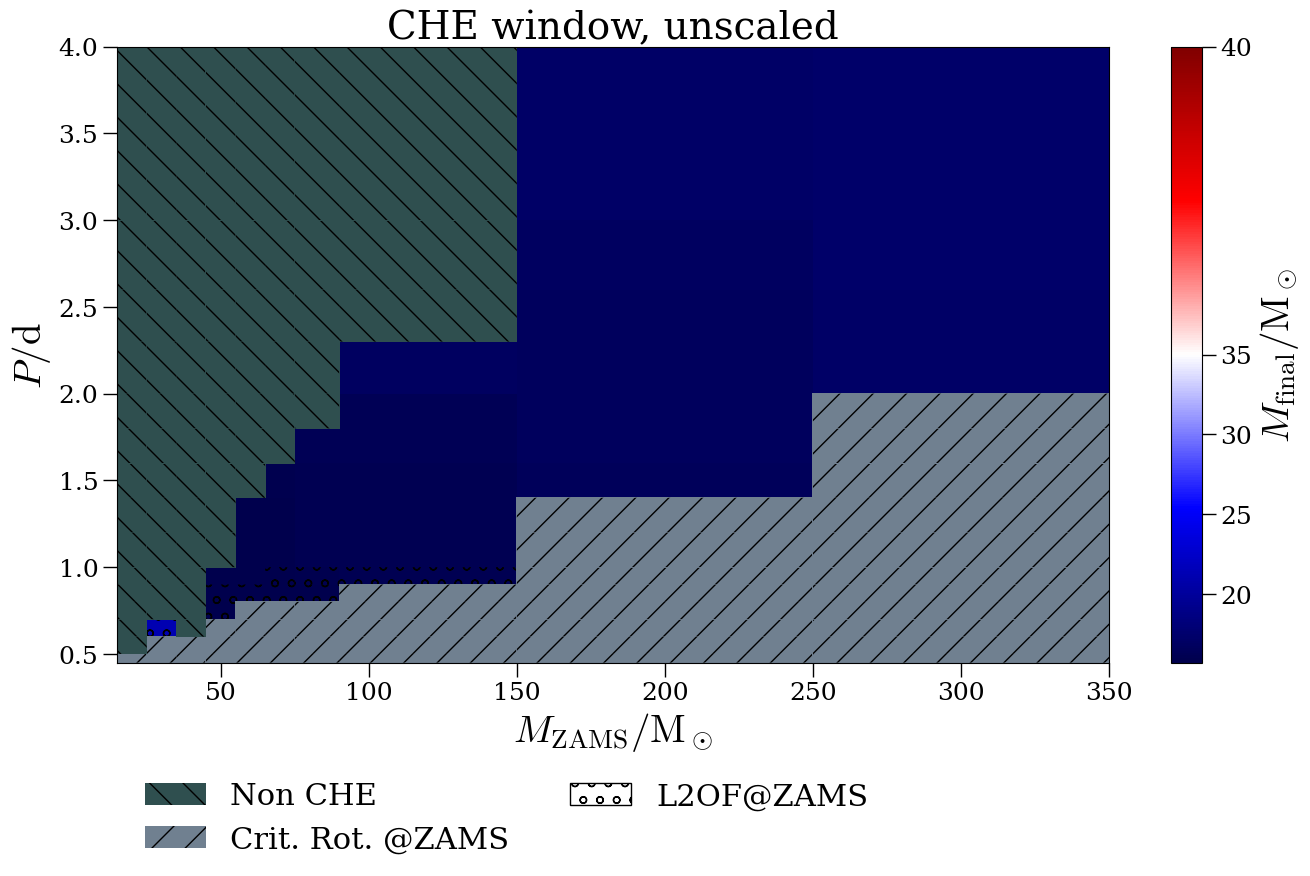

In [203]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.pcolormesh(color_m_arr, color_p_arr, color_mcore_arr, shading='flat')
ax.pcolor(color_m_arr, color_p_arr, zams_l2of_arr, hatch=l2of_hatch)
ax.pcolor(hatch_crit_m_arr, hatch_crit_p_arr, hatch_crit_mcore_arr, alpha=0., hatch=crit_hatch)
ax.pcolor(hatch_nonche_m_arr, hatch_nonche_p_arr, hatch_nonche_mcore_arr, alpha=0., hatch=nonche_hatch)

ax.set_xlabel('$M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
ax.set_ylabel('$P/\\mathrm{d}$')

sm = ScalarMappable(norm=mcore_norm, cmap=cmap)
cb = fig.colorbar(sm, ax=ax)
cb.set_label('$M_\\mathrm{final}/\\mathrm{M}_\\odot$')

handles = []
handles.append(Patch(facecolor=nonche_c, hatch=nonche_hatch, label='Non CHE'))
handles.append(Patch(facecolor=crit_c, hatch=crit_hatch, label='Crit. Rot. @ZAMS'))
handles.append(Patch(facecolor='w', hatch=l2of_hatch, label='L2OF@ZAMS', edgecolor='k'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(0, -0.15), ncol=2)

ax.set_title('CHE window, unscaled')

savefig(fig, 'che_window_unscaled')

In [204]:
def mass_forward(m):
    return m**-2.35

def mass_inverse(m):
    return m**(-1/2.35)

/tmp/ipykernel_2528056/1587637377.py:2: RuntimeWarning: divide by zero encountered in power
  return m**-2.35


/tmp/ipykernel_2528056/1587637377.py:2: RuntimeWarning: divide by zero encountered in power
  return m**-2.35


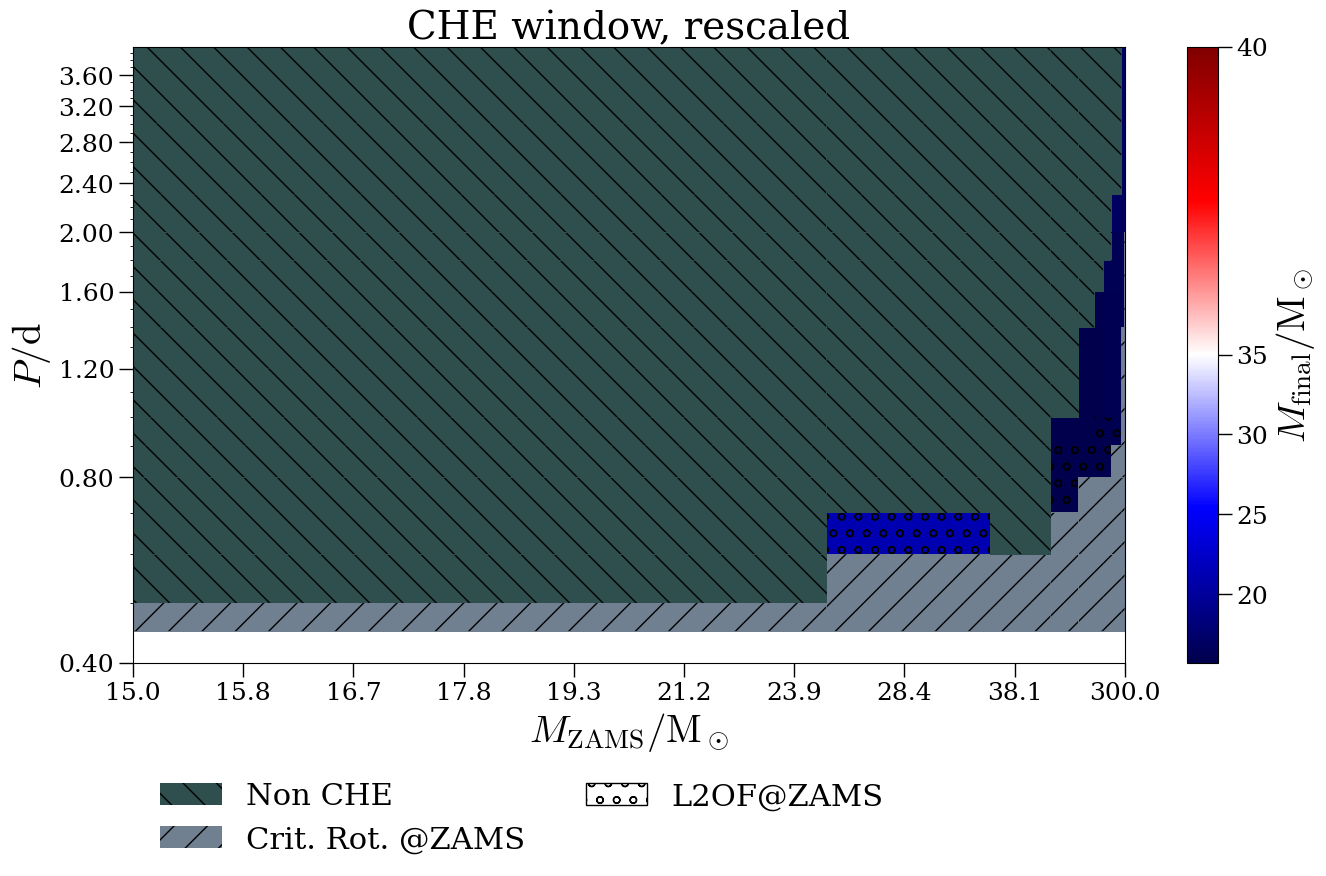

In [205]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.pcolormesh(color_m_arr, color_p_arr, color_mcore_arr, shading='flat')
ax.pcolor(color_m_arr, color_p_arr, zams_l2of_arr, hatch=l2of_hatch)
ax.pcolor(hatch_crit_m_arr, hatch_crit_p_arr, hatch_crit_mcore_arr, alpha=0., hatch=crit_hatch)
ax.pcolor(hatch_nonche_m_arr, hatch_nonche_p_arr, hatch_nonche_mcore_arr, alpha=0., hatch=nonche_hatch)

ax.set_xlabel('$M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
ax.set_ylabel('$P/\\mathrm{d}$')

sm = ScalarMappable(norm=mcore_norm, cmap=cmap)
cb = fig.colorbar(sm, ax=ax)
cb.set_label('$M_\\mathrm{final}/\\mathrm{M}_\\odot$')

handles = []
handles.append(Patch(facecolor=nonche_c, hatch=nonche_hatch, label='Non CHE'))
handles.append(Patch(facecolor=crit_c, hatch=crit_hatch, label='Crit. Rot. @ZAMS'))
handles.append(Patch(facecolor='w', hatch=l2of_hatch, label='L2OF@ZAMS', edgecolor='k'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(0, -0.15), ncol=2)

ax.set_yscale('log')
ax.set_xscale('function', functions=(mass_forward, mass_inverse))
ax.set_xticks([mass_inverse(x) for x in np.linspace(mass_forward(15), mass_forward(300), 10)])

ax.set_xlim(15, 310)
ax.invert_xaxis()

ax.set_yticks(np.arange(0.4, 4, 0.4))
ax.set_yticklabels([f'{p:.2f}' for p in np.arange(0.4, 4, 0.4)])
ax.set_yticks(np.arange(0.4, 4, 0.1), minor=True)
ax.set_yticklabels([], minor=True)

ax.set_title('CHE window, rescaled')

savefig(fig, 'che_window_rescaled')

/tmp/ipykernel_2528056/1587637377.py:2: RuntimeWarning: divide by zero encountered in power
  return m**-2.35
/tmp/ipykernel_2528056/1587637377.py:2: RuntimeWarning: divide by zero encountered in power
  return m**-2.35


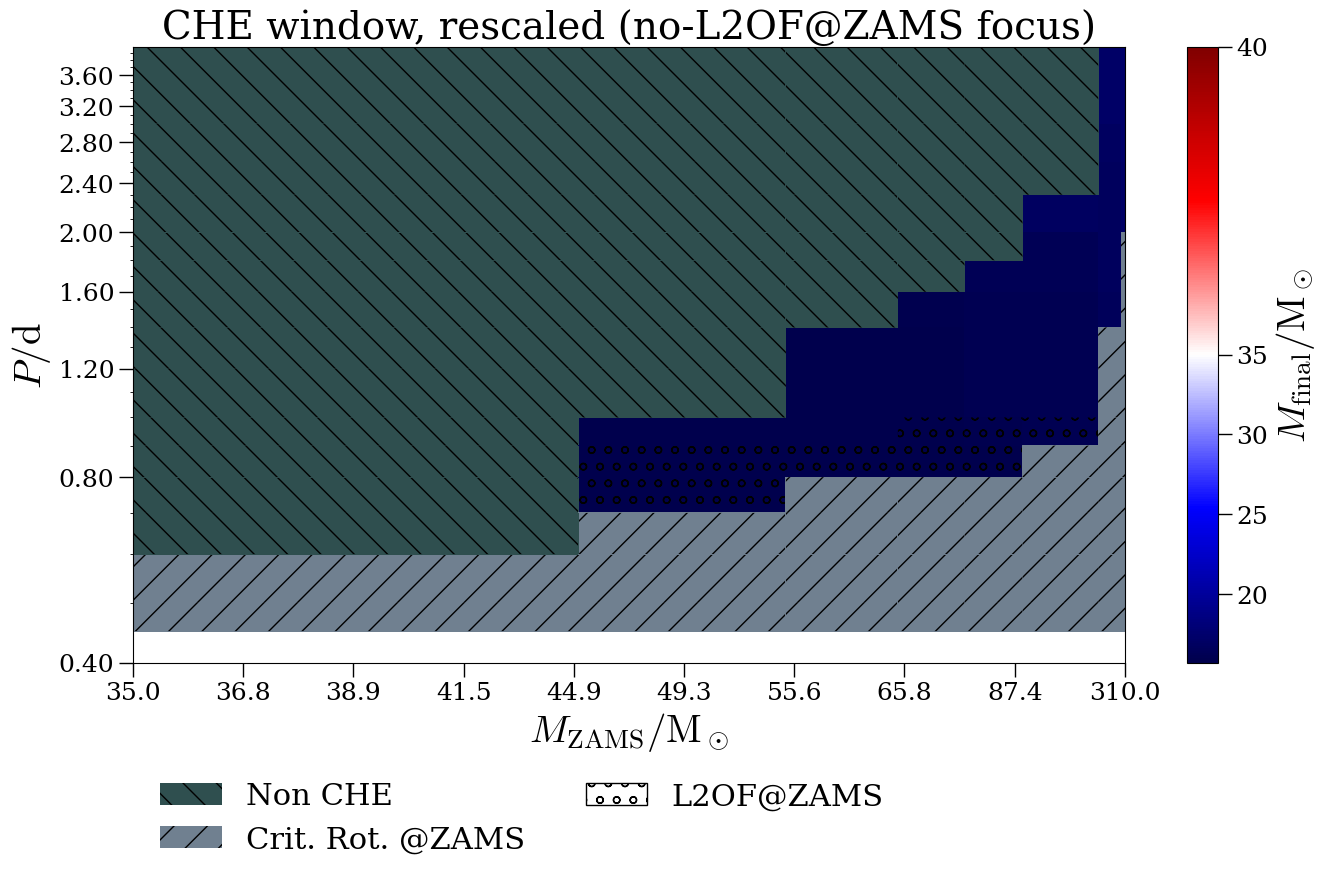

In [206]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.pcolormesh(color_m_arr, color_p_arr, color_mcore_arr, shading='flat')
ax.pcolor(color_m_arr, color_p_arr, zams_l2of_arr, hatch=l2of_hatch)
ax.pcolor(hatch_crit_m_arr, hatch_crit_p_arr, hatch_crit_mcore_arr, alpha=0., hatch=crit_hatch)
ax.pcolor(hatch_nonche_m_arr, hatch_nonche_p_arr, hatch_nonche_mcore_arr, alpha=0., hatch=nonche_hatch)

ax.set_xlabel('$M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
ax.set_ylabel('$P/\\mathrm{d}$')

sm = ScalarMappable(norm=mcore_norm, cmap=cmap)
cb = fig.colorbar(sm, ax=ax)
cb.set_label('$M_\\mathrm{final}/\\mathrm{M}_\\odot$')

handles = []
handles.append(Patch(facecolor=nonche_c, hatch=nonche_hatch, label='Non CHE'))
handles.append(Patch(facecolor=crit_c, hatch=crit_hatch, label='Crit. Rot. @ZAMS'))
handles.append(Patch(facecolor='w', hatch=l2of_hatch, label='L2OF@ZAMS', edgecolor='k'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(0, -0.15), ncol=2)

ax.set_yscale('log')
ax.set_xscale('function', functions=(mass_forward, mass_inverse))
ax.set_xticks([mass_inverse(x) for x in np.linspace(mass_forward(35), mass_forward(310), 10)])

ax.set_xlim(35, 310)
ax.invert_xaxis()

ax.set_yticks(np.arange(0.4, 4, 0.4))
ax.set_yticklabels([f'{p:.2f}' for p in np.arange(0.4, 4, 0.4)])
ax.set_yticks(np.arange(0.4, 4, 0.1), minor=True)
ax.set_yticklabels([], minor=True)

ax.set_title('CHE window, rescaled (no-L2OF@ZAMS focus)')

savefig(fig, 'che_window_rescaled_no_l2of')

In [207]:
interpolator_dict = dict()

for i, m in enumerate(mass_guide_float):
    m_key = mass_guide_str[i]
    p_arr = period_guide_float   
    y_arr = final_mass_array[:, i, 0] 
    r_arr = final_mass_array[:, i, 6] 

    mask = np.array(final_mass_array[:, i, 9], bool)
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]
    r_arr = r_arr[mask]
            
    if m_key in ['50.0']:
        y_arr = y_arr[1:]
        p_arr = p_arr[1:]
        r_arr = r_arr[1:]
        
    if m_key in ['40.0', '220.0']:
        y_arr = y_arr[:-1]
        p_arr = p_arr[:-1]
        r_arr = r_arr[:-1]
        
    mask = []
    for p0, rzams in zip(p_arr, r_arr):
        isof = is_of(rzams, float(m_key), p0, 1, kind='L2')
        if isof:
            mask.append(False)
        else:
            mask.append(True)
            
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]
    r_arr = r_arr[mask]
    
    if len(y_arr) == 0:
        y_arr = [nan]
        p_arr = [1]
        r_arr = [1]
    
    interpolator = interp1d(
        x=p_arr,
        y=y_arr,
        kind='linear',
        bounds_error=False,
        fill_value=nan
        )

    interpolator_dict[m_key] = interpolator     
    
l2_pzams_mcore_interpolator_dict = interpolator_dict

In [208]:
def l2_mzams_mcore_interpolator(m_zams, p_zams):
    ip_m_cores = []
    for m_key in mass_guide_str:
        interpolator = l2_pzams_mcore_interpolator_dict[m_key]
        ip_m_cores.append(interpolator(p_zams))
    
    interpolator = interp1d(
        x=mass_guide_float,
        y=ip_m_cores,
        kind='linear',
        bounds_error=False,
        fill_value='extrapolate'
    )
    
    m_core = interpolator(m_zams)
    
    return m_core  

In [209]:
interpolator_dict = dict()

for i, m in enumerate(mass_guide_float):
    m_key = mass_guide_str[i]
    p_arr = period_guide_float   
    y_arr = final_mass_array[:, i, 6] 
    r_arr = final_mass_array[:, i, 6] 
    
    mask = np.array(final_mass_array[:, i, 9], bool)
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]
    r_arr = r_arr[mask]

    if m_key in ['280.0', '220.0', '160.0', '50.0', '80.0']:
        p_arr = p_arr[1:]
        y_arr = y_arr[1:]
        r_arr = r_arr[1:]
 
    mask = []
    for p0, rzams in zip(p_arr, r_arr):
        isof = is_of(rzams, float(m_key), p0, 1, kind='L2')
        if isof:
            mask.append(False)
        else:
            mask.append(True)
    
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]
    r_arr = r_arr[mask]
    
    if len(y_arr) == 0:
        y_arr = [nan]
        p_arr = [1]
        r_arr = [1]
    
    interpolator = interp1d(
        x=p_arr,
        y=y_arr,
        kind='linear',
        bounds_error=False,
        fill_value=nan
        )

    interpolator_dict[m_key] = interpolator     
    
l2_pzams_rzams_interpolator_dict = interpolator_dict

In [210]:
def l2_mzams_rzams_interpolator(m_zams, p_zams):
    ip_m_cores = []
    for m_key in mass_guide_str:
        interpolator = l2_pzams_rzams_interpolator_dict[m_key]
        ip_m_cores.append(interpolator(p_zams))
    
    interpolator = interp1d(
        x=mass_guide_float,
        y=ip_m_cores,
        kind='linear',
        bounds_error=False,
        fill_value=nan
    )
    
    m_core = interpolator(m_zams)
    
    return m_core      

In [211]:
def draw_mass_sample(
    res=int(1e8),
    min_m=20,
    max_m=300,
    min_p=0.1,
    max_p=4,
    min_mfinal=20,
    max_mfinal=50,
    mfinal_bin_width=0.2
):
    sample_masses = np.linspace(min_m, max_m, res)
    sample_probs = sample_masses**-2.3/np.sum(sample_masses**-2.3)
    sample_masses = np.random.choice(sample_masses, p=sample_probs, size=int(res/100))

    sample_periods = np.linspace(np.log10(min_p), np.log10(max_p), res)
    sample_probs = np.ones(res)/res
    sample_periods = 10.**np.random.choice(sample_periods, p=sample_probs, size=int(res/100))

    sample_zams_rs = np.array([l2_mzams_rzams_interpolator(m, p) for m, p in zip(sample_masses, sample_periods)])

    sample_mcores = np.zeros(int(res/100))

    sample_ = np.array([sample_masses, sample_periods, sample_zams_rs, sample_mcores]).T
    zams_l2of_sample = set_mcores(sample_).copy()
    
    mass_draw = zams_l2of_sample[:, 3]
    mass_draw = mass_draw[~np.isnan(mass_draw)]

    bins = np.arange(min_mfinal, max_mfinal+mfinal_bin_width, mfinal_bin_width)
    hist, bins = np.histogram(mass_draw, density=True, bins=bins)
    centers = np.array([(bin0+bin1)/2 for bin0, bin1 in zip(bins[:-1], bins[1:])])
    mode = centers[np.argmax(hist)]
    
    return zams_l2of_sample, mode

In [212]:
from multiprocessing import Pool
from scipy.stats import mode

In [213]:
result = draw_mass_sample(res=int(1e7))

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


In [214]:
result02 = draw_mass_sample(res=int(1e7))

In [215]:
result = result02

Text(0.98, 0.98, 'Stopping condition: central_c12<=1e-6\nSome models start core Ne burning')

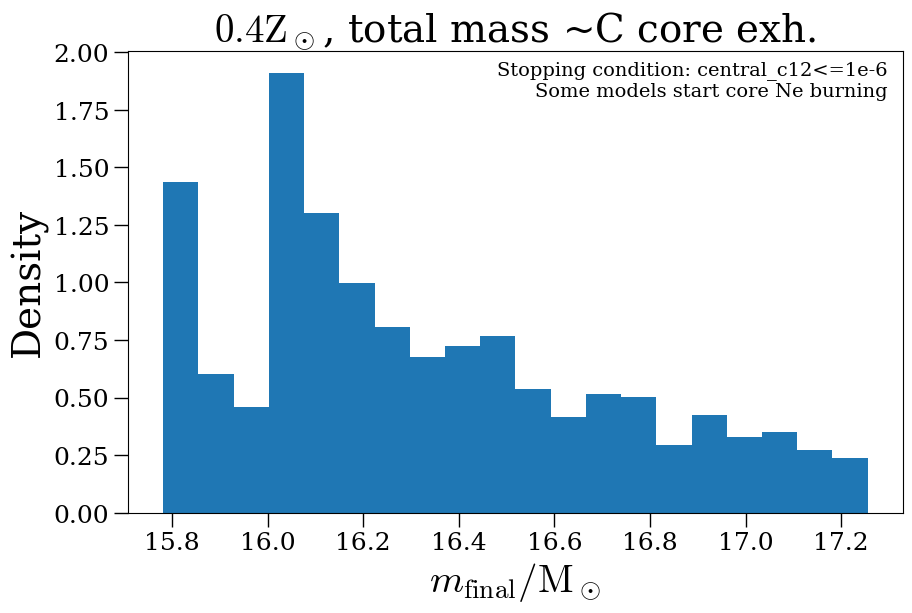

In [216]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(result[0][:,3], density=True, bins=20)

#ax.vlines(35, 0, 0.3, color='k', lw=0.5)
#ax.set_ylim(0, 0.25)
#ax.set_xlim(30, 45)
#ax.set_xticks(np.arange(30, 50, 2.5))

ax.set_ylabel('Density')
ax.set_xlabel('$m_\\mathrm{final}/\mathrm{M}_\odot$')
ax.set_title('$0.4\\mathrm{Z}_\\odot$, total mass ~C core exh.')

note = '\n'.join(('Stopping condition: central_c12<=1e-6',
                  'Some models start core Ne burning'))
ax.text(0.98, 
        0.98, 
        note,
        transform=ax.transAxes,
        ha='right',
        va='top',
        fontsize=14
        )


## $0.6\mathrm{Z}_\odot$

In [128]:
#np.save(f'nb{nb_id}_p_plot_extended.npy', p_plot)
final_mass_array = np.load('03_enhanced_w_core_props.npy')

In [129]:
# Select models
models_to_plot = np.arange(0, len(model_dicts), 1)
model_dict_list = model_dicts[models_to_plot]
print(f'Loading {model_dict_list}')

# Collect periods
all_periods = []
for dict_ in model_dict_list:
    for k1 in dict_.keys():
        for k2 in dict_[k1].keys():
            all_periods.append(k2)
all_periods = np.unique(all_periods)
all_periods = all_periods[np.argsort([float(p) for p in all_periods])][1:]
print(all_periods)

Loading [{'20.0': {'2.60': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/04_ZdivZsun_8d-1/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_p2.600d+00_w2.797d-05'), '4.00': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/04_ZdivZsun_8d-1/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_p4.000d+00_w1.818d-05'), '0.40': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/04_ZdivZsun_8d-1/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_p4.000d-01_w1.818d-04'), '2.00': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/04_ZdivZsun_8d-1/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_p2.000d+00_w3.636d-05'), '0.70': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/04_ZdivZsun_8d-1/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_p7.000d-01_w1.039d-04'), '1.60': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/04_ZdivZsun_8d-1/001_md1_m20

In [130]:
mass_guide_str = [list(dict_.keys())[0] for dict_ in model_dict_list]
mass_guide_float = np.array([float(m) for m in mass_guide_str])

period_guide_str = all_periods
period_guide_float = np.array([float(p) for p in period_guide_str])

In [131]:
from scipy.interpolate import interp1d

In [132]:
from math import nan

### Core mass plane

In [133]:
stage_index = dict(zams=6, prezams=7)

In [134]:
def mzams_p0_mcore_of_plot(ax, of_when, of_kind, min_mcore=20, max_mcore=50):    
    of_when_i = stage_index[of_when]
    handles = []
    for i, m_key in enumerate(mass_guide_str):
        c = cm.jet(i/len(mass_guide_str))
        handles.append(ax.scatter([], [], c=c, marker='o', label=m_key))
        m_zams = float(m_key)
        
        #che_mask = np.array(final_mass_array[:,i,9], bool)
        pp = period_guide_float#[che_mask]
        mm = final_mass_array[:,i,0]#[che_mask]
        rr = final_mass_array[:,i,of_when_i]#[che_mask]
        is_che = np.array(final_mass_array[:,i,9], bool)
        is_crit = np.array(final_mass_array[:,i,8], bool)
        
        for p, r, m_core, ische, iscrit in zip(pp, rr, mm, is_che, is_crit):
            if iscrit:
                marker = 'x'
                color = 'k'
            elif not ische:
                marker = '+'
                color = 'k'
            else:
                marker = 'o'
                color = cm.jet_r((np.log10(m_core)-np.log10(min_mcore))/(np.log10(max_mcore)-np.log10(min_mcore)))
            isof = is_of(r, m_zams, p, 1, kind=of_kind)
            if isof:
                alpha = 0.3
            else:
                alpha = 1.0
            ax.scatter(m_zams, p, marker=marker, color=color, zorder=1, s=30, alpha=alpha)
    return ax, handles

In [135]:
def p0_mcore_mzams_of_plot(ax, of_when, of_kind):
    of_when_i = stage_index[of_when]
    handles = []
    for i, m_key in enumerate(mass_guide_str):
        c = cm.jet(i/len(mass_guide_str))
        handles.append(ax.scatter([], [], c=c, marker='o', label=m_key))
        m_zams = float(m_key)
        
        che_mask = np.array(final_mass_array[:,i,9], bool)
        pp = period_guide_float[che_mask]
        mm = final_mass_array[:,i,3][che_mask]
        rr = final_mass_array[:,i,of_when_i][che_mask]
            
        for p, r, m_core in zip(pp, rr, mm):
            isof = is_of(r, m_zams, p, 1, kind=of_kind)
            if isof:
                ax.scatter(p, m_core, marker='x', color=c, zorder=1, s=30, alpha=0.3)
                pass
            else:
                ax.scatter(p, m_core, marker='o', color=c, zorder=1, s=30)
    return ax, handles

In [136]:
def is_of(r, m, p, q=1, kind='RL'):
    a = a_from_p(p, m, q)
    if kind == 'merger':
        of_a = a.to(u.Rsun).value
    elif kind == 'RL':
        of_a = eggleton_rl1_radius(a, q).to(u.Rsun).value
    elif kind == 'L2':
        of_a = marchant_l2_radius(a, q).to(u.Rsun).value
    elif kind == 'none':
        of_a = np.inf
    else:
        raise ValueError(f'kind {kind} not recognized')
    if of_a <= r:
        isof = True
    else:
        isof = False

    return isof

/tmp/ipykernel_2528056/1573620867.py:2: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0, hspace=0)
/tmp/ipykernel_2528056/3646536049.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handles.append(ax.scatter([], [], c=c, marker='o', label=m_key))


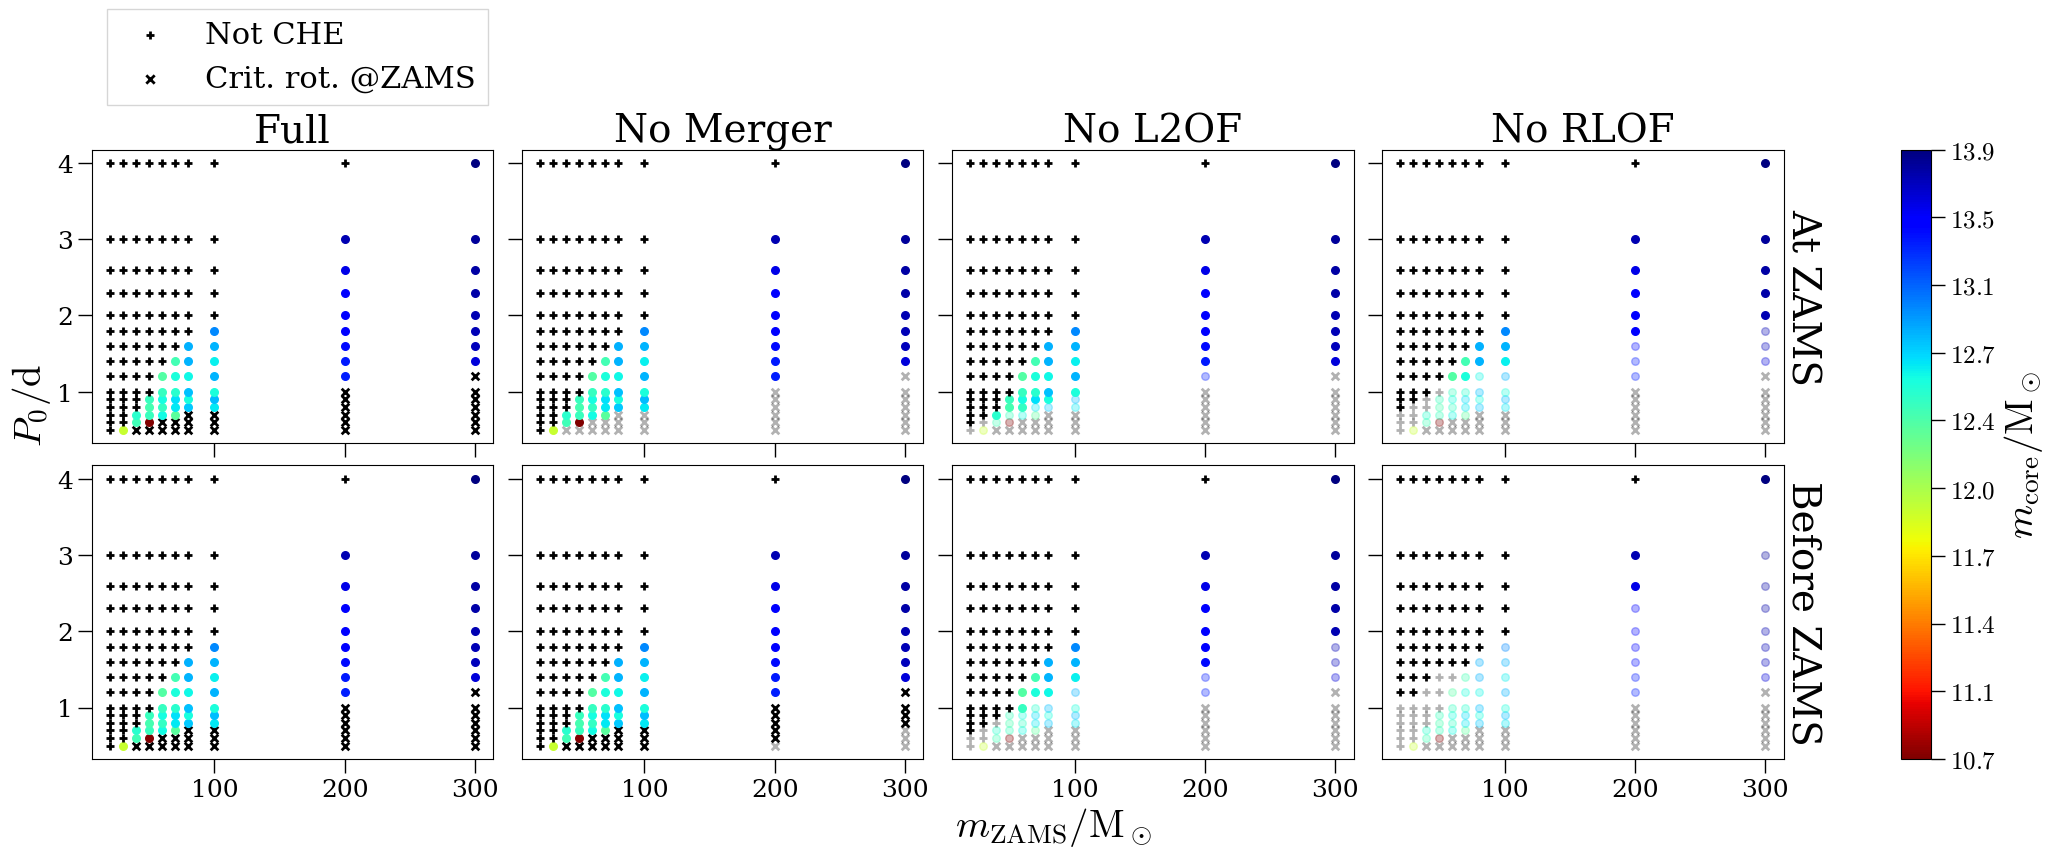

In [137]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey=True, layout='constrained')
fig.subplots_adjust(wspace=0, hspace=0)

plot_ps = np.linspace(0, 4, 100)

min_mcore = final_mass_array[:, :, 0][np.array(final_mass_array[:, :, 9], bool)].min()
max_mcore = final_mass_array[:, :, 0][np.array(final_mass_array[:, :, 9], bool)].max()

# AT ZAMS
of_when = 'zams'

of_kind = 'none'
ax = axes[0, 0]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)
ax.set_title('Full')                

of_kind = 'merger'
ax = axes[0, 1]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)
ax.set_title('No Merger')                

of_kind = 'L2'
ax = axes[0, 2]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)
ax.set_title('No L2OF')                

of_kind = 'RL'
ax = axes[0, 3]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)
ax.set_title('No RLOF')                

# AT ZAMS
of_when = 'prezams'

of_kind = 'none'
ax = axes[1, 0]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)

of_kind = 'merger'
ax = axes[1, 1]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)  

of_kind = 'L2'
ax = axes[1, 2]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)
             
of_kind = 'RL'
ax = axes[1, 3]
ax, handles = mzams_p0_mcore_of_plot(ax, of_when=of_when, of_kind=of_kind, min_mcore=min_mcore, max_mcore=max_mcore)
           
fig.text(0, 0.5, '$P_0/\\mathrm{d}$', rotation=90, ha='right', va='center')
fig.text(0.5, 0, '$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$', ha='center', va='top')
axes[0, 3].text(1, 0.5, 'At ZAMS', rotation=-90, ha='left', va='center', transform=axes[0, 3].transAxes)
axes[1, 3].text(1, 0.5, 'Before ZAMS', rotation=-90, ha='left', va='center', transform=axes[1, 3].transAxes)

sm = ScalarMappable(Normalize(vmin=np.log10(min_mcore), vmax=np.log10(max_mcore)), cm.jet_r)
cbar = fig.colorbar(sm, ax=axes[:,3], pad=0.2)
cbar.set_label('$m_\\mathrm{core}/\\mathrm{M}_\\odot$')
cbar.set_ticks(np.linspace(np.log10(min_mcore), np.log10(max_mcore), 10))
cbar.set_ticklabels([f'${10**logm:.1f}$' for logm in np.linspace(np.log10(min_mcore), np.log10(max_mcore), 10)])

handles = []
handles.append(ax.scatter([], [], marker='+', color='k', label='Not CHE'))
handles.append(ax.scatter([], [], marker='x', color='k', label='Crit. rot. @ZAMS'))
axes[0,0].legend(handles=handles, fancybox=False, loc='lower left', bbox_to_anchor=(0, 1.1))

#savefig(fig, 'che_window_02zsun')

In [138]:
min_mcore = final_mass_array[:, :, 0][np.array(final_mass_array[:, :, 9], bool)].min()
max_mcore = final_mass_array[:, :, 0][np.array(final_mass_array[:, :, 9], bool)].max()
mcore_norm = TwoSlopeNorm(vmin=min(30, min_mcore), vmax=max(max_mcore, 40), vcenter=35.)
nonche_c = to_rgba('darkslategrey')
crit_c = to_rgba('slategrey')
cmap = cm.seismic
def mcore_cmap(x): return cmap(mcore_norm(x))

In [139]:
m_arr = np.zeros(len(mass_guide_float)+1)
p_arr = np.zeros(len(period_guide_float)+1)
mcore_arr = np.zeros((len(mass_guide_float), len(period_guide_float), 4))
zams_l2of_arr = np.zeros((len(mass_guide_float), len(period_guide_float), 4))

for i_m, m1 in enumerate(mass_guide_float):
    if i_m == 0:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        bin_lower_m = m1 - (bin_upper_m-m1)
    elif i_m < len(mass_guide_float)-1:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
    else:
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
        bin_upper_m = m1 + (m1-bin_lower_m)
    m_arr[i_m] = bin_lower_m
    m_arr[i_m+1] = bin_upper_m
    
    for i_p, p1 in enumerate(period_guide_float):
        if i_p == 0:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = p1 - (bin_upper_p-p1)
        elif i_p < len(period_guide_float)-1:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (p0+p1)/2
        else:
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (p0+p1)/2
            m2 = m1 + (m1-bin_lower_p)
        p_arr[i_p] = p0
        p_arr[i_p+1] = p2
        
        mcore = final_mass_array[i_p, i_m, 0]
        ische = final_mass_array[i_p, i_m, 9]
        iscrit = final_mass_array[i_p, i_m, 8]
        if ische:
            mcore_arr[i_m, i_p, :] = mcore_cmap(mcore)
        elif iscrit: 
            mcore_arr[i_m, i_p, :] = crit_c
        else:
            mcore_arr[i_m, i_p, :] = nonche_c

        rzams = final_mass_array[i_p, i_m, 6]
        is_l2of = is_of(r=rzams, m=m1, p=p1, q=1, kind='L2')
        if is_l2of:
            zams_l2of_arr[i_m, i_p, :] = [0, 0, 0, 0]
        else:
            zams_l2of_arr[i_m, i_p, :] = 4*[nan]
            
m_arr = np.tile(m_arr, [len(period_guide_float)+1, 1]).T
p_arr = np.tile(p_arr, [len(mass_guide_float)+1, 1])

color_mcore_arr = mcore_arr
color_m_arr = m_arr
color_p_arr = p_arr

In [140]:
m_arr = np.zeros(len(mass_guide_float)+1)
p_arr = np.zeros(len(period_guide_float)+1)
mcore_arr = np.zeros((len(mass_guide_float), len(period_guide_float), 4))
che_mask = np.ones((len(mass_guide_float)+1, len(period_guide_float)+1), bool)

for i_m, m1 in enumerate(mass_guide_float):
    if i_m == 0:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        bin_lower_m = m1 - (bin_upper_m-m1)
    elif i_m < len(mass_guide_float)-1:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
    else:
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
        bin_upper_m = m1 + (m1-bin_lower_m)
    m_arr[i_m] = bin_lower_m
    m_arr[i_m+1] = bin_upper_m
    
    for i_p, p1 in enumerate(period_guide_float):
        if i_p == 0:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = p1 - (bin_upper_p-p1)
        elif i_p < len(period_guide_float)-1:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (p0+p1)/2
        else:
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (m0+m1)/2
            m2 = m1 + (m1-bin_lower_p)
        p_arr[i_p] = p0
        p_arr[i_p+1] = p2
        
        mcore = final_mass_array[i_p, i_m, 0]
        ische = final_mass_array[i_p, i_m, 9]
        iscrit = final_mass_array[i_p, i_m, 8]
        if ische:
            mcore_arr[i_m, i_p, :] = 4*[nan]
            che_mask[i_m, i_p] = True
        elif iscrit: 
            mcore_arr[i_m, i_p, :] = crit_c
            che_mask[i_m, i_p] = False
        else:
            mcore_arr[i_m, i_p, :] = 4*[nan]
            che_mask[i_m, i_p] = False
            
m_arr = np.tile(m_arr, [len(period_guide_float)+1, 1]).T
p_arr = np.tile(p_arr, [len(mass_guide_float)+1, 1])

hatch_crit_mcore_arr = mcore_arr
hatch_crit_m_arr = m_arr
hatch_crit_p_arr = p_arr

In [141]:
m_arr = np.zeros(len(mass_guide_float)+1)
p_arr = np.zeros(len(period_guide_float)+1)
mcore_arr = np.zeros((len(mass_guide_float), len(period_guide_float), 4))
che_mask = np.ones((len(mass_guide_float)+1, len(period_guide_float)+1), bool)

for i_m, m1 in enumerate(mass_guide_float):
    if i_m == 0:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        bin_lower_m = m1 - (bin_upper_m-m1)
    elif i_m < len(mass_guide_float)-1:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
    else:
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
        bin_upper_m = m1 + (m1-bin_lower_m)
    m_arr[i_m] = bin_lower_m
    m_arr[i_m+1] = bin_upper_m
    
    for i_p, p1 in enumerate(period_guide_float):
        if i_p == 0:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = p1 - (bin_upper_p-p1)
        elif i_p < len(period_guide_float)-1:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (p0+p1)/2
        else:
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (m0+m1)/2
            m2 = m1 + (m1-bin_lower_p)
        p_arr[i_p] = p0
        p_arr[i_p+1] = p2
        
        mcore = final_mass_array[i_p, i_m, 0]
        ische = final_mass_array[i_p, i_m, 9]
        iscrit = final_mass_array[i_p, i_m, 8]
        if ische:
            mcore_arr[i_m, i_p, :] = 4*[nan]
            che_mask[i_m, i_p] = True
        elif iscrit: 
            mcore_arr[i_m, i_p, :] = 4*[nan]
            che_mask[i_m, i_p] = False
        else:
            mcore_arr[i_m, i_p, :] = nonche_c
            che_mask[i_m, i_p] = False
            
m_arr = np.tile(m_arr, [len(period_guide_float)+1, 1]).T
p_arr = np.tile(p_arr, [len(mass_guide_float)+1, 1])

hatch_nonche_mcore_arr = mcore_arr
hatch_nonche_m_arr = m_arr
hatch_nonche_p_arr = p_arr

In [142]:
nonche_hatch = '\\'
crit_hatch = '/'
l2of_hatch = 'o'

In [143]:
from matplotlib.patches import Patch

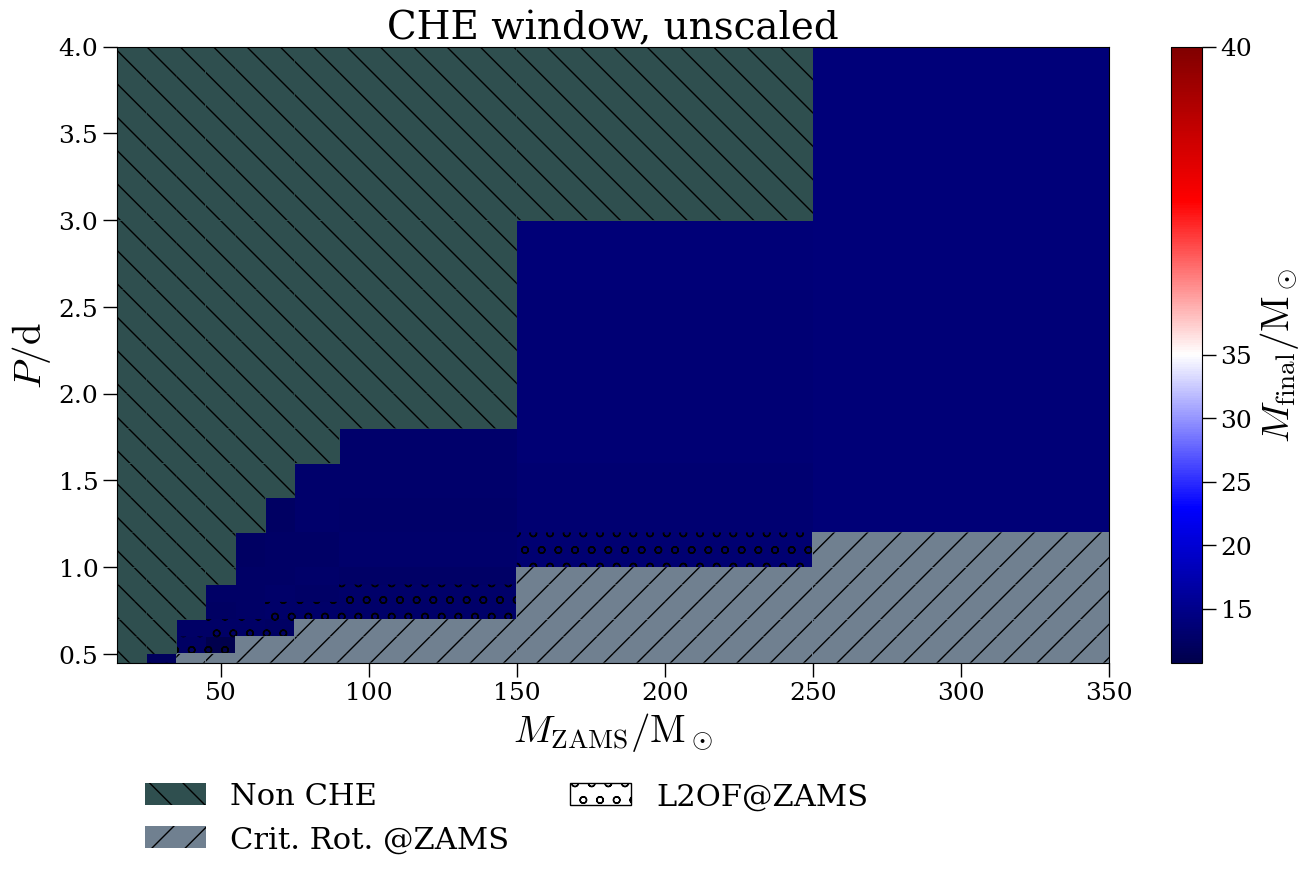

In [144]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.pcolormesh(color_m_arr, color_p_arr, color_mcore_arr, shading='flat')
ax.pcolor(color_m_arr, color_p_arr, zams_l2of_arr, hatch=l2of_hatch)
ax.pcolor(hatch_crit_m_arr, hatch_crit_p_arr, hatch_crit_mcore_arr, alpha=0., hatch=crit_hatch)
ax.pcolor(hatch_nonche_m_arr, hatch_nonche_p_arr, hatch_nonche_mcore_arr, alpha=0., hatch=nonche_hatch)

ax.set_xlabel('$M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
ax.set_ylabel('$P/\\mathrm{d}$')

sm = ScalarMappable(norm=mcore_norm, cmap=cmap)
cb = fig.colorbar(sm, ax=ax)
cb.set_label('$M_\\mathrm{final}/\\mathrm{M}_\\odot$')

handles = []
handles.append(Patch(facecolor=nonche_c, hatch=nonche_hatch, label='Non CHE'))
handles.append(Patch(facecolor=crit_c, hatch=crit_hatch, label='Crit. Rot. @ZAMS'))
handles.append(Patch(facecolor='w', hatch=l2of_hatch, label='L2OF@ZAMS', edgecolor='k'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(0, -0.15), ncol=2)

ax.set_title('CHE window, unscaled')

savefig(fig, 'che_window_unscaled')

In [145]:
def mass_forward(m):
    return m**-2.35

def mass_inverse(m):
    return m**(-1/2.35)

/tmp/ipykernel_2528056/1587637377.py:2: RuntimeWarning: divide by zero encountered in power
  return m**-2.35


/tmp/ipykernel_2528056/1587637377.py:2: RuntimeWarning: divide by zero encountered in power
  return m**-2.35


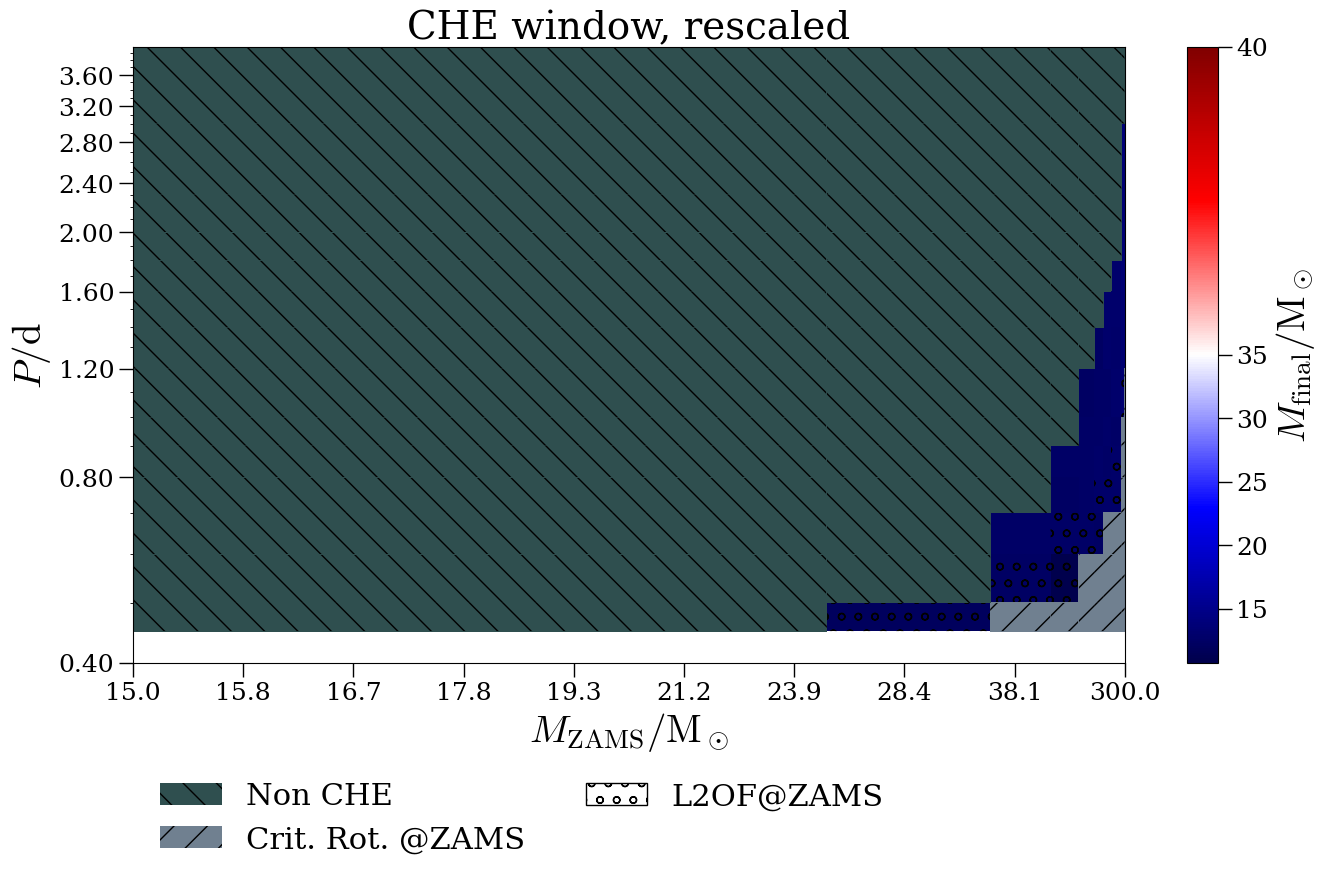

In [146]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.pcolormesh(color_m_arr, color_p_arr, color_mcore_arr, shading='flat')
ax.pcolor(color_m_arr, color_p_arr, zams_l2of_arr, hatch=l2of_hatch)
ax.pcolor(hatch_crit_m_arr, hatch_crit_p_arr, hatch_crit_mcore_arr, alpha=0., hatch=crit_hatch)
ax.pcolor(hatch_nonche_m_arr, hatch_nonche_p_arr, hatch_nonche_mcore_arr, alpha=0., hatch=nonche_hatch)

ax.set_xlabel('$M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
ax.set_ylabel('$P/\\mathrm{d}$')

sm = ScalarMappable(norm=mcore_norm, cmap=cmap)
cb = fig.colorbar(sm, ax=ax)
cb.set_label('$M_\\mathrm{final}/\\mathrm{M}_\\odot$')

handles = []
handles.append(Patch(facecolor=nonche_c, hatch=nonche_hatch, label='Non CHE'))
handles.append(Patch(facecolor=crit_c, hatch=crit_hatch, label='Crit. Rot. @ZAMS'))
handles.append(Patch(facecolor='w', hatch=l2of_hatch, label='L2OF@ZAMS', edgecolor='k'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(0, -0.15), ncol=2)

ax.set_yscale('log')
ax.set_xscale('function', functions=(mass_forward, mass_inverse))
ax.set_xticks([mass_inverse(x) for x in np.linspace(mass_forward(15), mass_forward(300), 10)])

ax.set_xlim(15, 310)
ax.invert_xaxis()

ax.set_yticks(np.arange(0.4, 4, 0.4))
ax.set_yticklabels([f'{p:.2f}' for p in np.arange(0.4, 4, 0.4)])
ax.set_yticks(np.arange(0.4, 4, 0.1), minor=True)
ax.set_yticklabels([], minor=True)

ax.set_title('CHE window, rescaled')

savefig(fig, 'che_window_rescaled')

/tmp/ipykernel_2528056/1587637377.py:2: RuntimeWarning: divide by zero encountered in power
  return m**-2.35


/tmp/ipykernel_2528056/1587637377.py:2: RuntimeWarning: divide by zero encountered in power
  return m**-2.35


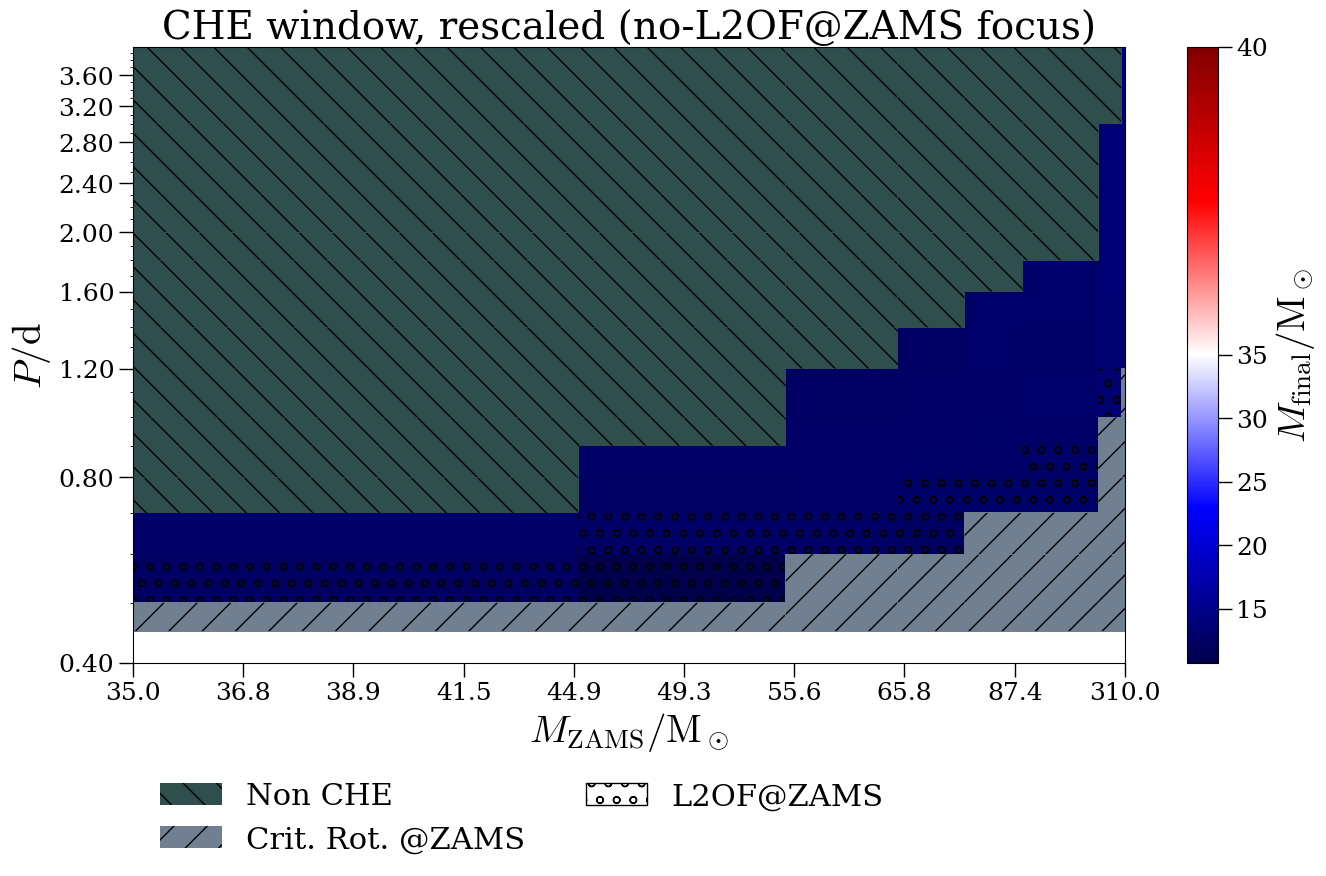

In [147]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.pcolormesh(color_m_arr, color_p_arr, color_mcore_arr, shading='flat')
ax.pcolor(color_m_arr, color_p_arr, zams_l2of_arr, hatch=l2of_hatch)
ax.pcolor(hatch_crit_m_arr, hatch_crit_p_arr, hatch_crit_mcore_arr, alpha=0., hatch=crit_hatch)
ax.pcolor(hatch_nonche_m_arr, hatch_nonche_p_arr, hatch_nonche_mcore_arr, alpha=0., hatch=nonche_hatch)

ax.set_xlabel('$M_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
ax.set_ylabel('$P/\\mathrm{d}$')

sm = ScalarMappable(norm=mcore_norm, cmap=cmap)
cb = fig.colorbar(sm, ax=ax)
cb.set_label('$M_\\mathrm{final}/\\mathrm{M}_\\odot$')

handles = []
handles.append(Patch(facecolor=nonche_c, hatch=nonche_hatch, label='Non CHE'))
handles.append(Patch(facecolor=crit_c, hatch=crit_hatch, label='Crit. Rot. @ZAMS'))
handles.append(Patch(facecolor='w', hatch=l2of_hatch, label='L2OF@ZAMS', edgecolor='k'))
ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(0, -0.15), ncol=2)

ax.set_yscale('log')
ax.set_xscale('function', functions=(mass_forward, mass_inverse))
ax.set_xticks([mass_inverse(x) for x in np.linspace(mass_forward(35), mass_forward(310), 10)])

ax.set_xlim(35, 310)
ax.invert_xaxis()

ax.set_yticks(np.arange(0.4, 4, 0.4))
ax.set_yticklabels([f'{p:.2f}' for p in np.arange(0.4, 4, 0.4)])
ax.set_yticks(np.arange(0.4, 4, 0.1), minor=True)
ax.set_yticklabels([], minor=True)

ax.set_title('CHE window, rescaled (no-L2OF@ZAMS focus)')

savefig(fig, 'che_window_rescaled_no_l2of')

In [148]:
interpolator_dict = dict()

for i, m in enumerate(mass_guide_float):
    m_key = mass_guide_str[i]
    p_arr = period_guide_float   
    y_arr = final_mass_array[:, i, 0] 
    r_arr = final_mass_array[:, i, 6] 

    mask = np.array(final_mass_array[:, i, 9], bool)
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]
    r_arr = r_arr[mask]
            
    if m_key in ['50.0']:
        y_arr = y_arr[1:]
        p_arr = p_arr[1:]
        r_arr = r_arr[1:]
        
    if m_key in ['40.0', '220.0']:
        y_arr = y_arr[:-1]
        p_arr = p_arr[:-1]
        r_arr = r_arr[:-1]
        
    mask = []
    for p0, rzams in zip(p_arr, r_arr):
        isof = is_of(rzams, float(m_key), p0, 1, kind='L2')
        if isof:
            mask.append(False)
        else:
            mask.append(True)
            
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]
    r_arr = r_arr[mask]
    
    if len(y_arr) == 0:
        y_arr = [nan]
        p_arr = [1]
        r_arr = [1]
    
    interpolator = interp1d(
        x=p_arr,
        y=y_arr,
        kind='linear',
        bounds_error=False,
        fill_value=nan
        )

    interpolator_dict[m_key] = interpolator     
    
l2_pzams_mcore_interpolator_dict = interpolator_dict

In [149]:
def l2_mzams_mcore_interpolator(m_zams, p_zams):
    ip_m_cores = []
    for m_key in mass_guide_str:
        interpolator = l2_pzams_mcore_interpolator_dict[m_key]
        ip_m_cores.append(interpolator(p_zams))
    
    interpolator = interp1d(
        x=mass_guide_float,
        y=ip_m_cores,
        kind='linear',
        bounds_error=False,
        fill_value='extrapolate'
    )
    
    m_core = interpolator(m_zams)
    
    return m_core  

In [150]:
interpolator_dict = dict()

for i, m in enumerate(mass_guide_float):
    m_key = mass_guide_str[i]
    p_arr = period_guide_float   
    y_arr = final_mass_array[:, i, 6] 
    r_arr = final_mass_array[:, i, 6] 
    
    mask = np.array(final_mass_array[:, i, 9], bool)
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]
    r_arr = r_arr[mask]

    if m_key in ['280.0', '220.0', '160.0', '50.0', '80.0']:
        p_arr = p_arr[1:]
        y_arr = y_arr[1:]
        r_arr = r_arr[1:]
 
    mask = []
    for p0, rzams in zip(p_arr, r_arr):
        isof = is_of(rzams, float(m_key), p0, 1, kind='L2')
        if isof:
            mask.append(False)
        else:
            mask.append(True)
    
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]
    r_arr = r_arr[mask]
    
    if len(y_arr) == 0:
        y_arr = [nan]
        p_arr = [1]
        r_arr = [1]
    
    interpolator = interp1d(
        x=p_arr,
        y=y_arr,
        kind='linear',
        bounds_error=False,
        fill_value=nan
        )

    interpolator_dict[m_key] = interpolator     
    
l2_pzams_rzams_interpolator_dict = interpolator_dict

In [151]:
def l2_mzams_rzams_interpolator(m_zams, p_zams):
    ip_m_cores = []
    for m_key in mass_guide_str:
        interpolator = l2_pzams_rzams_interpolator_dict[m_key]
        ip_m_cores.append(interpolator(p_zams))
    
    interpolator = interp1d(
        x=mass_guide_float,
        y=ip_m_cores,
        kind='linear',
        bounds_error=False,
        fill_value=nan
    )
    
    m_core = interpolator(m_zams)
    
    return m_core      

In [152]:
def draw_mass_sample(
    res=int(1e8),
    min_m=20,
    max_m=300,
    min_p=0.1,
    max_p=4,
    min_mfinal=20,
    max_mfinal=50,
    mfinal_bin_width=0.2
):
    sample_masses = np.linspace(min_m, max_m, res)
    sample_probs = sample_masses**-2.3/np.sum(sample_masses**-2.3)
    sample_masses = np.random.choice(sample_masses, p=sample_probs, size=int(res/100))

    sample_periods = np.linspace(np.log10(min_p), np.log10(max_p), res)
    sample_probs = np.ones(res)/res
    sample_periods = 10.**np.random.choice(sample_periods, p=sample_probs, size=int(res/100))

    sample_zams_rs = np.array([l2_mzams_rzams_interpolator(m, p) for m, p in zip(sample_masses, sample_periods)])

    sample_mcores = np.zeros(int(res/100))

    sample_ = np.array([sample_masses, sample_periods, sample_zams_rs, sample_mcores]).T
    zams_l2of_sample = set_mcores(sample_).copy()
    
    mass_draw = zams_l2of_sample[:, 3]
    mass_draw = mass_draw[~np.isnan(mass_draw)]

    bins = np.arange(min_mfinal, max_mfinal+mfinal_bin_width, mfinal_bin_width)
    hist, bins = np.histogram(mass_draw, density=True, bins=bins)
    centers = np.array([(bin0+bin1)/2 for bin0, bin1 in zip(bins[:-1], bins[1:])])
    mode = centers[np.argmax(hist)]
    
    return zams_l2of_sample, mode

In [153]:
from multiprocessing import Pool
from scipy.stats import mode

In [155]:
result03 = draw_mass_sample(res=int(1e7))

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


In [156]:
result = result03

Text(0.98, 0.98, 'Stopping condition: central_c12<=1e-6\nSome models start core Ne burning')

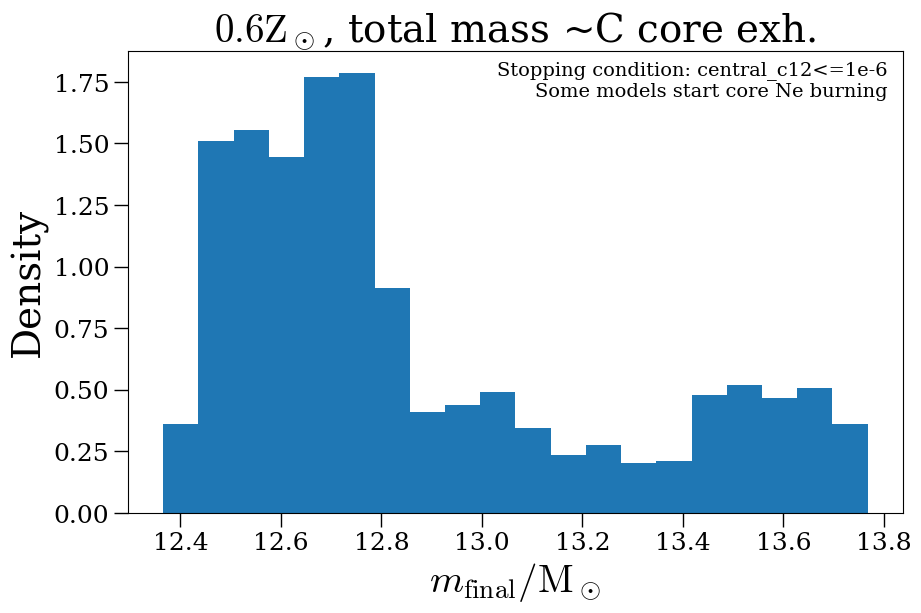

In [157]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(result[0][:,3], density=True, bins=20)

#ax.vlines(35, 0, 0.3, color='k', lw=0.5)
#ax.set_ylim(0, 0.25)
#ax.set_xlim(30, 45)
#ax.set_xticks(np.arange(30, 50, 2.5))

ax.set_ylabel('Density')
ax.set_xlabel('$m_\\mathrm{final}/\mathrm{M}_\odot$')
ax.set_title('$0.6\\mathrm{Z}_\\odot$, total mass ~C core exh.')

note = '\n'.join(('Stopping condition: central_c12<=1e-6',
                  'Some models start core Ne burning'))
ax.text(0.98, 
        0.98, 
        note,
        transform=ax.transAxes,
        ha='right',
        va='top',
        fontsize=14
        )


## $0.8\mathrm{Z}_\odot$

In [106]:
#np.save(f'nb{nb_id}_p_plot_extended.npy', p_plot)
final_mass_array = np.load('04_enhanced_w_core_props.npy')
model_dicts = model_dicts_08zsun

In [107]:
# Select models
models_to_plot = np.arange(0, len(model_dicts), 1)
model_dict_list = model_dicts[models_to_plot]
print(f'Loading {model_dict_list}')

# Collect periods
all_periods = []
for dict_ in model_dict_list:
    for k1 in dict_.keys():
        for k2 in dict_[k1].keys():
            all_periods.append(k2)
all_periods = np.unique(all_periods)
all_periods = all_periods[np.argsort([float(p) for p in all_periods])][1:]
print(all_periods)

Loading [{'20.0': {'2.60': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/04_ZdivZsun_8d-1/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_p2.600d+00_w2.797d-05'), '4.00': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/04_ZdivZsun_8d-1/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_p4.000d+00_w1.818d-05'), '0.40': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/04_ZdivZsun_8d-1/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_p4.000d-01_w1.818d-04'), '2.00': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/04_ZdivZsun_8d-1/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_p2.000d+00_w3.636d-05'), '0.70': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/04_ZdivZsun_8d-1/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_p7.000d-01_w1.039d-04'), '1.60': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/04_ZdivZsun_8d-1/001_md1_m20

In [108]:
mass_guide_str = [list(dict_.keys())[0] for dict_ in model_dict_list]
mass_guide_float = np.array([float(m) for m in mass_guide_str])

period_guide_str = all_periods
period_guide_float = np.array([float(p) for p in period_guide_str])

In [109]:
from scipy.interpolate import interp1d

In [110]:
from math import nan

### Core mass plane

In [111]:
stage_index = dict(zams=6, prezams=7)

In [112]:
def mzams_p0_mcore_of_plot(ax, of_when, of_kind, min_mcore=20, max_mcore=50):    
    of_when_i = stage_index[of_when]
    handles = []
    for i, m_key in enumerate(mass_guide_str):
        c = cm.jet(i/len(mass_guide_str))
        handles.append(ax.scatter([], [], c=c, marker='o', label=m_key))
        m_zams = float(m_key)
        
        #che_mask = np.array(final_mass_array[:,i,9], bool)
        pp = period_guide_float#[che_mask]
        mm = final_mass_array[:,i,0]#[che_mask]
        rr = final_mass_array[:,i,of_when_i]#[che_mask]
        is_che = np.array(final_mass_array[:,i,9], bool)
        is_crit = np.array(final_mass_array[:,i,8], bool)
        
        for p, r, m_core, ische, iscrit in zip(pp, rr, mm, is_che, is_crit):
            if iscrit:
                marker = 'x'
                color = 'k'
            elif not ische:
                marker = '+'
                color = 'k'
            else:
                marker = 'o'
                color = cm.jet_r((np.log10(m_core)-np.log10(min_mcore))/(np.log10(max_mcore)-np.log10(min_mcore)))
            isof = is_of(r, m_zams, p, 1, kind=of_kind)
            if isof:
                alpha = 0.3
            else:
                alpha = 1.0
            ax.scatter(m_zams, p, marker=marker, color=color, zorder=1, s=30, alpha=alpha)
    return ax, handles

In [113]:
def p0_mcore_mzams_of_plot(ax, of_when, of_kind):
    of_when_i = stage_index[of_when]
    handles = []
    for i, m_key in enumerate(mass_guide_str):
        c = cm.jet(i/len(mass_guide_str))
        handles.append(ax.scatter([], [], c=c, marker='o', label=m_key))
        m_zams = float(m_key)
        
        che_mask = np.array(final_mass_array[:,i,9], bool)
        pp = period_guide_float[che_mask]
        mm = final_mass_array[:,i,3][che_mask]
        rr = final_mass_array[:,i,of_when_i][che_mask]
            
        for p, r, m_core in zip(pp, rr, mm):
            isof = is_of(r, m_zams, p, 1, kind=of_kind)
            if isof:
                ax.scatter(p, m_core, marker='x', color=c, zorder=1, s=30, alpha=0.3)
                pass
            else:
                ax.scatter(p, m_core, marker='o', color=c, zorder=1, s=30)
    return ax, handles

In [114]:
def is_of(r, m, p, q=1, kind='RL'):
    a = a_from_p(p, m, q)
    if kind == 'merger':
        of_a = a.to(u.Rsun).value
    elif kind == 'RL':
        of_a = eggleton_rl1_radius(a, q).to(u.Rsun).value
    elif kind == 'L2':
        of_a = marchant_l2_radius(a, q).to(u.Rsun).value
    elif kind == 'none':
        of_a = np.inf
    else:
        raise ValueError(f'kind {kind} not recognized')
    if of_a <= r:
        isof = True
    else:
        isof = False

    return isof

In [115]:
min_mcore = final_mass_array[:, :, 0][np.array(final_mass_array[:, :, 9], bool)].min()
max_mcore = final_mass_array[:, :, 0][np.array(final_mass_array[:, :, 9], bool)].max()
mcore_norm = TwoSlopeNorm(vmin=min(30, min_mcore), vmax=max(max_mcore, 40), vcenter=35.)
nonche_c = to_rgba('darkslategrey')
crit_c = to_rgba('slategrey')
cmap = cm.seismic
def mcore_cmap(x): return cmap(mcore_norm(x))

In [116]:
m_arr = np.zeros(len(mass_guide_float)+1)
p_arr = np.zeros(len(period_guide_float)+1)
mcore_arr = np.zeros((len(mass_guide_float), len(period_guide_float), 4))
zams_l2of_arr = np.zeros((len(mass_guide_float), len(period_guide_float), 4))

for i_m, m1 in enumerate(mass_guide_float):
    if i_m == 0:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        bin_lower_m = m1 - (bin_upper_m-m1)
    elif i_m < len(mass_guide_float)-1:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
    else:
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
        bin_upper_m = m1 + (m1-bin_lower_m)
    m_arr[i_m] = bin_lower_m
    m_arr[i_m+1] = bin_upper_m
    
    for i_p, p1 in enumerate(period_guide_float):
        if i_p == 0:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = p1 - (bin_upper_p-p1)
        elif i_p < len(period_guide_float)-1:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (p0+p1)/2
        else:
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (p0+p1)/2
            m2 = m1 + (m1-bin_lower_p)
        p_arr[i_p] = p0
        p_arr[i_p+1] = p2
        
        mcore = final_mass_array[i_p, i_m, 0]
        ische = final_mass_array[i_p, i_m, 9]
        iscrit = final_mass_array[i_p, i_m, 8]
        if ische:
            mcore_arr[i_m, i_p, :] = mcore_cmap(mcore)
        elif iscrit: 
            mcore_arr[i_m, i_p, :] = crit_c
        else:
            mcore_arr[i_m, i_p, :] = nonche_c

        rzams = final_mass_array[i_p, i_m, 6]
        is_l2of = is_of(r=rzams, m=m1, p=p1, q=1, kind='L2')
        if is_l2of:
            zams_l2of_arr[i_m, i_p, :] = [0, 0, 0, 0]
        else:
            zams_l2of_arr[i_m, i_p, :] = 4*[nan]
            
m_arr = np.tile(m_arr, [len(period_guide_float)+1, 1]).T
p_arr = np.tile(p_arr, [len(mass_guide_float)+1, 1])

color_mcore_arr = mcore_arr
color_m_arr = m_arr
color_p_arr = p_arr

In [117]:
m_arr = np.zeros(len(mass_guide_float)+1)
p_arr = np.zeros(len(period_guide_float)+1)
mcore_arr = np.zeros((len(mass_guide_float), len(period_guide_float), 4))
che_mask = np.ones((len(mass_guide_float)+1, len(period_guide_float)+1), bool)

for i_m, m1 in enumerate(mass_guide_float):
    if i_m == 0:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        bin_lower_m = m1 - (bin_upper_m-m1)
    elif i_m < len(mass_guide_float)-1:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
    else:
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
        bin_upper_m = m1 + (m1-bin_lower_m)
    m_arr[i_m] = bin_lower_m
    m_arr[i_m+1] = bin_upper_m
    
    for i_p, p1 in enumerate(period_guide_float):
        if i_p == 0:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = p1 - (bin_upper_p-p1)
        elif i_p < len(period_guide_float)-1:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (p0+p1)/2
        else:
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (m0+m1)/2
            m2 = m1 + (m1-bin_lower_p)
        p_arr[i_p] = p0
        p_arr[i_p+1] = p2
        
        mcore = final_mass_array[i_p, i_m, 0]
        ische = final_mass_array[i_p, i_m, 9]
        iscrit = final_mass_array[i_p, i_m, 8]
        if ische:
            mcore_arr[i_m, i_p, :] = 4*[nan]
            che_mask[i_m, i_p] = True
        elif iscrit: 
            mcore_arr[i_m, i_p, :] = crit_c
            che_mask[i_m, i_p] = False
        else:
            mcore_arr[i_m, i_p, :] = 4*[nan]
            che_mask[i_m, i_p] = False
            
m_arr = np.tile(m_arr, [len(period_guide_float)+1, 1]).T
p_arr = np.tile(p_arr, [len(mass_guide_float)+1, 1])

hatch_crit_mcore_arr = mcore_arr
hatch_crit_m_arr = m_arr
hatch_crit_p_arr = p_arr

In [118]:
m_arr = np.zeros(len(mass_guide_float)+1)
p_arr = np.zeros(len(period_guide_float)+1)
mcore_arr = np.zeros((len(mass_guide_float), len(period_guide_float), 4))
che_mask = np.ones((len(mass_guide_float)+1, len(period_guide_float)+1), bool)

for i_m, m1 in enumerate(mass_guide_float):
    if i_m == 0:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        bin_lower_m = m1 - (bin_upper_m-m1)
    elif i_m < len(mass_guide_float)-1:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
    else:
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
        bin_upper_m = m1 + (m1-bin_lower_m)
    m_arr[i_m] = bin_lower_m
    m_arr[i_m+1] = bin_upper_m
    
    for i_p, p1 in enumerate(period_guide_float):
        if i_p == 0:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = p1 - (bin_upper_p-p1)
        elif i_p < len(period_guide_float)-1:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (p0+p1)/2
        else:
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (m0+m1)/2
            m2 = m1 + (m1-bin_lower_p)
        p_arr[i_p] = p0
        p_arr[i_p+1] = p2
        
        mcore = final_mass_array[i_p, i_m, 0]
        ische = final_mass_array[i_p, i_m, 9]
        iscrit = final_mass_array[i_p, i_m, 8]
        if ische:
            mcore_arr[i_m, i_p, :] = 4*[nan]
            che_mask[i_m, i_p] = True
        elif iscrit: 
            mcore_arr[i_m, i_p, :] = 4*[nan]
            che_mask[i_m, i_p] = False
        else:
            mcore_arr[i_m, i_p, :] = nonche_c
            che_mask[i_m, i_p] = False
            
m_arr = np.tile(m_arr, [len(period_guide_float)+1, 1]).T
p_arr = np.tile(p_arr, [len(mass_guide_float)+1, 1])

hatch_nonche_mcore_arr = mcore_arr
hatch_nonche_m_arr = m_arr
hatch_nonche_p_arr = p_arr

In [119]:
nonche_hatch = '\\'
crit_hatch = '/'
l2of_hatch = 'o'

In [120]:
from matplotlib.patches import Patch

In [121]:
def mass_forward(m):
    return m**-2.35

def mass_inverse(m):
    return m**(-1/2.35)

In [122]:
interpolator_dict = dict()

for i, m in enumerate(mass_guide_float):
    m_key = mass_guide_str[i]
    p_arr = period_guide_float   
    y_arr = final_mass_array[:, i, 0] 
    r_arr = final_mass_array[:, i, 6] 

    mask = np.array(final_mass_array[:, i, 9], bool)
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]
    r_arr = r_arr[mask]
            
        
    mask = []
    for p0, rzams in zip(p_arr, r_arr):
        isof = is_of(rzams, float(m_key), p0, 1, kind='L2')
        if isof:
            mask.append(False)
        else:
            mask.append(True)
            
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]
    r_arr = r_arr[mask]
    
    if len(y_arr) == 0:
        y_arr = [nan]
        p_arr = [1]
        r_arr = [1]
    
    interpolator = interp1d(
        x=p_arr,
        y=y_arr,
        kind='linear',
        bounds_error=False,
        fill_value=nan
        )

    interpolator_dict[m_key] = interpolator     
    
l2_pzams_mcore_interpolator_dict = interpolator_dict

In [123]:
def l2_mzams_mcore_interpolator(m_zams, p_zams):
    ip_m_cores = []
    for m_key in mass_guide_str:
        interpolator = l2_pzams_mcore_interpolator_dict[m_key]
        ip_m_cores.append(interpolator(p_zams))
    
    interpolator = interp1d(
        x=mass_guide_float,
        y=ip_m_cores,
        kind='linear',
        bounds_error=False,
        fill_value='extrapolate'
    )
    
    m_core = interpolator(m_zams)
    
    return m_core  

In [124]:
interpolator_dict = dict()

for i, m in enumerate(mass_guide_float):
    m_key = mass_guide_str[i]
    p_arr = period_guide_float   
    y_arr = final_mass_array[:, i, 6] 
    r_arr = final_mass_array[:, i, 6] 
    
    mask = np.array(final_mass_array[:, i, 9], bool)
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]
    r_arr = r_arr[mask]

    if m_key in ['280.0', '220.0', '160.0', '50.0', '80.0']:
        p_arr = p_arr[1:]
        y_arr = y_arr[1:]
        r_arr = r_arr[1:]
 
    mask = []
    for p0, rzams in zip(p_arr, r_arr):
        isof = is_of(rzams, float(m_key), p0, 1, kind='L2')
        if isof:
            mask.append(False)
        else:
            mask.append(True)
    
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]
    r_arr = r_arr[mask]
    
    if len(y_arr) == 0:
        y_arr = [nan]
        p_arr = [1]
        r_arr = [1]
    
    interpolator = interp1d(
        x=p_arr,
        y=y_arr,
        kind='linear',
        bounds_error=False,
        fill_value=nan
        )

    interpolator_dict[m_key] = interpolator     
    
l2_pzams_rzams_interpolator_dict = interpolator_dict

In [125]:
def l2_mzams_rzams_interpolator(m_zams, p_zams):
    ip_m_cores = []
    for m_key in mass_guide_str:
        interpolator = l2_pzams_rzams_interpolator_dict[m_key]
        ip_m_cores.append(interpolator(p_zams))
    
    interpolator = interp1d(
        x=mass_guide_float,
        y=ip_m_cores,
        kind='linear',
        bounds_error=False,
        fill_value=nan
    )
    
    m_core = interpolator(m_zams)
    
    return m_core      

In [126]:
def draw_mass_sample(
    res=int(1e8),
    min_m=20,
    max_m=300,
    min_p=0.1,
    max_p=4,
    min_mfinal=20,
    max_mfinal=50,
    mfinal_bin_width=0.2
):
    sample_masses = np.linspace(min_m, max_m, res)
    sample_probs = sample_masses**-2.3/np.sum(sample_masses**-2.3)
    sample_masses = np.random.choice(sample_masses, p=sample_probs, size=int(res/100))

    sample_periods = np.linspace(np.log10(min_p), np.log10(max_p), res)
    sample_probs = np.ones(res)/res
    sample_periods = 10.**np.random.choice(sample_periods, p=sample_probs, size=int(res/100))

    sample_zams_rs = np.array([l2_mzams_rzams_interpolator(m, p) for m, p in zip(sample_masses, sample_periods)])

    sample_mcores = np.zeros(int(res/100))

    sample_ = np.array([sample_masses, sample_periods, sample_zams_rs, sample_mcores]).T
    zams_l2of_sample = set_mcores(sample_).copy()
    
    mass_draw = zams_l2of_sample[:, 3]
    mass_draw = mass_draw[~np.isnan(mass_draw)]

    bins = np.arange(min_mfinal, max_mfinal+mfinal_bin_width, mfinal_bin_width)
    hist, bins = np.histogram(mass_draw, density=True, bins=bins)
    centers = np.array([(bin0+bin1)/2 for bin0, bin1 in zip(bins[:-1], bins[1:])])
    mode = centers[np.argmax(hist)]
    
    return zams_l2of_sample, mode

In [127]:
from multiprocessing import Pool
from scipy.stats import mode

In [128]:
result04 = draw_mass_sample(res=int(1e7))

NameError: name 'mzams_mcore_interpolator' is not defined

In [ ]:
result = result04

Text(0.98, 0.98, 'Stopping condition: central_c12<=1e-6\nSome models start core Ne burning')

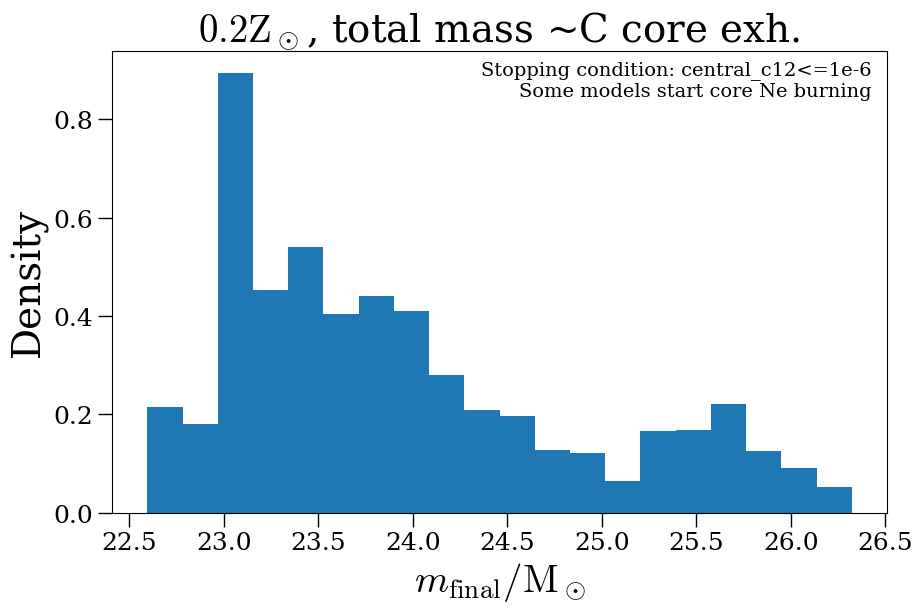

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(result[0][:,3], density=True, bins=20)

#ax.vlines(35, 0, 0.3, color='k', lw=0.5)
#ax.set_ylim(0, 0.25)
#ax.set_xlim(30, 45)
#ax.set_xticks(np.arange(30, 50, 2.5))

ax.set_ylabel('Density')
ax.set_xlabel('$m_\\mathrm{final}/\mathrm{M}_\odot$')
ax.set_title('$0.8\\mathrm{Z}_\\odot$, total mass ~C core exh.')

note = '\n'.join(('Stopping condition: central_c12<=1e-6',
                  'Some models start core Ne burning'))
ax.text(0.98, 
        0.98, 
        note,
        transform=ax.transAxes,
        ha='right',
        va='top',
        fontsize=14
        )


## $1.0\mathrm{Z}_\odot$

In [ ]:
#np.save(f'nb{nb_id}_p_plot_extended.npy', p_plot)
final_mass_array = np.load('05_enhanced_w_core_props.npy')
model_dicts = model_dicts_10zsun

In [ ]:
# Select models
models_to_plot = np.arange(0, len(model_dicts), 1)
model_dict_list = model_dicts[models_to_plot]
print(f'Loading {model_dict_list}')

# Collect periods
all_periods = []
for dict_ in model_dict_list:
    for k1 in dict_.keys():
        for k2 in dict_[k1].keys():
            all_periods.append(k2)
all_periods = np.unique(all_periods)
all_periods = all_periods[np.argsort([float(p) for p in all_periods])][1:]
print(all_periods)

Loading [{'20.0': {'2.60': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_p2.600d+00_w2.797d-05'), '4.00': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_p4.000d+00_w1.818d-05'), '0.40': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_p4.000d-01_w1.818d-04'), '2.00': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_p2.000d+00_w3.636d-05'), '0.70': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_p7.000d-01_w1.039d-04'), '1.60': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/001_md1_m20

In [ ]:
mass_guide_str = [list(dict_.keys())[0] for dict_ in model_dict_list]
mass_guide_float = np.array([float(m) for m in mass_guide_str])

period_guide_str = all_periods
period_guide_float = np.array([float(p) for p in period_guide_str])

In [ ]:
from scipy.interpolate import interp1d

In [ ]:
from math import nan

### Core mass plane

In [ ]:
stage_index = dict(zams=6, prezams=7)

In [ ]:
def mzams_p0_mcore_of_plot(ax, of_when, of_kind, min_mcore=20, max_mcore=50):    
    of_when_i = stage_index[of_when]
    handles = []
    for i, m_key in enumerate(mass_guide_str):
        c = cm.jet(i/len(mass_guide_str))
        handles.append(ax.scatter([], [], c=c, marker='o', label=m_key))
        m_zams = float(m_key)
        
        #che_mask = np.array(final_mass_array[:,i,9], bool)
        pp = period_guide_float#[che_mask]
        mm = final_mass_array[:,i,0]#[che_mask]
        rr = final_mass_array[:,i,of_when_i]#[che_mask]
        is_che = np.array(final_mass_array[:,i,9], bool)
        is_crit = np.array(final_mass_array[:,i,8], bool)
        
        for p, r, m_core, ische, iscrit in zip(pp, rr, mm, is_che, is_crit):
            if iscrit:
                marker = 'x'
                color = 'k'
            elif not ische:
                marker = '+'
                color = 'k'
            else:
                marker = 'o'
                color = cm.jet_r((np.log10(m_core)-np.log10(min_mcore))/(np.log10(max_mcore)-np.log10(min_mcore)))
            isof = is_of(r, m_zams, p, 1, kind=of_kind)
            if isof:
                alpha = 0.3
            else:
                alpha = 1.0
            ax.scatter(m_zams, p, marker=marker, color=color, zorder=1, s=30, alpha=alpha)
    return ax, handles

In [ ]:
def p0_mcore_mzams_of_plot(ax, of_when, of_kind):
    of_when_i = stage_index[of_when]
    handles = []
    for i, m_key in enumerate(mass_guide_str):
        c = cm.jet(i/len(mass_guide_str))
        handles.append(ax.scatter([], [], c=c, marker='o', label=m_key))
        m_zams = float(m_key)
        
        che_mask = np.array(final_mass_array[:,i,9], bool)
        pp = period_guide_float[che_mask]
        mm = final_mass_array[:,i,3][che_mask]
        rr = final_mass_array[:,i,of_when_i][che_mask]
            
        for p, r, m_core in zip(pp, rr, mm):
            isof = is_of(r, m_zams, p, 1, kind=of_kind)
            if isof:
                ax.scatter(p, m_core, marker='x', color=c, zorder=1, s=30, alpha=0.3)
                pass
            else:
                ax.scatter(p, m_core, marker='o', color=c, zorder=1, s=30)
    return ax, handles

In [ ]:
def is_of(r, m, p, q=1, kind='RL'):
    a = a_from_p(p, m, q)
    if kind == 'merger':
        of_a = a.to(u.Rsun).value
    elif kind == 'RL':
        of_a = eggleton_rl1_radius(a, q).to(u.Rsun).value
    elif kind == 'L2':
        of_a = marchant_l2_radius(a, q).to(u.Rsun).value
    elif kind == 'none':
        of_a = np.inf
    else:
        raise ValueError(f'kind {kind} not recognized')
    if of_a <= r:
        isof = True
    else:
        isof = False

    return isof

In [ ]:
min_mcore = final_mass_array[:, :, 0][np.array(final_mass_array[:, :, 9], bool)].min()
max_mcore = final_mass_array[:, :, 0][np.array(final_mass_array[:, :, 9], bool)].max()
mcore_norm = TwoSlopeNorm(vmin=min(30, min_mcore), vmax=max(max_mcore, 40), vcenter=35.)
nonche_c = to_rgba('darkslategrey')
crit_c = to_rgba('slategrey')
cmap = cm.seismic
def mcore_cmap(x): return cmap(mcore_norm(x))

In [ ]:
m_arr = np.zeros(len(mass_guide_float)+1)
p_arr = np.zeros(len(period_guide_float)+1)
mcore_arr = np.zeros((len(mass_guide_float), len(period_guide_float), 4))
zams_l2of_arr = np.zeros((len(mass_guide_float), len(period_guide_float), 4))

for i_m, m1 in enumerate(mass_guide_float):
    if i_m == 0:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        bin_lower_m = m1 - (bin_upper_m-m1)
    elif i_m < len(mass_guide_float)-1:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
    else:
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
        bin_upper_m = m1 + (m1-bin_lower_m)
    m_arr[i_m] = bin_lower_m
    m_arr[i_m+1] = bin_upper_m
    
    for i_p, p1 in enumerate(period_guide_float):
        if i_p == 0:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = p1 - (bin_upper_p-p1)
        elif i_p < len(period_guide_float)-1:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (p0+p1)/2
        else:
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (p0+p1)/2
            m2 = m1 + (m1-bin_lower_p)
        p_arr[i_p] = p0
        p_arr[i_p+1] = p2
        
        mcore = final_mass_array[i_p, i_m, 0]
        ische = final_mass_array[i_p, i_m, 9]
        iscrit = final_mass_array[i_p, i_m, 8]
        if ische:
            mcore_arr[i_m, i_p, :] = mcore_cmap(mcore)
        elif iscrit: 
            mcore_arr[i_m, i_p, :] = crit_c
        else:
            mcore_arr[i_m, i_p, :] = nonche_c

        rzams = final_mass_array[i_p, i_m, 6]
        is_l2of = is_of(r=rzams, m=m1, p=p1, q=1, kind='L2')
        if is_l2of:
            zams_l2of_arr[i_m, i_p, :] = [0, 0, 0, 0]
        else:
            zams_l2of_arr[i_m, i_p, :] = 4*[nan]
            
m_arr = np.tile(m_arr, [len(period_guide_float)+1, 1]).T
p_arr = np.tile(p_arr, [len(mass_guide_float)+1, 1])

color_mcore_arr = mcore_arr
color_m_arr = m_arr
color_p_arr = p_arr

In [ ]:
m_arr = np.zeros(len(mass_guide_float)+1)
p_arr = np.zeros(len(period_guide_float)+1)
mcore_arr = np.zeros((len(mass_guide_float), len(period_guide_float), 4))
che_mask = np.ones((len(mass_guide_float)+1, len(period_guide_float)+1), bool)

for i_m, m1 in enumerate(mass_guide_float):
    if i_m == 0:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        bin_lower_m = m1 - (bin_upper_m-m1)
    elif i_m < len(mass_guide_float)-1:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
    else:
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
        bin_upper_m = m1 + (m1-bin_lower_m)
    m_arr[i_m] = bin_lower_m
    m_arr[i_m+1] = bin_upper_m
    
    for i_p, p1 in enumerate(period_guide_float):
        if i_p == 0:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = p1 - (bin_upper_p-p1)
        elif i_p < len(period_guide_float)-1:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (p0+p1)/2
        else:
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (m0+m1)/2
            m2 = m1 + (m1-bin_lower_p)
        p_arr[i_p] = p0
        p_arr[i_p+1] = p2
        
        mcore = final_mass_array[i_p, i_m, 0]
        ische = final_mass_array[i_p, i_m, 9]
        iscrit = final_mass_array[i_p, i_m, 8]
        if ische:
            mcore_arr[i_m, i_p, :] = 4*[nan]
            che_mask[i_m, i_p] = True
        elif iscrit: 
            mcore_arr[i_m, i_p, :] = crit_c
            che_mask[i_m, i_p] = False
        else:
            mcore_arr[i_m, i_p, :] = 4*[nan]
            che_mask[i_m, i_p] = False
            
m_arr = np.tile(m_arr, [len(period_guide_float)+1, 1]).T
p_arr = np.tile(p_arr, [len(mass_guide_float)+1, 1])

hatch_crit_mcore_arr = mcore_arr
hatch_crit_m_arr = m_arr
hatch_crit_p_arr = p_arr

In [ ]:
m_arr = np.zeros(len(mass_guide_float)+1)
p_arr = np.zeros(len(period_guide_float)+1)
mcore_arr = np.zeros((len(mass_guide_float), len(period_guide_float), 4))
che_mask = np.ones((len(mass_guide_float)+1, len(period_guide_float)+1), bool)

for i_m, m1 in enumerate(mass_guide_float):
    if i_m == 0:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        bin_lower_m = m1 - (bin_upper_m-m1)
    elif i_m < len(mass_guide_float)-1:
        m2 = mass_guide_float[i_m+1]
        bin_upper_m = (m1+m2)/2
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
    else:
        m0 = mass_guide_float[i_m-1]
        bin_lower_m = (m0+m1)/2
        bin_upper_m = m1 + (m1-bin_lower_m)
    m_arr[i_m] = bin_lower_m
    m_arr[i_m+1] = bin_upper_m
    
    for i_p, p1 in enumerate(period_guide_float):
        if i_p == 0:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = p1 - (bin_upper_p-p1)
        elif i_p < len(period_guide_float)-1:
            p2 = period_guide_float[i_p+1]
            bin_upper_p = (p1+p2)/2
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (p0+p1)/2
        else:
            p0 = period_guide_float[i_p-1]
            bin_lower_p = (m0+m1)/2
            m2 = m1 + (m1-bin_lower_p)
        p_arr[i_p] = p0
        p_arr[i_p+1] = p2
        
        mcore = final_mass_array[i_p, i_m, 0]
        ische = final_mass_array[i_p, i_m, 9]
        iscrit = final_mass_array[i_p, i_m, 8]
        if ische:
            mcore_arr[i_m, i_p, :] = 4*[nan]
            che_mask[i_m, i_p] = True
        elif iscrit: 
            mcore_arr[i_m, i_p, :] = 4*[nan]
            che_mask[i_m, i_p] = False
        else:
            mcore_arr[i_m, i_p, :] = nonche_c
            che_mask[i_m, i_p] = False
            
m_arr = np.tile(m_arr, [len(period_guide_float)+1, 1]).T
p_arr = np.tile(p_arr, [len(mass_guide_float)+1, 1])

hatch_nonche_mcore_arr = mcore_arr
hatch_nonche_m_arr = m_arr
hatch_nonche_p_arr = p_arr

In [ ]:
nonche_hatch = '\\'
crit_hatch = '/'
l2of_hatch = 'o'

In [ ]:
from matplotlib.patches import Patch

In [ ]:
def mass_forward(m):
    return m**-2.35

def mass_inverse(m):
    return m**(-1/2.35)

In [ ]:
interpolator_dict = dict()

for i, m in enumerate(mass_guide_float):
    m_key = mass_guide_str[i]
    p_arr = period_guide_float   
    y_arr = final_mass_array[:, i, 0] 
    r_arr = final_mass_array[:, i, 6] 

    mask = np.array(final_mass_array[:, i, 9], bool)
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]
    r_arr = r_arr[mask]
            
        
    mask = []
    for p0, rzams in zip(p_arr, r_arr):
        isof = is_of(rzams, float(m_key), p0, 1, kind='L2')
        if isof:
            mask.append(False)
        else:
            mask.append(True)
            
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]
    r_arr = r_arr[mask]
    
    if len(y_arr) == 0:
        y_arr = [nan]
        p_arr = [1]
        r_arr = [1]
    
    interpolator = interp1d(
        x=p_arr,
        y=y_arr,
        kind='linear',
        bounds_error=False,
        fill_value=nan
        )

    interpolator_dict[m_key] = interpolator     
    
l2_pzams_mcore_interpolator_dict = interpolator_dict

IndexError: boolean index did not match indexed array along dimension 0; dimension is 15 but corresponding boolean dimension is 35

In [ ]:
def l2_mzams_mcore_interpolator(m_zams, p_zams):
    ip_m_cores = []
    for m_key in mass_guide_str:
        interpolator = l2_pzams_mcore_interpolator_dict[m_key]
        ip_m_cores.append(interpolator(p_zams))
    
    interpolator = interp1d(
        x=mass_guide_float,
        y=ip_m_cores,
        kind='linear',
        bounds_error=False,
        fill_value='extrapolate'
    )
    
    m_core = interpolator(m_zams)
    
    return m_core  

In [ ]:
interpolator_dict = dict()

for i, m in enumerate(mass_guide_float):
    m_key = mass_guide_str[i]
    p_arr = period_guide_float   
    y_arr = final_mass_array[:, i, 6] 
    r_arr = final_mass_array[:, i, 6] 
    
    mask = np.array(final_mass_array[:, i, 9], bool)
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]
    r_arr = r_arr[mask]

    if m_key in ['280.0', '220.0', '160.0', '50.0', '80.0']:
        p_arr = p_arr[1:]
        y_arr = y_arr[1:]
        r_arr = r_arr[1:]
 
    mask = []
    for p0, rzams in zip(p_arr, r_arr):
        isof = is_of(rzams, float(m_key), p0, 1, kind='L2')
        if isof:
            mask.append(False)
        else:
            mask.append(True)
    
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]
    r_arr = r_arr[mask]
    
    if len(y_arr) == 0:
        y_arr = [nan]
        p_arr = [1]
        r_arr = [1]
    
    interpolator = interp1d(
        x=p_arr,
        y=y_arr,
        kind='linear',
        bounds_error=False,
        fill_value=nan
        )

    interpolator_dict[m_key] = interpolator     
    
l2_pzams_rzams_interpolator_dict = interpolator_dict

IndexError: boolean index did not match indexed array along dimension 0; dimension is 15 but corresponding boolean dimension is 35

In [ ]:
def l2_mzams_rzams_interpolator(m_zams, p_zams):
    ip_m_cores = []
    for m_key in mass_guide_str:
        interpolator = l2_pzams_rzams_interpolator_dict[m_key]
        ip_m_cores.append(interpolator(p_zams))
    
    interpolator = interp1d(
        x=mass_guide_float,
        y=ip_m_cores,
        kind='linear',
        bounds_error=False,
        fill_value=nan
    )
    
    m_core = interpolator(m_zams)
    
    return m_core      

In [ ]:
def draw_mass_sample(
    res=int(1e8),
    min_m=20,
    max_m=300,
    min_p=0.1,
    max_p=4,
    min_mfinal=20,
    max_mfinal=50,
    mfinal_bin_width=0.2
):
    sample_masses = np.linspace(min_m, max_m, res)
    sample_probs = sample_masses**-2.3/np.sum(sample_masses**-2.3)
    sample_masses = np.random.choice(sample_masses, p=sample_probs, size=int(res/100))

    sample_periods = np.linspace(np.log10(min_p), np.log10(max_p), res)
    sample_probs = np.ones(res)/res
    sample_periods = 10.**np.random.choice(sample_periods, p=sample_probs, size=int(res/100))

    sample_zams_rs = np.array([l2_mzams_rzams_interpolator(m, p) for m, p in zip(sample_masses, sample_periods)])

    sample_mcores = np.zeros(int(res/100))

    sample_ = np.array([sample_masses, sample_periods, sample_zams_rs, sample_mcores]).T
    zams_l2of_sample = set_mcores(sample_).copy()
    
    mass_draw = zams_l2of_sample[:, 3]
    mass_draw = mass_draw[~np.isnan(mass_draw)]

    bins = np.arange(min_mfinal, max_mfinal+mfinal_bin_width, mfinal_bin_width)
    hist, bins = np.histogram(mass_draw, density=True, bins=bins)
    centers = np.array([(bin0+bin1)/2 for bin0, bin1 in zip(bins[:-1], bins[1:])])
    mode = centers[np.argmax(hist)]
    
    return zams_l2of_sample, mode

In [ ]:
from multiprocessing import Pool
from scipy.stats import mode

In [ ]:
result05 = draw_mass_sample(res=int(1e7))

NameError: name 'l2_mzams_rzams_interpolator' is not defined

In [ ]:
result = result05

Text(0.98, 0.98, 'Stopping condition: central_c12<=1e-6\nSome models start core Ne burning')

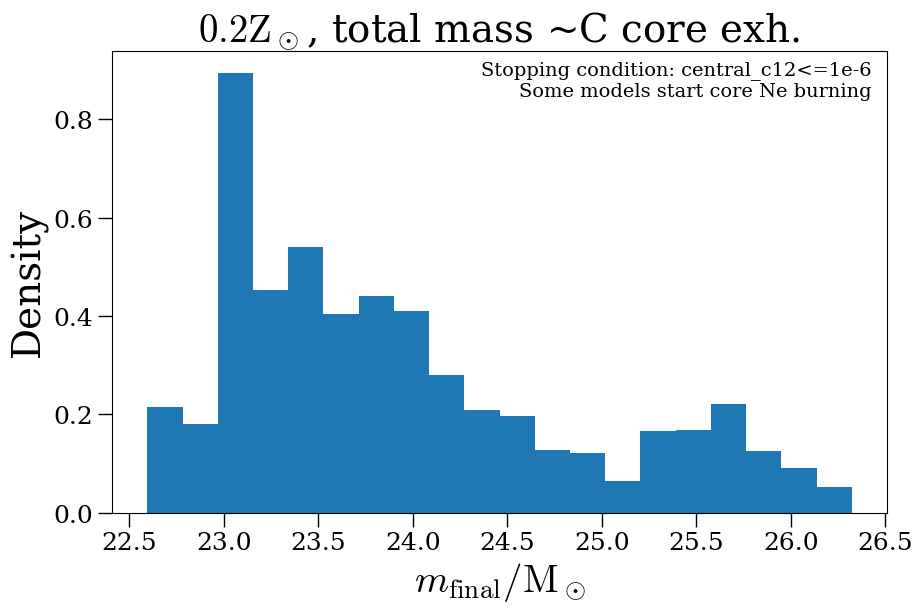

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(result[0][:,3], density=True, bins=20)

#ax.vlines(35, 0, 0.3, color='k', lw=0.5)
#ax.set_ylim(0, 0.25)
#ax.set_xlim(30, 45)
#ax.set_xticks(np.arange(30, 50, 2.5))

ax.set_ylabel('Density')
ax.set_xlabel('$m_\\mathrm{final}/\mathrm{M}_\odot$')
ax.set_title('$1.0\\mathrm{Z}_\\odot$, total mass ~C core exh.')

note = '\n'.join(('Stopping condition: central_c12<=1e-6',
                  'Some models start core Ne burning'))
ax.text(0.98, 
        0.98, 
        note,
        transform=ax.transAxes,
        ha='right',
        va='top',
        fontsize=14
        )


## Comparison

Text(0.98, 0.98, 'Stopping condition: central_c12<=1e-6\nSome models start core Ne burning')

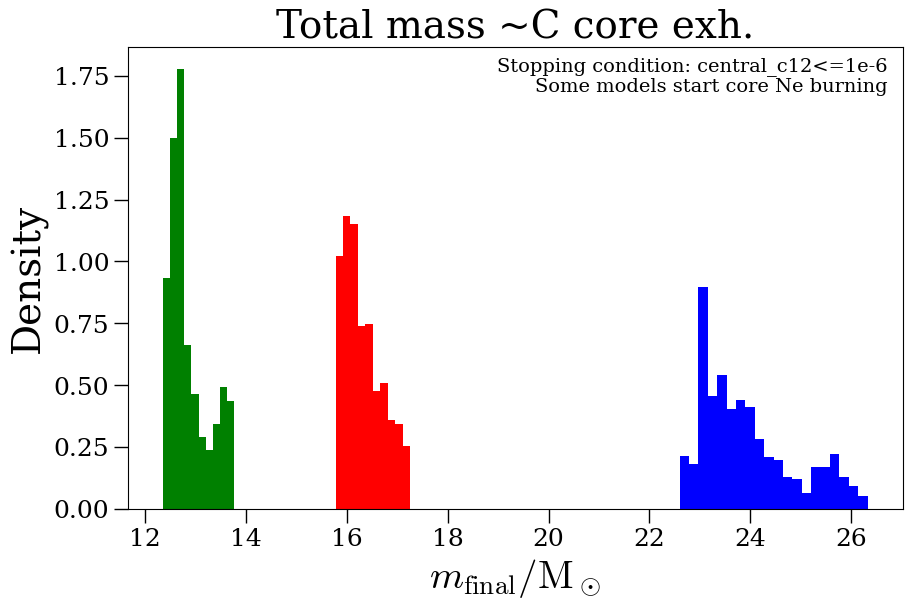

In [223]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(result01[0][:,3], density=True, bins=20, color='b', label='$0.2\mathrm{Z}_\odot$')
ax.hist(result02[0][:,3], density=True, bins=10, color='r', label='$0.4\mathrm{Z}_\odot$')
ax.hist(result03[0][:,3], density=True, bins=10, color='g', label='$0.6\mathrm{Z}_\odot$')

#ax.vlines(35, 0, 0.3, color='k', lw=0.5)
#ax.set_ylim(0, 0.25)
#ax.set_xlim(30, 45)
#ax.set_xticks(np.arange(30, 50, 2.5))

ax.set_ylabel('Density')
ax.set_xlabel('$m_\\mathrm{final}/\mathrm{M}_\odot$')
ax.set_title('Total mass ~C core exh.')

note = '\n'.join(('Stopping condition: central_c12<=1e-6',
                  'Some models start core Ne burning'))
ax.text(0.98, 
        0.98, 
        note,
        transform=ax.transAxes,
        ha='right',
        va='top',
        fontsize=14
        )
